In [ ]:
# List all files in the current directory to show the user
# The original files and the new combined file should be present.
import os
print("--- Files available in the current session ---")
print(os.listdir())
print("---------------------------------------------")

--- Files available in the current session ---
['.config', 'combined_electric_car_data.csv', 'Global_Fuel_Prices_Database.xlsx', 'car-sales.csv', 'electric-car-sales-share.csv', 'DCOILBRENTEU.csv', 'bev-share-new-ev.csv', 'share-car-stocks-electric.csv', 'GlobalEVOutlook2025PolicyExplorer.xlsx', 'electric-car-sales.csv', 'share-car-sales-battery-plugin.csv', 'RWTCd.xls', 'sample_data']
---------------------------------------------


In [ ]:
import pandas as pd
from functools import reduce

# List of the 5 unique file names to be merged.
# 'electric-car-sales.csv' is excluded because its data
# is already in 'car-sales.csv'.
files_to_merge = [
    "share-car-stocks-electric.csv",
    "car-sales.csv",
    "electric-car-sales-share.csv",
    "share-car-sales-battery-plugin.csv",
    "bev-share-new-ev.csv"
]

# Read all files into a list of DataFrames
try:
    dfs = [pd.read_csv(f) for f in files_to_merge]
    print(f"Successfully loaded {len(dfs)} dataframes for merging.")

    # Define the common keys for merging
    merge_keys = ['Entity', 'Code', 'Year']

    # Use reduce to iteratively merge all dataframes in the list
    # 'how=outer' ensures no data is lost if a row (Entity/Year)
    # only exists in some files.
    merged_df = reduce(lambda left, right: pd.merge(left, right, on=merge_keys, how='outer'), dfs)

    # Sort the final dataframe for better readability
    merged_df.sort_values(by=['Entity', 'Year'], inplace=True)

    print("\n--- Merged DataFrame Info ---")
    merged_df.info()

    print("\n--- Merged DataFrame Head ---")
    print(merged_df.head())

    # Save the merged dataframe to a new CSV file
    output_filename = 'combined_electric_car_data.csv'
    merged_df.to_csv(output_filename, index=False)

    print(f"\nSuccessfully combined all data into '{output_filename}'.")

except Exception as e:
    print(f"An error occurred during the merging process: {e}")

Successfully loaded 5 dataframes for merging.

--- Merged DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 10 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Entity                                             499 non-null    object 
 1   Code                                               454 non-null    object 
 2   Year                                               499 non-null    int64  
 3   Share of car stocks that are electric              489 non-null    float64
 4   Electric cars sold                                 443 non-null    float64
 5   Non-electric car sales                             443 non-null    float64
 6   Share of new cars that are electric                492 non-null    float64
 7   Plug-in hybrid as a share of cars sold             443 non-null    float64
 8   Battery-elect

```text?code_stdout&code_event_index=2
--- Files available in the current session ---
['share-car-stocks-electric.csv', 'car-sales.csv', 'electric-car-sales.csv', 'electric-car-sales-share.csv', 'share-car-sales-battery-plugin.csv', 'bev-share-new-ev.csv', 'combined_electric_car_data.csv']
---------------------------------------------

```

The file `combined_electric_car_data.csv` is saved in the temporary code execution environment for our current session.

This means it's not on your local computer (like your 'Downloads' or 'Desktop' folder). It's in the sandboxed environment where I run the code.

I can access it to perform any further analysis, calculations, or visualizations you'd like. However, it will be deleted once our conversation session ends.

In [ ]:
# Libraries
import pandas as pd
import yfinance as yf
import wbdata
import datetime

# Load the cleaned EV data first to get the list of countries
try:
    df_ev = pd.read_csv('cleaned_ev_adoption_infra.csv')
    print("EV data loaded successfully.")
except FileNotFoundError:
    print("Error: 'cleaned_ev_adoption_infra.csv' not found. Please run the EV data cleaning step first.")
    df_ev = pd.DataFrame() # Create an empty DataFrame to avoid further errors

# 2️⃣ Oil Prices
oil = yf.download("CL=F", start="2015-01-01", end="2025-01-01")
oil = oil[['Close']].reset_index()
oil['year'] = pd.DatetimeIndex(oil['Date']).year
oil_yearly = oil.groupby('year')['Close'].mean().reset_index()
oil_yearly.rename(columns={'Close':'oil_price'}, inplace=True)

# 3️⃣ GDP & Population from World Bank
start_year = 2015
end_year = 2024

# Check if df_ev is not empty before getting countries
if not df_ev.empty:
    countries = df_ev['entity'].unique().tolist() # Use 'entity' as per cleaned EV data
    data_indicators = {'NY.GDP.PCAP.CD':'GDP_per_capita','SP.POP.TOTL':'Population'}

    # Fetch data
    gdp_pop = wbdata.get_dataframe(indicators=data_indicators, country=countries, data_date=(start_year, end_year))
    gdp_pop.reset_index(inplace=True)
    gdp_pop.rename(columns={'date':'year','country':'Country'}, inplace=True)
    gdp_pop['year'] = gdp_pop['year'].astype(int)

    # Display top rows
    print(oil_yearly.head())
    print(gdp_pop.head())
else:
    print("Skipping GDP & Population data fetch due to missing EV data.")

Error: 'cleaned_ev_adoption_infra.csv' not found. Please run the EV data cleaning step first.


/tmp/ipython-input-3692990844.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  oil = yf.download("CL=F", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Skipping GDP & Population data fetch due to missing EV data.


# **DOWNLOADING AND CCLEANING**

In [ ]:
import pandas as pd
import numpy as np

# Define the file path
ev_file = 'combined_electric_car_data.csv'
cleaned_ev_file = 'cleaned_ev_adoption_infra.csv'
start_year = 2015
end_year = 2024 # Data beyond 2024 might be projections or incomplete

print(f"--- Cleaning EV Adoption Data ({ev_file}) ---")

try:
    # Load the dataset
    df_ev = pd.read_csv(ev_file)
    print(f"Original shape: {df_ev.shape}")

    # --- Basic Inspection ---
    print("\n--- Initial Info ---")
    df_ev.info()

    print("\n--- Missing Values Before Cleaning ---")
    print(df_ev.isnull().sum())

    print(f"\n--- Duplicate Rows Before Cleaning: {df_ev.duplicated().sum()} ---")

    # --- Filtering ---
    # Keep only data within the desired year range
    df_ev_filtered = df_ev[(df_ev['Year'] >= start_year) & (df_ev['Year'] <= end_year)].copy()
    print(f"\nShape after filtering years ({start_year}-{end_year}): {df_ev_filtered.shape}")

    # --- Handling Missing Values ---
    # For numerical columns related to sales, stock, share: fill NaN with 0
    # Assumption: Missing data likely means zero sales/stock for that country/year.
    numerical_cols = df_ev_filtered.select_dtypes(include=np.number).columns.tolist()
    # Exclude 'Year' from filling with 0 if it's considered numerical
    if 'Year' in numerical_cols:
        numerical_cols.remove('Year')

    for col in numerical_cols:
        df_ev_filtered[col] = df_ev_filtered[col].fillna(0)

    # Check for NaNs in 'Code' (Country Code) - fill with 'Unknown' or drop if critical
    df_ev_filtered['Code'] = df_ev_filtered['Code'].fillna('Unknown')

    # Drop rows if 'Entity' (Country Name) is missing (unlikely but good practice)
    df_ev_filtered.dropna(subset=['Entity'], inplace=True)

    print("\n--- Missing Values After Cleaning ---")
    print(df_ev_filtered.isnull().sum())

    # --- Handling Duplicates ---
    # Check for duplicates based on key identifiers (Country, Year)
    duplicates = df_ev_filtered.duplicated(subset=['Entity', 'Year'], keep='first').sum()
    print(f"\n--- Duplicate Rows (Entity, Year) Found: {duplicates} ---")
    if duplicates > 0:
        df_ev_filtered.drop_duplicates(subset=['Entity', 'Year'], keep='first', inplace=True)
        print(f"Shape after dropping duplicates: {df_ev_filtered.shape}")

    # --- Standardizing Column Names ---
    # Convert to snake_case (lowercase with underscores)
    df_ev_filtered.columns = df_ev_filtered.columns.str.lower().str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]', '', regex=True)
    print("\n--- Cleaned Column Names ---")
    print(df_ev_filtered.columns.tolist())

    # --- Final Check ---
    print("\n--- Cleaned Data Info ---")
    df_ev_filtered.info()
    print("\n--- Cleaned Data Head ---")
    print(df_ev_filtered.head())

    # --- Save Cleaned Data ---
    df_ev_filtered.to_csv(cleaned_ev_file, index=False)
    print(f"\n✅ Successfully cleaned EV data saved to '{cleaned_ev_file}'")

except FileNotFoundError:
    print(f"Error: File not found at {ev_file}")
except Exception as e:
    print(f"An error occurred during EV data cleaning: {e}")

--- Cleaning EV Adoption Data (combined_electric_car_data.csv) ---
Original shape: (499, 10)

--- Initial Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 10 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Entity                                             499 non-null    object 
 1   Code                                               454 non-null    object 
 2   Year                                               499 non-null    int64  
 3   Share of car stocks that are electric              489 non-null    float64
 4   Electric cars sold                                 443 non-null    float64
 5   Non-electric car sales                             443 non-null    float64
 6   Share of new cars that are electric                492 non-null    float64
 7   Plug-in hybrid as a share of cars sold             443 

In [ ]:
import pandas as pd
import numpy as np
import re
import os

# --- File Paths ---
excel_file = 'Global_Fuel_Prices_Database.xlsx'
sheet_name = 'Reg Gasoline (below RON 95) USD'
cleaned_gas_file = 'cleaned_gasoline_prices.csv'
start_year = 2015
end_year = 2024

print(f"--- Cleaning Gasoline Price Data from Excel (Attempt 2) ---")
print(f"File: {excel_file}")
print(f"Sheet: {sheet_name}")

if not os.path.exists(excel_file):
     print(f"Error: Excel file '{excel_file}' not found.")
else:
    try:
        # Load the specific sheet from the Excel file
        df_gas = pd.read_excel(excel_file, sheet_name=sheet_name)
        print(f"Original shape from sheet '{sheet_name}': {df_gas.shape}")

        # --- Initial Inspection ---
        print("\n--- Initial Info ---")
        df_gas.info()

        # --- Reshaping Data (Wide to Long) ---
        # Convert all column names to string first
        df_gas.columns = df_gas.columns.astype(str)

        # Find the first column that looks like a date (YYYY-MM-DD format or similar)
        date_columns = [col for col in df_gas.columns if re.match(r'\d{4}-\d{2}-\d{2}', col) or re.match(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', col)]
        if not date_columns:
             raise ValueError("Could not find date columns in expected formats.")

        first_date_col_loc = df_gas.columns.get_loc(date_columns[0])

        id_vars = df_gas.columns[:first_date_col_loc].tolist()
        value_vars = df_gas.columns[first_date_col_loc:].tolist()

        # Ensure id_vars are correctly identified (e.g., they shouldn't look like dates)
        id_vars = [var for var in id_vars if not (re.match(r'\d{4}-\d{2}-\d{2}', str(var)) or re.match(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', str(var)))]

        print(f"\nIdentified ID variables: {id_vars}")
        print(f"Identified Value variables start: {value_vars[0]}")

        df_gas_long = pd.melt(df_gas,
                              id_vars=id_vars,
                              value_vars=value_vars,
                              var_name='Date_Str',
                              value_name='Gasoline_Price_USD_Liter')

        print(f"\nShape after melting to long format: {df_gas_long.shape}")

        # --- Data Type Conversion ---
        df_gas_long['Date'] = pd.to_datetime(df_gas_long['Date_Str'], errors='coerce')
        df_gas_long['Year'] = df_gas_long['Date'].dt.year
        df_gas_long['Month'] = df_gas_long['Date'].dt.month
        df_gas_long['Gasoline_Price_USD_Liter'] = pd.to_numeric(df_gas_long['Gasoline_Price_USD_Liter'], errors='coerce')
        df_gas_long.dropna(subset=['Date'], inplace=True)

        # --- Filtering ---
        df_gas_filtered = df_gas_long[(df_gas_long['Year'] >= start_year) & (df_gas_long['Year'] <= end_year)].copy()
        print(f"\nShape after filtering years ({start_year}-{end_year}): {df_gas_filtered.shape}")

        # --- Handling Missing Values ---
        print("\n--- Missing Prices Before Handling ---")
        print(df_gas_filtered['Gasoline_Price_USD_Liter'].isnull().sum())
        country_col_name = next((col for col in id_vars if 'Country' in col and 'Code' not in col), None) # Find original country column name
        if country_col_name:
             df_gas_filtered.sort_values(by=[country_col_name, 'Date'], inplace=True)
             df_gas_filtered['Gasoline_Price_USD_Liter'] = df_gas_filtered.groupby(country_col_name)['Gasoline_Price_USD_Liter'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
        else:
             print("Warning: Original 'Country' column not found, cannot interpolate prices by group.")
        df_gas_filtered.dropna(subset=['Gasoline_Price_USD_Liter'], inplace=True)
        print(f"Shape after handling missing prices: {df_gas_filtered.shape}")

        # --- Standardizing Column Names ---
        # **FIX:** Convert columns to string *before* applying .str methods
        df_gas_filtered.columns = df_gas_filtered.columns.astype(str)
        df_gas_filtered.columns = df_gas_filtered.columns.str.lower().str.replace('[^a-zA-Z0-9_]', '', regex=True).str.replace('__', '_')

        # Identify actual names for key columns after cleaning
        country_col_clean = next((col for col in df_gas_filtered.columns if 'country' in col and 'code' not in col), None)
        code_col_clean = next((col for col in df_gas_filtered.columns if 'code' in col or 'countrycode' in col), None)

        # Rename to standard names
        rename_dict = {}
        if country_col_clean and country_col_clean != 'country':
             rename_dict[country_col_clean] = 'country'
        if code_col_clean and code_col_clean != 'code':
             rename_dict[code_col_clean] = 'code'

        # Find and rename fuel description column if needed
        potential_desc_col = id_vars[0].lower().replace('[^a-zA-Z0-9_]', '').replace('__', '_') if id_vars else None
        if potential_desc_col and potential_desc_col in df_gas_filtered.columns and potential_desc_col != 'fuel_description':
             rename_dict[potential_desc_col] = 'fuel_description'

        df_gas_filtered.rename(columns=rename_dict, inplace=True)
        print("\n--- Cleaned Column Names ---")
        print(df_gas_filtered.columns.tolist())

        # Select and reorder relevant columns
        final_cols = ['country', 'code', 'year', 'month', 'date', 'gasoline_price_usd_liter']
        final_cols_exist = [col for col in final_cols if col in df_gas_filtered.columns]
        # Ensure country and code are present, even if renaming failed
        if 'country' not in final_cols_exist and country_col_clean in df_gas_filtered.columns:
            final_cols_exist.insert(0, country_col_clean)
        if 'code' not in final_cols_exist and code_col_clean in df_gas_filtered.columns:
            final_cols_exist.insert(1, code_col_clean)

        df_gas_cleaned = df_gas_filtered[final_cols_exist]


        # --- Handling Duplicates ---
        # Use the potentially renamed column names for checking
        country_key = 'country' if 'country' in df_gas_cleaned.columns else country_col_clean
        if country_key and country_key in df_gas_cleaned.columns and 'date' in df_gas_cleaned.columns:
            duplicates = df_gas_cleaned.duplicated(subset=[country_key, 'date'], keep='first').sum()
            print(f"\n--- Duplicate Rows ({country_key}, Date) Found: {duplicates} ---")
            if duplicates > 0:
                df_gas_cleaned.drop_duplicates(subset=[country_key, 'date'], keep='first', inplace=True)
                print(f"Shape after dropping duplicates: {df_gas_cleaned.shape}")
        else:
             print("\nSkipping duplicate check: Key columns ('country'/'Country' or 'date') missing.")

        # --- Final Check ---
        print("\n--- Cleaned Data Info ---")
        df_gas_cleaned.info()
        print("\n--- Cleaned Data Head ---")
        print(df_gas_cleaned.head())

        # --- Save Cleaned Data ---
        df_gas_cleaned.to_csv(cleaned_gas_file, index=False)
        print(f"\n✅ Successfully cleaned and reshaped Gasoline data saved to '{cleaned_gas_file}'")

    except ValueError as ve:
         print(f"ValueError during processing: {ve}")
         print("Please check the sheet structure and column names.")
    except Exception as e:
        print(f"An error occurred during Gasoline data cleaning from Excel: {e}")
        print("Check if the sheet name is correct, column headers are standard, and data format is consistent.")

--- Cleaning Gasoline Price Data from Excel (Attempt 2) ---
File: Global_Fuel_Prices_Database.xlsx
Sheet: Reg Gasoline (below RON 95) USD
Original shape from sheet 'Reg Gasoline (below RON 95) USD': (123, 119)

--- Initial Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Columns: 119 entries, Regular Gasoline (LCU/liter) to 2025-04-01 00:00:00
dtypes: float64(114), object(5)
memory usage: 114.5+ KB

Identified ID variables: ['Regular Gasoline (LCU/liter)', 'Country', 'Country Code', 'Original Units', 'Converted Units', 'Default MAP (1 to show)']
Identified Value variables start: 2015-12-01 00:00:00

Shape after melting to long format: (13899, 8)

Shape after filtering years (2015-2024): (13407, 11)

--- Missing Prices Before Handling ---
2699
Shape after handling missing prices: (12862, 11)

--- Cleaned Column Names ---
['regulargasolinelculiter', 'country', 'code', 'originalunits', 'convertedunits', 'defaultmap1toshow', 'date_str', 'gasoline_price_usd_l

/tmp/ipython-input-2185103798.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gas_cleaned.drop_duplicates(subset=[country_key, 'date'], keep='first', inplace=True)


In [ ]:
import pandas as pd
import numpy as np

# Define file paths
wti_file = 'RWTCd.xls - Data 1.csv'
brent_file = 'DCOILBRENTEU.csv'
cleaned_wti_file = 'cleaned_wti_monthly.csv'
cleaned_brent_file = 'cleaned_brent_monthly.csv'
start_year = 2015
end_year = 2024

print(f"--- Cleaning WTI Crude Oil Data ({wti_file}) ---")

try:
    # Load WTI data, skipping header rows
    df_wti = pd.read_csv(wti_file, skiprows=2)

    # Rename columns
    df_wti.rename(columns={
        df_wti.columns[0]: 'Date_Excel',
        df_wti.columns[1]: 'WTI_Price_USD_Barrel'
    }, inplace=True)

    # Convert Excel date number to datetime
    df_wti['Date'] = pd.to_datetime(df_wti['Date_Excel'], unit='D', origin='1899-12-30')

    # Convert Price to numeric, coercing errors
    df_wti['WTI_Price_USD_Barrel'] = pd.to_numeric(df_wti['WTI_Price_USD_Barrel'], errors='coerce')

    # Drop rows where date or price conversion failed
    df_wti.dropna(subset=['Date', 'WTI_Price_USD_Barrel'], inplace=True)

    # Filter by year
    df_wti_filtered = df_wti[(df_wti['Date'].dt.year >= start_year) & (df_wti['Date'].dt.year <= end_year)].copy()
    print(f"Shape after filtering years ({start_year}-{end_year}): {df_wti_filtered.shape}")

    # Set Date as index for resampling
    df_wti_filtered.set_index('Date', inplace=True)

    # Resample to Monthly Average
    df_wti_monthly = df_wti_filtered['WTI_Price_USD_Barrel'].resample('M').mean().reset_index() # 'M' for month-end frequency
    # Add Year and Month columns
    df_wti_monthly['Year'] = df_wti_monthly['Date'].dt.year
    df_wti_monthly['Month'] = df_wti_monthly['Date'].dt.month

    # Rename and reorder
    df_wti_monthly = df_wti_monthly[['Year', 'Month', 'Date', 'WTI_Price_USD_Barrel']]

    # Check for NaNs (e.g., if a whole month was missing data)
    print("\n--- Missing Values After Resampling ---")
    print(df_wti_monthly.isnull().sum())
    # Fill any potential gaps if needed (e.g., forward fill)
    df_wti_monthly['WTI_Price_USD_Barrel'].ffill(inplace=True)

    print("\n--- Cleaned WTI Monthly Data Head ---")
    print(df_wti_monthly.head())

    # Save Cleaned Data
    df_wti_monthly.to_csv(cleaned_wti_file, index=False)
    print(f"\n✅ Successfully cleaned WTI data saved to '{cleaned_wti_file}'")

except FileNotFoundError:
    print(f"Error: File not found at {wti_file}")
except Exception as e:
    print(f"An error occurred during WTI data cleaning: {e}")


print(f"\n--- Cleaning Brent Crude Oil Data ({brent_file}) ---")

try:
    # Load Brent data
    df_brent = pd.read_csv(brent_file)
    print(f"Original shape: {df_brent.shape}")

    # Rename columns
    df_brent.rename(columns={
        'observation_date': 'Date',
        'DCOILBRENTEU': 'Brent_Price_USD_Barrel'
    }, inplace=True)

    # Convert Date to datetime
    df_brent['Date'] = pd.to_datetime(df_brent['Date'], errors='coerce')

    # Convert Price to numeric, coercing errors
    df_brent['Brent_Price_USD_Barrel'] = pd.to_numeric(df_brent['Brent_Price_USD_Barrel'], errors='coerce')

    # Drop rows where conversion failed
    df_brent.dropna(subset=['Date', 'Brent_Price_USD_Barrel'], inplace=True)
    print(f"Shape after dropping NaNs: {df_brent.shape}")

    # Filter by year
    df_brent_filtered = df_brent[(df_brent['Date'].dt.year >= start_year) & (df_brent['Date'].dt.year <= end_year)].copy()
    print(f"Shape after filtering years ({start_year}-{end_year}): {df_brent_filtered.shape}")

    # Set Date as index for resampling
    df_brent_filtered.set_index('Date', inplace=True)

    # Resample to Monthly Average
    df_brent_monthly = df_brent_filtered['Brent_Price_USD_Barrel'].resample('M').mean().reset_index()
    # Add Year and Month columns
    df_brent_monthly['Year'] = df_brent_monthly['Date'].dt.year
    df_brent_monthly['Month'] = df_brent_monthly['Date'].dt.month

    # Rename and reorder
    df_brent_monthly = df_brent_monthly[['Year', 'Month', 'Date', 'Brent_Price_USD_Barrel']]

    # Check for NaNs
    print("\n--- Missing Values After Resampling ---")
    print(df_brent_monthly.isnull().sum())
    df_brent_monthly['Brent_Price_USD_Barrel'].ffill(inplace=True)

    print("\n--- Cleaned Brent Monthly Data Head ---")
    print(df_brent_monthly.head())

    # Save Cleaned Data
    df_brent_monthly.to_csv(cleaned_brent_file, index=False)
    print(f"\n✅ Successfully cleaned Brent data saved to '{cleaned_brent_file}'")

except FileNotFoundError:
    print(f"Error: File not found at {brent_file}")
except Exception as e:
    print(f"An error occurred during Brent data cleaning: {e}")

--- Cleaning WTI Crude Oil Data (RWTCd.xls - Data 1.csv) ---
Error: File not found at RWTCd.xls - Data 1.csv

--- Cleaning Brent Crude Oil Data (DCOILBRENTEU.csv) ---
Original shape: (1305, 2)
Shape after dropping NaNs: (1265, 2)
Shape after filtering years (2015-2024): (1062, 2)

--- Missing Values After Resampling ---
Year                      0
Month                     0
Date                      0
Brent_Price_USD_Barrel    0
dtype: int64

--- Cleaned Brent Monthly Data Head ---
   Year  Month       Date  Brent_Price_USD_Barrel
0  2020     10 2020-10-31               39.247778
1  2020     11 2020-11-30               42.692381
2  2020     12 2020-12-31               49.993636
3  2021      1 2021-01-31               54.774000
4  2021      2 2021-02-28               62.276500

✅ Successfully cleaned Brent data saved to 'cleaned_brent_monthly.csv'


/tmp/ipython-input-1176599287.py:99: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_brent_monthly = df_brent_filtered['Brent_Price_USD_Barrel'].resample('M').mean().reset_index()
/tmp/ipython-input-1176599287.py:110: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_brent_monthly['Brent_Price_USD_Barrel'].ffill(inplace=True)


In [ ]:
import pandas as pd
import numpy as np
import re # Needed for sheet name matching
import os # To check file existence

# --- File Paths ---
excel_policy_file = 'GlobalEVOutlook2025PolicyExplorer.xlsx'
cleaned_policy_file = 'combined_policy_data_raw.csv'
start_year = 2015
end_year = 2024

print(f"--- Combining and Cleaning Policy Data from Excel ({excel_policy_file}) ---")

# Check if the Excel file exists
if not os.path.exists(excel_policy_file):
    print(f"Error: Excel file '{excel_policy_file}' not found.")
    print("Available files:", os.listdir())
else:
    try:
        # Get all sheet names from the Excel file
        xls = pd.ExcelFile(excel_policy_file)
        all_sheet_names = xls.sheet_names
        # Filter sheet names to include only those starting with "Table " followed by a number
        policy_sheet_names = [name for name in all_sheet_names if re.match(r'^Table \d+$', name)]
        print(f"Found {len(policy_sheet_names)} policy sheets in the Excel file.")

        if not policy_sheet_names:
            raise ValueError("No sheets matching the pattern 'Table *' found in the Excel file.")

        # List to hold individual DataFrames
        policy_dfs = []

        # Loop through each relevant sheet, read it
        for i, sheet in enumerate(policy_sheet_names):
            try:
                # Read the sheet
                # Sometimes the first column might be unnamed index if exported incorrectly, handle it
                df_temp = pd.read_excel(excel_policy_file, sheet_name=sheet)
                # Check if first column name indicates it's an unnamed index
                if df_temp.columns[0].startswith('Unnamed'):
                    df_temp = pd.read_excel(excel_policy_file, sheet_name=sheet, index_col=0)
                    df_temp.reset_index(inplace=True, drop=True)

                df_temp['Source_Table'] = sheet # Use sheet name as source identifier
                policy_dfs.append(df_temp)
            except Exception as read_e:
                print(f"Warning: Could not read or process sheet '{sheet}': {read_e}")

        # Concatenate all DataFrames
        df_policy_combined = pd.concat(policy_dfs, ignore_index=True)
        print(f"\nOriginal combined shape from sheets: {df_policy_combined.shape}")

        # --- Basic Inspection ---
        print("\n--- Initial Combined Info ---")
        df_policy_combined.info()

        print("\n--- Missing Values Before Cleaning ---")
        print(df_policy_combined.isnull().sum())

        # --- Filtering ---
        # Ensure 'Year' column exists before proceeding
        if 'Year' not in df_policy_combined.columns:
             raise KeyError("Column 'Year' not found in the combined policy data. Check sheet structures.")

        df_policy_combined['Year'] = pd.to_numeric(df_policy_combined['Year'], errors='coerce')
        df_policy_combined.dropna(subset=['Year'], inplace=True)
        df_policy_combined['Year'] = df_policy_combined['Year'].astype(int)

        df_policy_filtered = df_policy_combined[(df_policy_combined['Year'] >= start_year) & (df_policy_combined['Year'] <= end_year)].copy()
        print(f"\nShape after filtering years ({start_year}-{end_year}): {df_policy_filtered.shape}")

        # --- Handling Missing Values ---
        # Identify potential categorical columns more robustly
        categorical_cols = ['Region', 'Country / Economy', 'Policy Level', 'Policy Type', 'Category', 'Source']
        for col in categorical_cols:
            if col in df_policy_filtered.columns:
                df_policy_filtered[col] = df_policy_filtered[col].fillna('Unknown')
            else:
                 print(f"Warning: Expected categorical column '{col}' not found.")
        # Key policy measures - keep NaNs

        # --- Standardizing Column Names ---
        df_policy_filtered.columns = df_policy_filtered.columns.astype(str) # Ensure all are strings
        df_policy_filtered.columns = df_policy_filtered.columns.str.lower().str.replace(' / ', '_', regex=False).str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]', '', regex=True)
        # Rename specific columns if they exist after cleaning
        rename_dict = {'country_economy':'country'}
        existing_rename_dict = {k: v for k, v in rename_dict.items() if k in df_policy_filtered.columns}
        df_policy_filtered.rename(columns=existing_rename_dict, inplace=True)

        print("\n--- Cleaned Column Names ---")
        print(df_policy_filtered.columns.tolist())

        # --- Handling Duplicates ---
        duplicates = df_policy_filtered.duplicated().sum()
        print(f"\n--- Exact Duplicate Rows Found: {duplicates} ---")
        if duplicates > 0:
            df_policy_filtered.drop_duplicates(inplace=True)
            print(f"Shape after dropping exact duplicates: {df_policy_filtered.shape}")

        # --- Final Check ---
        print("\n--- Cleaned Policy Data Info ---")
        df_policy_filtered.info()
        print("\n--- Cleaned Policy Data Head ---")
        print(df_policy_filtered.head())

        # --- Save Combined (but still raw) Data ---
        df_policy_filtered.to_csv(cleaned_policy_file, index=False)
        print(f"\n✅ Successfully combined and performed basic cleaning on Policy data from Excel.")
        print(f"   Saved to '{cleaned_policy_file}'. Further feature engineering needed for analysis.")

    except ValueError as ve:
        print(f"ValueError during processing: {ve}")
    except KeyError as ke:
         print(f"KeyError: {ke}. One of the expected columns might be missing or named differently across sheets.")
    except Exception as e:
        print(f"An error occurred during Policy data cleaning from Excel: {e}")

--- Combining and Cleaning Policy Data from Excel (GlobalEVOutlook2025PolicyExplorer.xlsx) ---
Found 22 policy sheets in the Excel file.

Original combined shape from sheets: (746, 10)

--- Initial Combined Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 10 columns):
 #   Column                                                                                  Non-Null Count  Dtype  
---  ------                                                                                  --------------  -----  
 0   Region                                                                                  685 non-null    object 
 1   Country / Economy                                                                       364 non-null    object 
 2   Policy Level                                                                            680 non-null    object 
 3   Policy Type                                                                             6

In [ ]:
# Code Block for Step 3, Part 3: Cleaning Oil Price Data

import pandas as pd
import numpy as np
import os # Import os to check file existence

# Define file paths
wti_excel_file = 'RWTCd.xls' # Source Excel file
wti_csv_file = 'RWTCd.xls - Data 1.csv' # Check if CSV version exists
brent_file = 'DCOILBRENTEU.csv'
cleaned_wti_file = 'cleaned_wti_monthly.csv'
cleaned_brent_file = 'cleaned_brent_monthly.csv'
start_year = 2015
end_year = 2024 # Or adjust as needed

print(f"--- Cleaning WTI Crude Oil Data ---")

# Determine which WTI file source to use (prefer CSV if available)
wti_source_file = None
wti_skiprows = 0
if os.path.exists(wti_csv_file):
    wti_source_file = wti_csv_file
    wti_skiprows = 2 # CSV export seems to retain header rows
    print(f"Using CSV source: {wti_csv_file}")
elif os.path.exists(wti_excel_file):
     wti_source_file = wti_excel_file
     wti_skiprows = 2 # Standard skip for EIA Excel
     print(f"Using Excel source: {wti_excel_file}, Sheet 'Data 1'")
else:
     print(f"Error: Neither '{wti_csv_file}' nor '{wti_excel_file}' found.")
     wti_source_file = None

if wti_source_file:
    try:
        # Load WTI data based on identified source
        if wti_source_file.endswith('.csv'):
             df_wti = pd.read_csv(wti_source_file, skiprows=wti_skiprows)
        else: # Must be Excel
             df_wti = pd.read_excel(wti_source_file, sheet_name='Data 1', skiprows=wti_skiprows)

        print(f"Loaded WTI data successfully. Original shape: {df_wti.shape}")

        # Rename columns (handle potential variations)
        df_wti.rename(columns={
            df_wti.columns[0]: 'Date_Source', # Keep original date format (Excel num or string)
            df_wti.columns[1]: 'WTI_Price_USD_Barrel'
        }, inplace=True)

        # Convert Date - handle Excel numbers or date strings
        try:
             # Try converting from Excel float format first
             df_wti['Date'] = pd.to_datetime(df_wti['Date_Source'], unit='D', origin='1899-12-30')
        except (ValueError, TypeError):
             # Fallback to standard datetime parsing if the above fails
             df_wti['Date'] = pd.to_datetime(df_wti['Date_Source'], errors='coerce')

        # Convert Price to numeric, coercing errors
        df_wti['WTI_Price_USD_Barrel'] = pd.to_numeric(df_wti['WTI_Price_USD_Barrel'], errors='coerce')

        # Drop rows where date or price conversion failed
        df_wti.dropna(subset=['Date', 'WTI_Price_USD_Barrel'], inplace=True)
        print(f"Shape after initial cleaning and date conversion: {df_wti.shape}")


        # Filter by year
        df_wti_filtered = df_wti[(df_wti['Date'].dt.year >= start_year) & (df_wti['Date'].dt.year <= end_year)].copy()
        print(f"Shape after filtering years ({start_year}-{end_year}): {df_wti_filtered.shape}")

        if not df_wti_filtered.empty:
            # Set Date as index for resampling
            df_wti_filtered.set_index('Date', inplace=True)

            # Resample to Monthly Average
            df_wti_monthly = df_wti_filtered['WTI_Price_USD_Barrel'].resample('M').mean().reset_index()
            df_wti_monthly['Year'] = df_wti_monthly['Date'].dt.year
            df_wti_monthly['Month'] = df_wti_monthly['Date'].dt.month
            df_wti_monthly = df_wti_monthly[['Year', 'Month', 'Date', 'WTI_Price_USD_Barrel']]

            print("\n--- Missing WTI Values After Resampling ---")
            print(df_wti_monthly.isnull().sum())
            df_wti_monthly['WTI_Price_USD_Barrel'].ffill(inplace=True) # Forward fill any gaps
            df_wti_monthly.dropna(inplace=True) # Drop if any NaNs remain at start

            print("\n--- Cleaned WTI Monthly Data Head ---")
            print(df_wti_monthly.head())

            # Save Cleaned Data
            df_wti_monthly.to_csv(cleaned_wti_file, index=False)
            print(f"\n✅ Successfully cleaned WTI data saved to '{cleaned_wti_file}'")
        else:
             print("Warning: No WTI data remaining after filtering for specified years.")


    except FileNotFoundError:
        print(f"Error: File not found at {wti_source_file}")
    except Exception as e:
        print(f"An error occurred during WTI data cleaning: {e}")


print(f"\n--- Cleaning Brent Crude Oil Data ({brent_file}) ---")

if not os.path.exists(brent_file):
    print(f"Error: Brent file '{brent_file}' not found.")
else:
    try:
        # Load Brent data
        df_brent = pd.read_csv(brent_file)
        print(f"Original shape: {df_brent.shape}")

        # Rename columns
        df_brent.rename(columns={
            'observation_date': 'Date',
            'DCOILBRENTEU': 'Brent_Price_USD_Barrel'
        }, inplace=True)

        # Convert Date to datetime
        df_brent['Date'] = pd.to_datetime(df_brent['Date'], errors='coerce')

        # Convert Price to numeric, coercing errors
        df_brent['Brent_Price_USD_Barrel'] = pd.to_numeric(df_brent['Brent_Price_USD_Barrel'], errors='coerce')

        # Drop rows where conversion failed
        df_brent.dropna(subset=['Date', 'Brent_Price_USD_Barrel'], inplace=True)
        print(f"Shape after dropping NaNs: {df_brent.shape}")

        # Filter by year
        df_brent_filtered = df_brent[(df_brent['Date'].dt.year >= start_year) & (df_brent['Date'].dt.year <= end_year)].copy()
        print(f"Shape after filtering years ({start_year}-{end_year}): {df_brent_filtered.shape}")

        if not df_brent_filtered.empty:
            # Set Date as index for resampling
            df_brent_filtered.set_index('Date', inplace=True)

            # Resample to Monthly Average
            df_brent_monthly = df_brent_filtered['Brent_Price_USD_Barrel'].resample('M').mean().reset_index()
            df_brent_monthly['Year'] = df_brent_monthly['Date'].dt.year
            df_brent_monthly['Month'] = df_brent_monthly['Date'].dt.month
            df_brent_monthly = df_brent_monthly[['Year', 'Month', 'Date', 'Brent_Price_USD_Barrel']]

            print("\n--- Missing Brent Values After Resampling ---")
            print(df_brent_monthly.isnull().sum())
            df_brent_monthly['Brent_Price_USD_Barrel'].ffill(inplace=True) # Forward fill any gaps
            df_brent_monthly.dropna(inplace=True) # Drop if any NaNs remain at start

            print("\n--- Cleaned Brent Monthly Data Head ---")
            print(df_brent_monthly.head())

            # Save Cleaned Data
            df_brent_monthly.to_csv(cleaned_brent_file, index=False)
            print(f"\n✅ Successfully cleaned Brent data saved to '{cleaned_brent_file}'")
        else:
             print("Warning: No Brent data remaining after filtering for specified years.")

    except FileNotFoundError:
        print(f"Error: File not found at {brent_file}")
    except Exception as e:
        print(f"An error occurred during Brent data cleaning: {e}")

--- Cleaning WTI Crude Oil Data ---
Using Excel source: RWTCd.xls, Sheet 'Data 1'
Loaded WTI data successfully. Original shape: (10020, 2)
Shape after initial cleaning and date conversion: (10020, 3)
Shape after filtering years (2015-2024): (2505, 3)

--- Missing WTI Values After Resampling ---
Year                    0
Month                   0
Date                    0
WTI_Price_USD_Barrel    0
dtype: int64

--- Cleaned WTI Monthly Data Head ---
   Year  Month       Date  WTI_Price_USD_Barrel
0  2015      1 2015-01-31             47.219000
1  2015      2 2015-02-28             50.584211
2  2015      3 2015-03-31             47.823636
3  2015      4 2015-04-30             54.452857
4  2015      5 2015-05-31             59.265000

✅ Successfully cleaned WTI data saved to 'cleaned_wti_monthly.csv'

--- Cleaning Brent Crude Oil Data (DCOILBRENTEU.csv) ---
Original shape: (1305, 2)
Shape after dropping NaNs: (1265, 2)
Shape after filtering years (2015-2024): (1062, 2)

--- Missing Brent V

/tmp/ipython-input-842551425.py:74: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_wti_monthly = df_wti_filtered['WTI_Price_USD_Barrel'].resample('M').mean().reset_index()
/tmp/ipython-input-842551425.py:81: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_wti_monthly['WTI_Price_USD_Barrel'].ffill(inplace=True) # Forward fill any gaps
/tmp/ipython-input-842551425.py:135: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  

# **MERGE**

In [ ]:
import pandas as pd
import numpy as np
import os # Import os to check file existence

# --- File Paths ---
cleaned_ev_file = 'cleaned_ev_adoption_infra.csv'
cleaned_gas_file = 'cleaned_gasoline_prices.csv'
cleaned_wti_file = 'cleaned_wti_monthly.csv'
cleaned_brent_file = 'cleaned_brent_monthly.csv'
cleaned_policy_file = 'combined_policy_data_raw.csv'
final_merged_file = 'final_merged_ev_dataset_annual.csv'

# --- Check if input files exist before proceeding ---
required_files = [cleaned_ev_file, cleaned_gas_file, cleaned_wti_file, cleaned_brent_file, cleaned_policy_file]
missing_files = [f for f in required_files if not os.path.exists(f)]

if missing_files:
    print(f"Error: Cannot start merging. The following required cleaned files are missing:")
    for f in missing_files:
        print(f"- {f}")
    print("\nPlease re-run the corresponding cleaning steps (Step 3) first.")
else:
    print("--- Step 4: Merging Datasets ---")
    try:
        # --- 1. Load Cleaned Datasets ---
        print("Loading cleaned datasets...")
        df_ev = pd.read_csv(cleaned_ev_file)
        df_gas = pd.read_csv(cleaned_gas_file)
        df_wti = pd.read_csv(cleaned_wti_file)
        df_brent = pd.read_csv(cleaned_brent_file)
        df_policy = pd.read_csv(cleaned_policy_file)
        print("Datasets loaded successfully.")

        # --- 2. Prepare for Annual Merging ---

        # EV Data
        # Ensure 'code' column exists and handle potential variations
        if 'code' not in df_ev.columns and 'Code' in df_ev.columns:
             df_ev.rename(columns={'Code':'code'}, inplace=True)
        elif 'code' not in df_ev.columns and 'entity' in df_ev.columns:
             df_ev.rename(columns={'entity':'country_temp'}, inplace=True)
             if 'country_temp' in df_ev.columns:
                print("Warning: Using 'entity' (country name) as merge key component for EV data as 'code' is missing.")

        # Standardize country column name if entity was used
        if 'country_temp' in df_ev.columns and 'country' not in df_ev.columns:
            df_ev.rename(columns={'country_temp': 'country'}, inplace=True)
        elif 'entity' in df_ev.columns and 'country' not in df_ev.columns:
             df_ev.rename(columns={'entity': 'country'}, inplace=True)


        # Select relevant EV columns - ADD ALL AVAILABLE NUMERIC/KEY COLUMNS
        all_ev_cols = ['country', 'code', 'year'] + df_ev.select_dtypes(include=np.number).columns.tolist()
        # Remove year again if it was selected by number type
        if 'year' in all_ev_cols[3:]: all_ev_cols.remove('year')
        # Ensure no duplicates and required keys are present
        all_ev_cols = list(dict.fromkeys(all_ev_cols)) # Remove duplicates while preserving order
        if 'country' not in all_ev_cols: all_ev_cols.insert(0, 'country')
        if 'code' not in all_ev_cols: all_ev_cols.insert(1, 'code')
        if 'year' not in all_ev_cols: all_ev_cols.insert(2, 'year')
        # Filter df_ev to only existing columns
        all_ev_cols = [col for col in all_ev_cols if col in df_ev.columns]

        df_ev_annual = df_ev[all_ev_cols].copy()
        print(f"EV data prepared (shape: {df_ev_annual.shape})")
        print(f"EV columns selected: {df_ev_annual.columns.tolist()}")


        # Gasoline Prices (aggregate monthly to annual average)
        # Ensure country/code columns exist before grouping
        gas_country_key = 'country' if 'country' in df_gas.columns else None
        gas_code_key = 'code' if 'code' in df_gas.columns else None
        gas_group_keys = [key for key in [gas_country_key, gas_code_key, 'year'] if key]

        if len(gas_group_keys) >= 2: # Need at least year and one identifier
            df_gas_annual = df_gas.groupby(gas_group_keys)['gasoline_price_usd_liter'].mean().reset_index()
            print(f"Gasoline prices aggregated annually (shape: {df_gas_annual.shape})")
        else:
            print("Error: Could not find sufficient keys (country/code and year) in gasoline data for aggregation.")
            # Create empty df to avoid downstream errors
            df_gas_annual = pd.DataFrame(columns=['country', 'code', 'year', 'gasoline_price_usd_liter'])


        # WTI Prices (aggregate monthly to annual average)
        df_wti_annual = df_wti.groupby('Year')['WTI_Price_USD_Barrel'].mean().reset_index()
        df_wti_annual.rename(columns={'Year': 'year'}, inplace=True)
        print(f"WTI prices aggregated annually (shape: {df_wti_annual.shape})")

        # Brent Prices (aggregate monthly to annual average)
        df_brent_annual = df_brent.groupby('Year')['Brent_Price_USD_Barrel'].mean().reset_index()
        df_brent_annual.rename(columns={'Year': 'year'}, inplace=True)
        print(f"Brent prices aggregated annually (shape: {df_brent_annual.shape})")

        # Policy Data (aggregate to count of policies per country/year)
        policy_country_key = 'country' if 'country' in df_policy.columns else None
        policy_code_key = 'code' if 'code' in df_policy.columns else None # Assumes cleaning standardized to 'code' if possible
        policy_group_keys = [key for key in [policy_country_key, policy_code_key, 'year'] if key]

        # Determine the primary key to keep for merging (prefer code if available)
        policy_merge_key = None
        policy_group_by_keys_for_count = []
        if policy_code_key:
             policy_merge_key = 'code'
             policy_group_by_keys_for_count = [policy_code_key, 'year']
             if policy_country_key: # Keep country name too if available
                 policy_group_by_keys_for_count.insert(0, policy_country_key)
        elif policy_country_key:
             policy_merge_key = 'country'
             policy_group_by_keys_for_count = [policy_country_key, 'year']
        else:
             print("Error: Policy data lacks suitable key ('country' or 'code'). Skipping policy aggregation.")
             # Create empty df
             df_policy_count = pd.DataFrame(columns=['country', 'code', 'year', 'policy_count']).astype({'year':int})

        if policy_group_by_keys_for_count:
             df_policy_count = df_policy.groupby(policy_group_by_keys_for_count).size().reset_index(name='policy_count')
             print(f"Policy data aggregated to counts (shape: {df_policy_count.shape}) using keys: {policy_group_by_keys_for_count}")


        # --- 3. Perform Merges ---
        print("\nStarting merges...")

        # Determine best keys for EV + Gas merge
        ev_has_code = 'code' in df_ev_annual.columns and df_ev_annual['code'].nunique() > 1
        gas_has_code = 'code' in df_gas_annual.columns and df_gas_annual['code'].nunique() > 1
        ev_has_country = 'country' in df_ev_annual.columns
        gas_has_country = 'country' in df_gas_annual.columns

        merge_key_ev_gas = []
        df_gas_annual_merge = df_gas_annual.copy()

        if ev_has_code and gas_has_code:
            merge_key_ev_gas = ['code', 'year']
            df_gas_annual_merge = df_gas_annual_merge.drop('country', axis=1, errors='ignore') # Avoid duplicate country col
            print("Using 'code' and 'year' to merge EV and Gasoline data.")
        elif ev_has_country and gas_has_country:
            merge_key_ev_gas = ['country', 'year']
            df_gas_annual_merge = df_gas_annual_merge.drop('code', axis=1, errors='ignore') # Avoid duplicate code col
            print("Warning: Using 'country' name and 'year' to merge EV and Gasoline data. Ensure names are consistent.")
        else:
            print("Error: Cannot determine consistent key ('code' or 'country') between EV and Gas data. Skipping merge.")
            df_merged = df_ev_annual.copy() # Start merge process with just EV data

        if merge_key_ev_gas:
             df_merged = pd.merge(df_ev_annual, df_gas_annual_merge, on=merge_key_ev_gas, how='left')
             print(f"Shape after merging EV + Gasoline: {df_merged.shape}")
        else:
             # If merge skipped, df_merged is just df_ev_annual
             pass


        # Merge + WTI (on year)
        df_merged = pd.merge(df_merged, df_wti_annual, on='year', how='left')
        print(f"Shape after merging WTI: {df_merged.shape}")

        # Merge + Brent (on year)
        df_merged = pd.merge(df_merged, df_brent_annual, on='year', how='left')
        print(f"Shape after merging Brent: {df_merged.shape}")

        # Merge + Policy Count
        merge_key_policy = []
        df_policy_merge = df_policy_count.copy()

        if policy_merge_key == 'code' and 'code' in df_merged.columns:
            merge_key_policy = ['code', 'year']
            # Drop country from policy count if merging on code to avoid duplication
            df_policy_merge = df_policy_merge.drop('country', axis=1, errors='ignore')
            print("Using 'code' and 'year' to merge Policy counts.")
        elif policy_merge_key == 'country' and 'country' in df_merged.columns:
             merge_key_policy = ['country', 'year']
             # Drop code from policy count if merging on country
             df_policy_merge = df_policy_merge.drop('code', axis=1, errors='ignore')
             print("Using 'country' name and 'year' to merge Policy counts.")
        else:
             print("Skipping policy merge due to missing keys in policy data or main dataframe.")

        if merge_key_policy:
            df_merged = pd.merge(df_merged, df_policy_merge, on=merge_key_policy, how='left')
            # Fill NaN policy counts with 0
            if 'policy_count' in df_merged.columns:
                df_merged['policy_count'] = df_merged['policy_count'].fillna(0).astype(int)
            print(f"Shape after merging Policy Count: {df_merged.shape}")


        # --- 4. Final Inspection & Save ---
        print("\n--- Final Merged Data Info ---")
        df_merged.info()

        print("\n--- Missing Values in Final Merged Data ---")
        missing_counts = df_merged.isnull().sum()
        print(missing_counts[missing_counts > 0]) # Show only columns with missing values

        print("\n--- Final Merged Data Head ---")
        print(df_merged.head())

        print("\n--- Final Merged Data Tail ---")
        print(df_merged.tail())

        df_merged.to_csv(final_merged_file, index=False)
        print(f"\n✅ Successfully merged available datasets into '{final_merged_file}'")

    except FileNotFoundError as fnf_e:
        print(f"Error: One of the cleaned input files not found. Please ensure cleaning steps ran successfully. Details: {fnf_e}")
    except KeyError as ke:
        print(f"Error: A required column was not found during merging. Check column names in cleaned files. Details: {ke}")
    except Exception as e:
        print(f"An error occurred during merging: {e}")

--- Step 4: Merging Datasets ---
Loading cleaned datasets...
Datasets loaded successfully.
EV data prepared (shape: (340, 10))
EV columns selected: ['country', 'code', 'year', 'share_of_car_stocks_that_are_electric', 'electric_cars_sold', 'nonelectric_car_sales', 'share_of_new_cars_that_are_electric', 'plugin_hybrid_as_a_share_of_cars_sold', 'batteryelectric_as_a_share_of_cars_sold', 'batteryelectric_as_a_share_of_electric_cars_sold']
Gasoline prices aggregated annually (shape: (830, 4))
WTI prices aggregated annually (shape: (10, 2))
Brent prices aggregated annually (shape: (5, 2))
Policy data aggregated to counts (shape: (212, 3)) using keys: ['country', 'year']

Starting merges...
Using 'code' and 'year' to merge EV and Gasoline data.
Shape after merging EV + Gasoline: (340, 11)
Shape after merging WTI: (340, 12)
Shape after merging Brent: (340, 13)
Using 'country' name and 'year' to merge Policy counts.
Shape after merging Policy Count: (340, 14)

--- Final Merged Data Info ---
<cl

# **EDA**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the file path
final_merged_file = 'final_merged_ev_dataset_annual.csv'

print(f"--- Continuing Step 5: Detailed EDA ---")

try:
    # Load the dataset
    df = pd.read_csv(final_merged_file)
    print(f"Loaded {final_merged_file} (Shape: {df.shape})")

    # --- 5. Visualize Distributions ---
    print("\n--- 5. Plotting Distributions ---")

    # Select key numerical columns for distribution plots
    cols_to_plot = [
        'share_of_car_stocks_that_are_electric',
        'electric_cars_sold',
        'share_of_new_cars_that_are_electric',
        'gasoline_price_usd_liter',
        'WTI_Price_USD_Barrel',
        'Brent_Price_USD_Barrel',
        'policy_count'
    ]

    # Create histograms
    plt.style.use('seaborn-v0_8-whitegrid') # Use a clean style
    num_cols = len(cols_to_plot)
    fig, axes = plt.subplots(nrows=(num_cols + 1) // 2, ncols=2, figsize=(12, num_cols * 2))
    axes = axes.flatten() # Flatten the axes array for easy iteration

    for i, col in enumerate(cols_to_plot):
        if col in df.columns:
            sns.histplot(df[col], kde=True, ax=axes[i], bins=30)
            axes[i].set_title(f'Distribution of {col}', fontsize=10)
            axes[i].set_xlabel('') # Keep labels clean
            axes[i].tick_params(axis='x', rotation=45)
        else:
             print(f"Warning: Column '{col}' not found for plotting distribution.")
             axes[i].set_visible(False) # Hide axis if column is missing

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.savefig('distributions.png')
    print("Saved distributions plot to distributions.png")
    plt.clf() # Clear the plot

    # --- 6. Correlation Analysis ---
    print("\n--- 6. Correlation Analysis ---")

    # Select numerical columns for correlation
    # Use the same list + 'year'
    correlation_cols = ['year'] + [col for col in cols_to_plot if col in df.columns]

    if len(correlation_cols) > 1:
        correlation_matrix = df[correlation_cols].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Key Variables')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('correlation_matrix.png')
        print("Saved correlation matrix plot to correlation_matrix.png")
        plt.clf() # Clear the plot

        print("\nCorrelation with 'share_of_new_cars_that_are_electric':")
        # Ensure the target column exists before trying to access correlations
        if 'share_of_new_cars_that_are_electric' in correlation_matrix.columns:
             print(correlation_matrix['share_of_new_cars_that_are_electric'].sort_values(ascending=False))
        else:
             print("Target column 'share_of_new_cars_that_are_electric' not found in correlation matrix.")
    else:
        print("Not enough numerical columns found to calculate correlations.")


    # --- 7. Time Series Trends (Global Averages) ---
    print("\n--- 7. Time Series Trends (Global Averages) ---")

    # Calculate global averages per year for key metrics
    global_trends = df.groupby('year')[[
        'share_of_new_cars_that_are_electric',
        'gasoline_price_usd_liter',
        'WTI_Price_USD_Barrel' # Can add Brent too if desired
    ]].mean().reset_index()

    plt.figure(figsize=(12, 6))

    # Plot EV share trend
    ax1 = plt.gca() # Get current axes
    sns.lineplot(data=global_trends, x='year', y='share_of_new_cars_that_are_electric', marker='o', ax=ax1, color='blue', label='Avg. EV Share of New Cars (%)')
    ax1.set_ylabel('Avg. EV Share (%)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xlabel('Year')
    ax1.set_title('Global Average EV Share vs. Fuel Prices Over Time')

    # Plot fuel price trends on a secondary y-axis
    ax2 = ax1.twinx()
    sns.lineplot(data=global_trends, x='year', y='gasoline_price_usd_liter', marker='s', ax=ax2, color='red', label='Avg. Gasoline Price (USD/Liter)')
    sns.lineplot(data=global_trends, x='year', y='WTI_Price_USD_Barrel', marker='^', ax=ax2, color='green', label='Avg. WTI Crude Price (USD/Barrel)')
    ax2.set_ylabel('Avg. Price (USD)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    ax1.get_legend().remove() # Remove original legend from ax1

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('global_trends_over_time.png')
    print("Saved global trends plot to global_trends_over_time.png")
    plt.clf() # Clear the plot

    print("\n--- Detailed EDA Plots Generated ---")


except FileNotFoundError:
    print(f"Error: Merged file not found at {final_merged_file}.")
except Exception as e:
    print(f"An error occurred during detailed exploration: {e}")

--- Continuing Step 5: Detailed EDA ---
Loaded final_merged_ev_dataset_annual.csv (Shape: (340, 14))

--- 5. Plotting Distributions ---
Saved distributions plot to distributions.png

--- 6. Correlation Analysis ---
Saved correlation matrix plot to correlation_matrix.png

Correlation with 'share_of_new_cars_that_are_electric':
share_of_new_cars_that_are_electric      1.000000
share_of_car_stocks_that_are_electric    0.930682
year                                     0.497146
WTI_Price_USD_Barrel                     0.396418
Brent_Price_USD_Barrel                   0.193651
electric_cars_sold                       0.137464
policy_count                             0.132556
gasoline_price_usd_liter                 0.031252
Name: share_of_new_cars_that_are_electric, dtype: float64

--- 7. Time Series Trends (Global Averages) ---
Saved global trends plot to global_trends_over_time.png

--- Detailed EDA Plots Generated ---


<Figure size 1200x1400 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

--- Step 5: Initial EDA Visualizations ---
Loaded final_merged_ev_dataset_annual.csv (Shape: (340, 14))

--- Plotting Distributions ---

--- Plotting Correlation Analysis ---

Correlation with 'share_of_new_cars_that_are_electric':
share_of_new_cars_that_are_electric      1.000000
share_of_car_stocks_that_are_electric    0.930682
year                                     0.497146
WTI_Price_USD_Barrel                     0.396418
Brent_Price_USD_Barrel                   0.193651
electric_cars_sold                       0.137464
policy_count                             0.132556
gasoline_price_usd_liter                 0.031252
Name: share_of_new_cars_that_are_electric, dtype: float64

--- Initial EDA Plots Generated ---


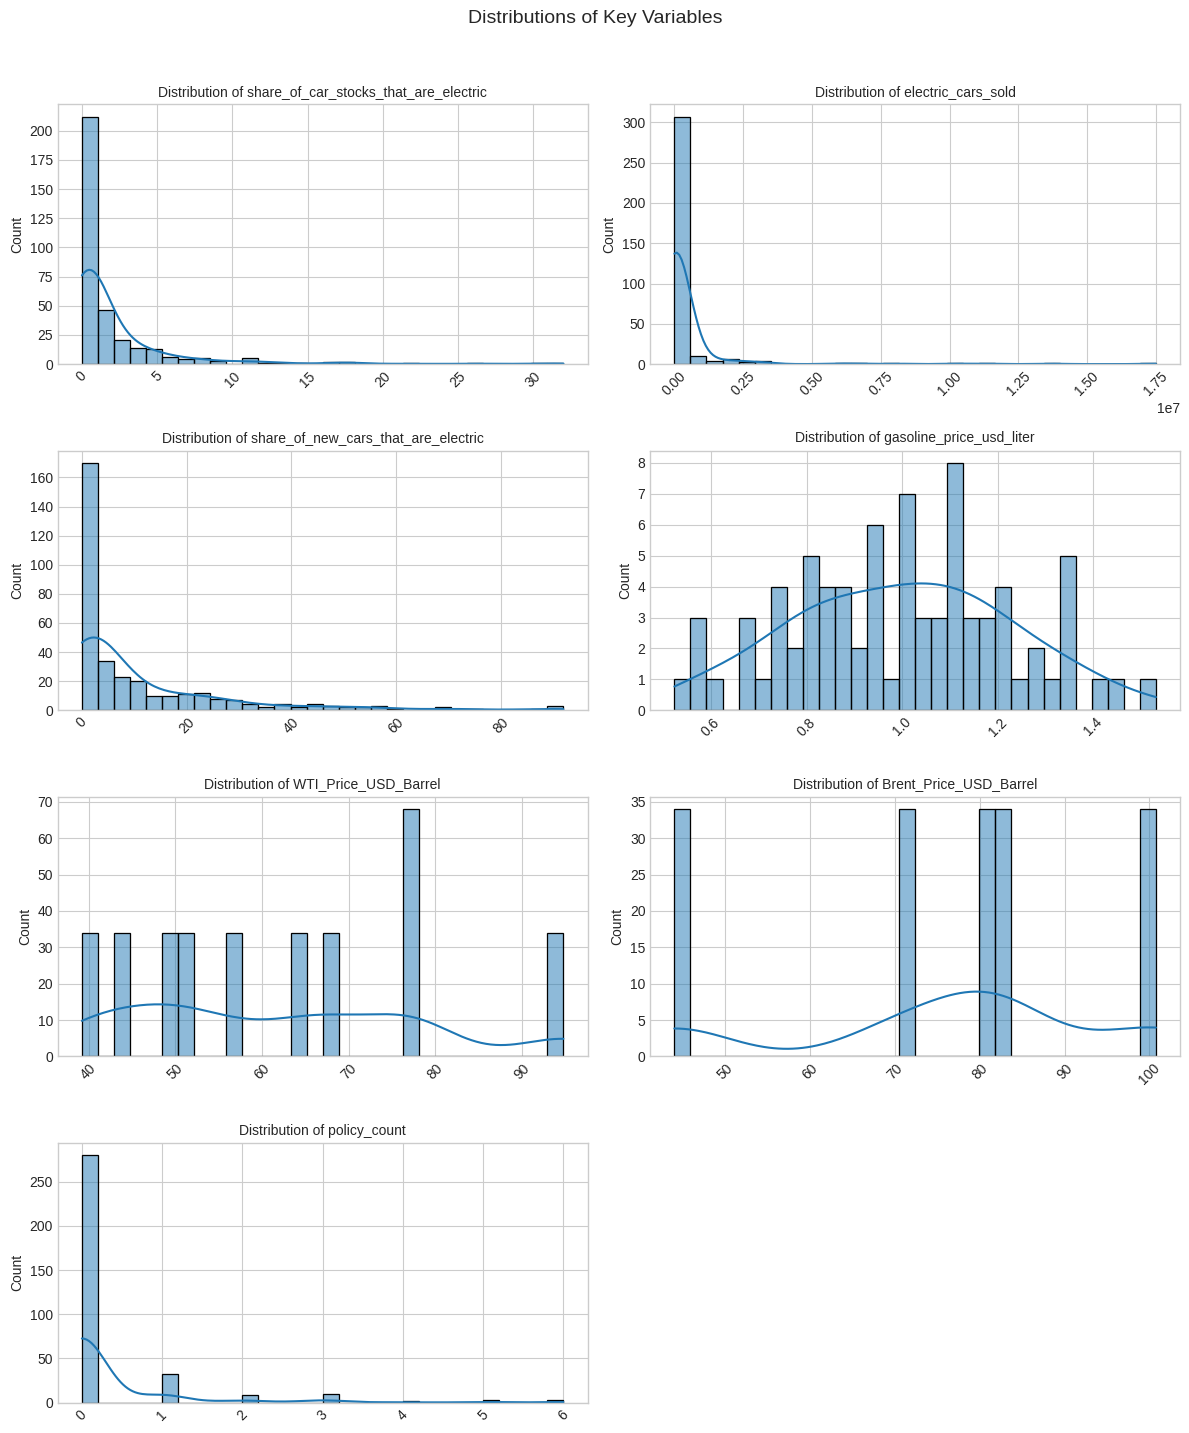

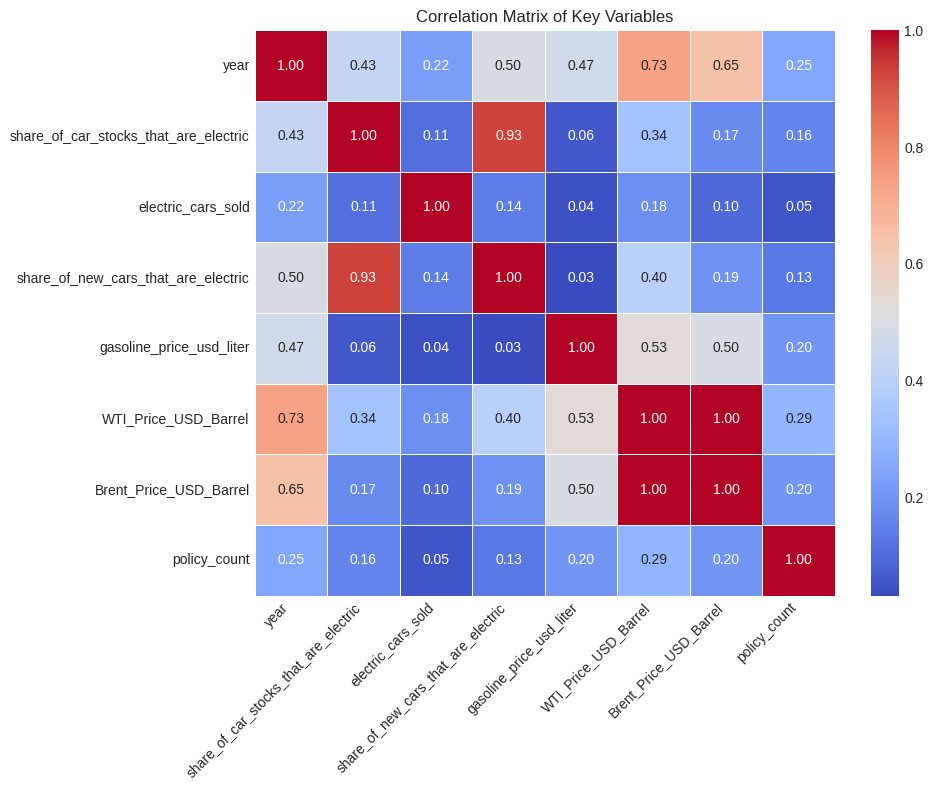

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Define the file path
final_merged_file = 'final_merged_ev_dataset_annual.csv'

print(f"--- Step 5: Initial EDA Visualizations ---")

try:
    # Load the dataset
    df = pd.read_csv(final_merged_file)
    print(f"Loaded {final_merged_file} (Shape: {df.shape})")

    # Set plot style
    plt.style.use('seaborn-v0_8-whitegrid')

    # --- Distributions ---
    print("\n--- Plotting Distributions ---")
    cols_to_plot = [
        'share_of_car_stocks_that_are_electric',
        'electric_cars_sold',
        'share_of_new_cars_that_are_electric',
        'gasoline_price_usd_liter',
        'WTI_Price_USD_Barrel',
        'Brent_Price_USD_Barrel',
        'policy_count'
    ]

    num_cols = len(cols_to_plot)
    fig1, axes1 = plt.subplots(nrows=(num_cols + 1) // 2, ncols=2, figsize=(12, num_cols * 2))
    axes1 = axes1.flatten()

    valid_cols_count = 0
    for i, col in enumerate(cols_to_plot):
        if col in df.columns:
            sns.histplot(df[col], kde=True, ax=axes1[i], bins=30)
            axes1[i].set_title(f'Distribution of {col}', fontsize=10)
            axes1[i].set_xlabel('')
            axes1[i].tick_params(axis='x', rotation=45)
            valid_cols_count += 1
        else:
            print(f"Warning: Column '{col}' not found for plotting distribution.")
            axes1[i].set_visible(False)

    # Hide any unused subplots
    for j in range(valid_cols_count, len(axes1)):
        axes1[j].set_visible(False)

    fig1.suptitle('Distributions of Key Variables', fontsize=14, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout to prevent title overlap


    # --- Correlation Analysis ---
    print("\n--- Plotting Correlation Analysis ---")
    correlation_cols = ['year'] + [col for col in cols_to_plot if col in df.columns]

    if len(correlation_cols) > 1:
        correlation_matrix = df[correlation_cols].corr()

        plt.figure(figsize=(10, 8)) # Create a new figure
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Key Variables')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()

        print("\nCorrelation with 'share_of_new_cars_that_are_electric':")
        if 'share_of_new_cars_that_are_electric' in correlation_matrix.columns:
            print(correlation_matrix['share_of_new_cars_that_are_electric'].sort_values(ascending=False))
        else:
            print("Target column 'share_of_new_cars_that_are_electric' not found in correlation matrix.")
    else:
        print("Not enough numerical columns found to calculate correlations.")

    print("\n--- Initial EDA Plots Generated ---")

except FileNotFoundError:
    print(f"Error: Merged file not found at {final_merged_file}.")
except Exception as e:
    print(f"An error occurred during initial EDA visualization: {e}")

# The plots generated above (distributions, heatmap) will display after this block executes.

# **EV FOCUS**

--- Loading Data for 8 Storytelling Plots ---
Loaded merged data: final_merged_ev_dataset_annual.csv (Shape: (340, 14))
Region mapping added.
Region groups assigned. Counts:
region_group
Rest of World    200
Europe           120
China             10
United States     10
Name: count, dtype: int64

Generating Plot 1: Global EV Sales Volume...

Generating Plot 2: Global EV Market Share %...

Generating Plot 3: Regional EV Market Share % Trends...

Generating Plot 4: Global Powertrain Mix (BEV vs. PHEV %)...

Generating Plot 5: Market Share Leaders Over Time...

Generating Plot 6: Global EV Share % vs. Global Oil Prices...

Generating Plot 7: EV Share % vs. Policy Count...

Generating Plot 8: New Sales Share % vs. Total Fleet Stock %...

--- All 8 Storytelling Plots Generated ---
Plots should display below.


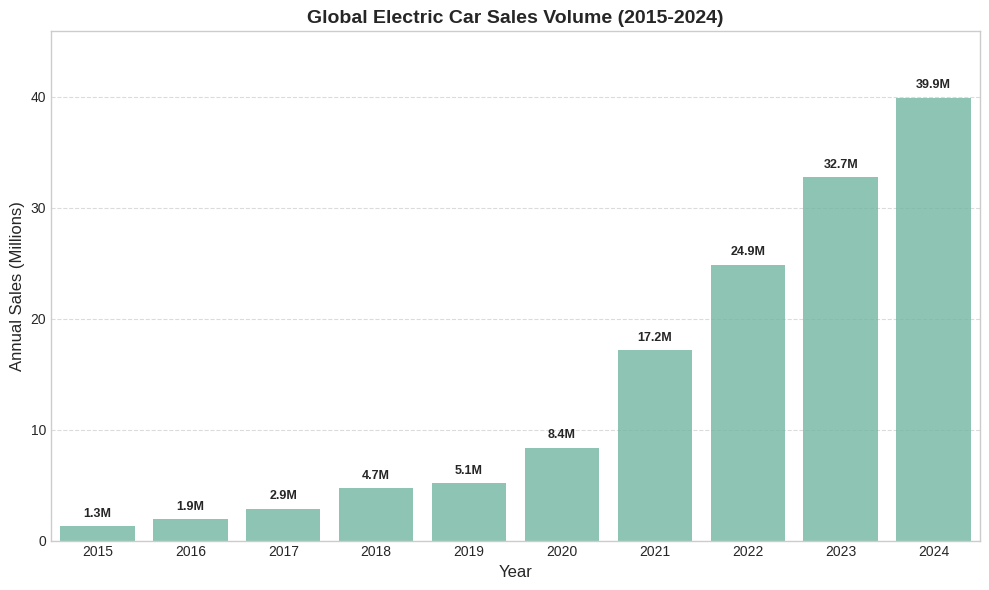

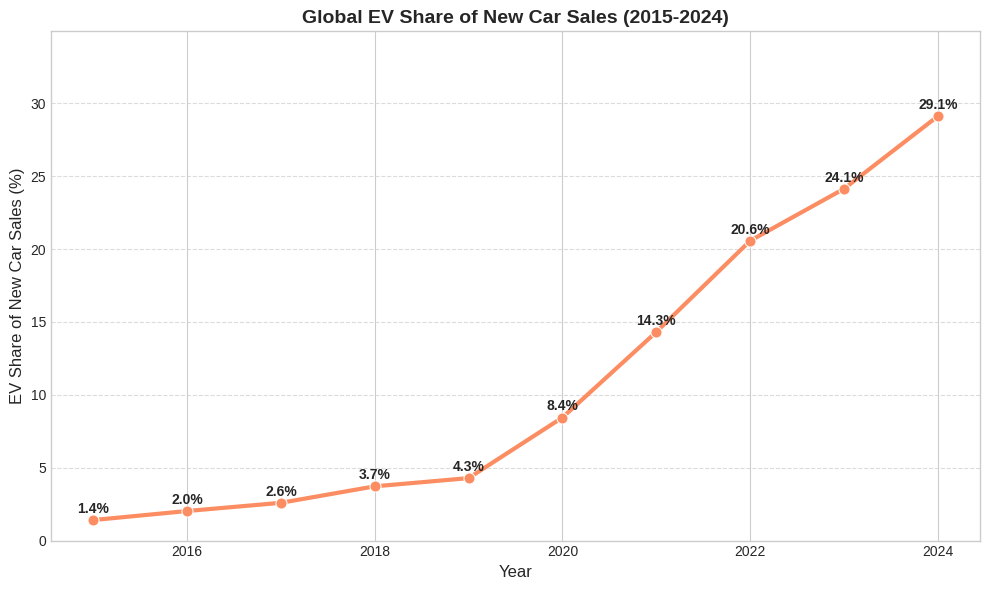

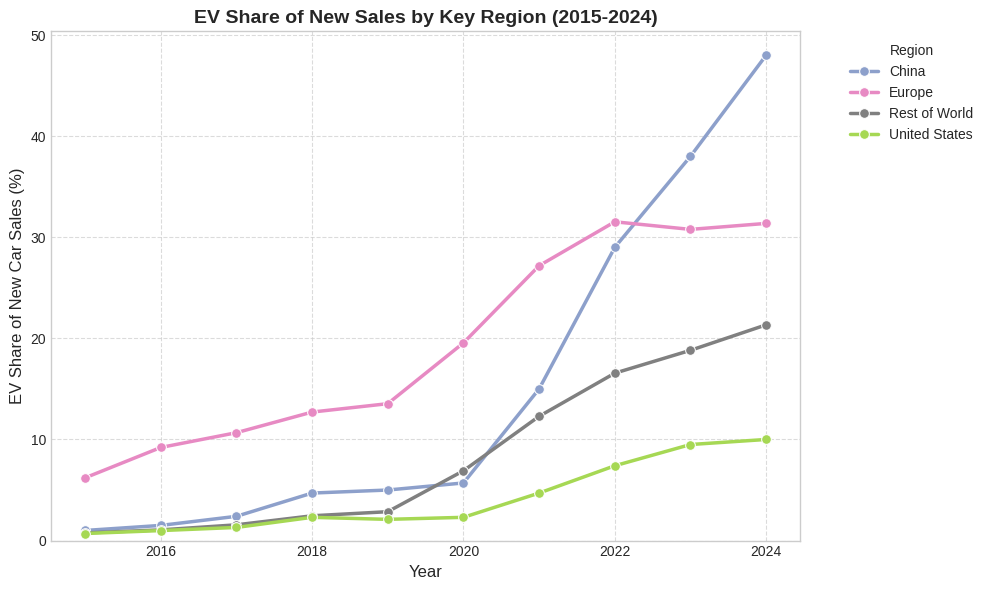

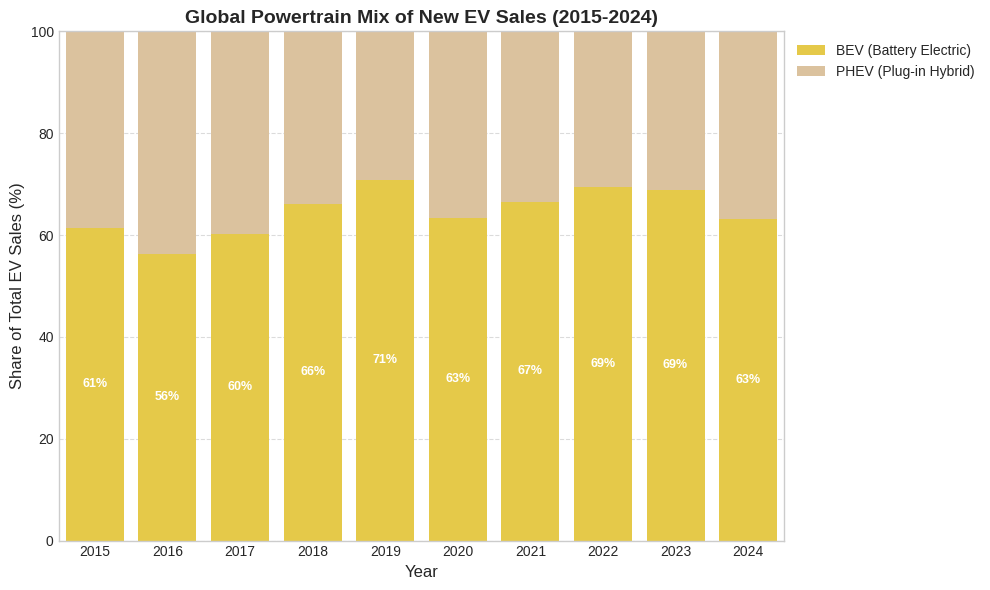

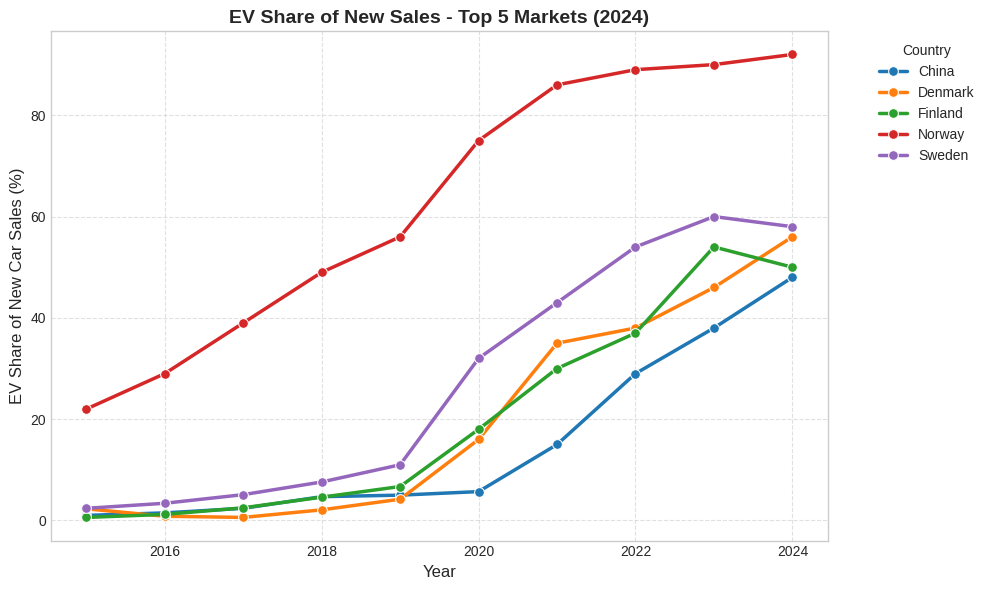

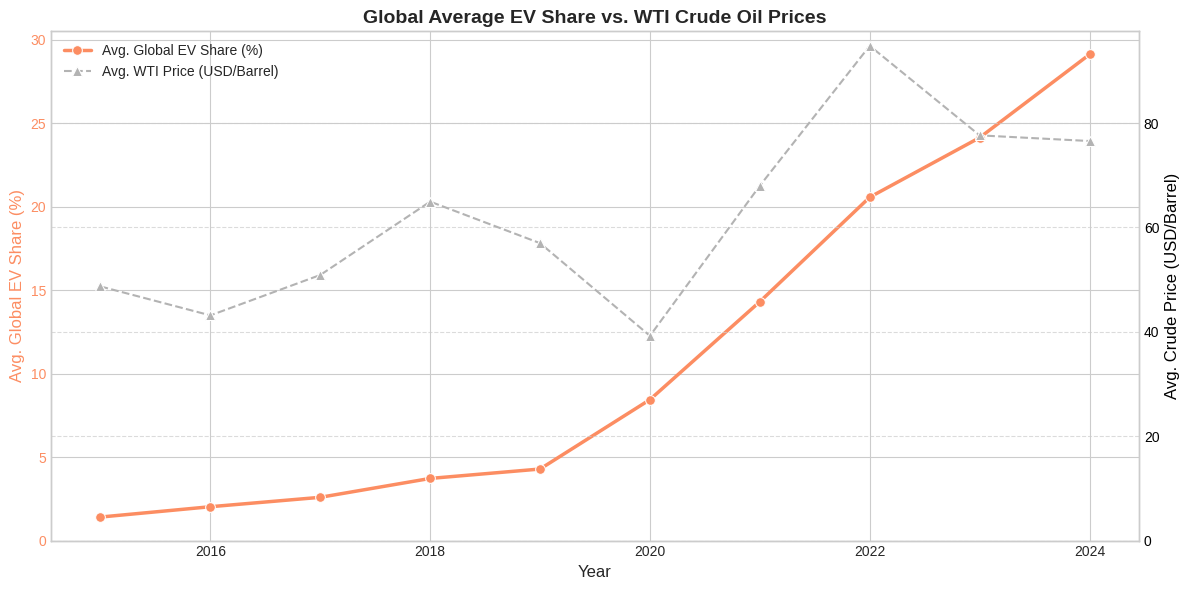

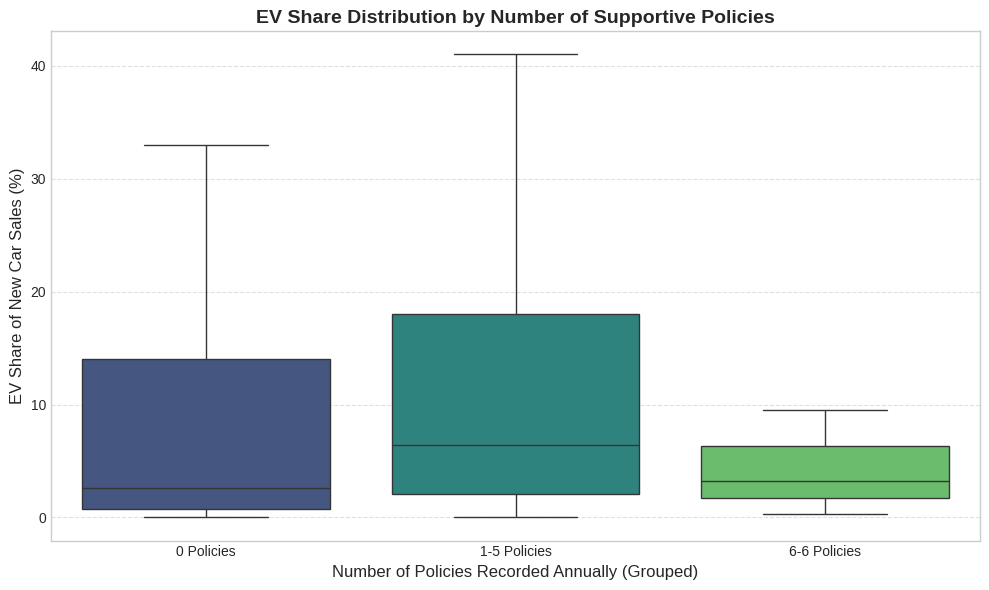

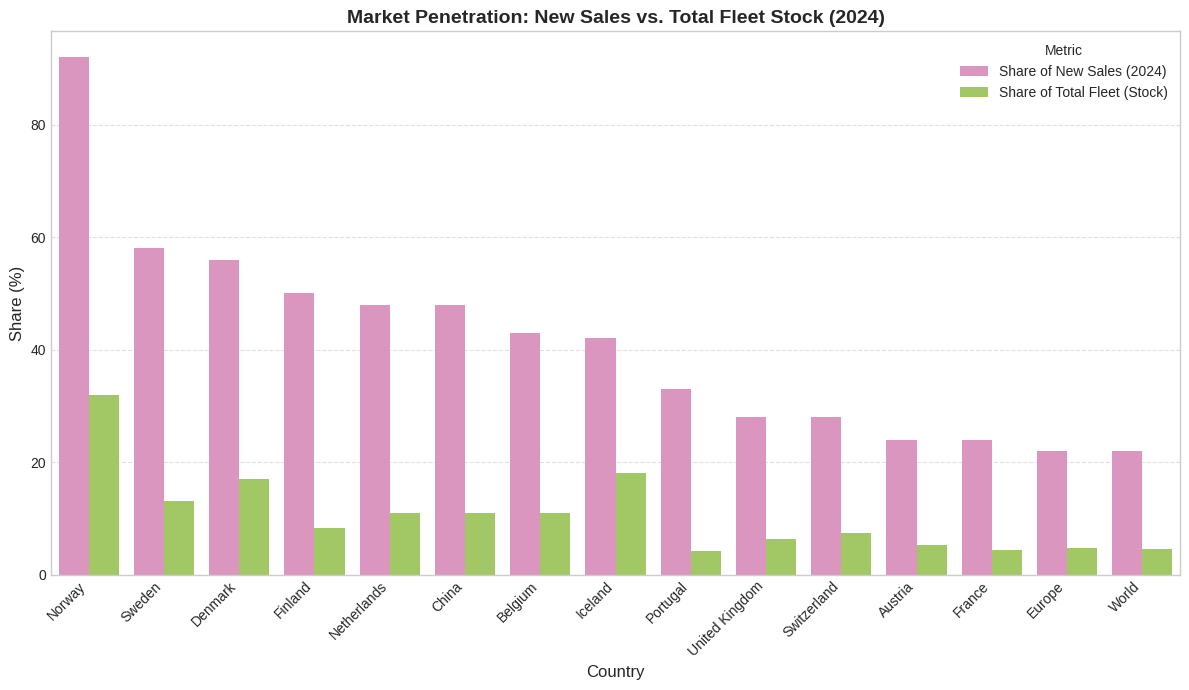

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# --- Setup ---
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
report_palette = sns.color_palette("Set2", 8) # Use a specific palette
final_merged_file = 'final_merged_ev_dataset_annual.csv'
policy_raw_file = 'combined_policy_data_raw.csv' # For region mapping

print(f"--- Loading Data for 8 Storytelling Plots ---")

try:
    # Load the primary merged dataset
    df = pd.read_csv(final_merged_file)
    print(f"Loaded merged data: {final_merged_file} (Shape: {df.shape})")

    # --- Add Region Mapping (Robustly) ---
    try:
        df_policy = pd.read_csv(policy_raw_file)
        df_policy['country'] = df_policy['country'].str.strip()
        country_to_region = df_policy[['country', 'region']].drop_duplicates('country').set_index('country')['region']
        df['region_mapped'] = df['country'].str.strip().map(country_to_region).fillna('Unknown')
        print("Region mapping added.")
    except Exception as e:
        print(f"Warning: Could not add region mapping from {policy_raw_file}: {e}")
        df['region_mapped'] = 'Unknown' # Add column even if mapping fails

    # Create a robust region_group for major markets
    def assign_region_group(row):
        country_strip = str(row.get('country', '')).strip() # Handle potential NaNs
        region_map = str(row.get('region_mapped', 'Unknown')).strip()

        if country_strip == 'China': return 'China'
        if country_strip == 'United States': return 'United States'
        if region_map == 'Europe': return 'Europe'
        # Fallback for key European countries if mapping failed
        if country_strip in ['Germany', 'Norway', 'France', 'United Kingdom', 'Netherlands', 'Sweden', 'Italy', 'Spain']: return 'Europe'
        return 'Rest of World'

    df['region_group'] = df.apply(assign_region_group, axis=1)
    print(f"Region groups assigned. Counts:\n{df['region_group'].value_counts()}")


    latest_year = int(df['year'].max())
    df_latest = df[df['year'] == latest_year].copy()

    # --- Column name definitions ---
    sales_vol_col = 'electric_cars_sold'
    sales_share_col = 'share_of_new_cars_that_are_electric'
    stock_share_col = 'share_of_car_stocks_that_are_electric'
    bev_share_of_ev_col = 'batteryelectric_as_a_share_of_electric_cars_sold'
    gas_col = 'gasoline_price_usd_liter'
    policy_col = 'policy_count'
    wti_col = 'WTI_Price_USD_Barrel'
    brent_col = 'Brent_Price_USD_Barrel'

    # ==========================================================================
    # --- Plot 1: Global EV Sales Volume ---
    # ==========================================================================
    print("\nGenerating Plot 1: Global EV Sales Volume...")
    if sales_vol_col in df.columns:
        df_global_sales = df.groupby('year')[sales_vol_col].sum().reset_index()
        df_global_sales['electric_cars_sold_millions'] = df_global_sales[sales_vol_col] / 1_000_000

        plt.figure(figsize=(10, 6))
        ax = sns.barplot(data=df_global_sales, x='year', y='electric_cars_sold_millions', color=report_palette[0], alpha=0.8)

        # Add labels on top of bars
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.1f}M',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 9),
                        textcoords='offset points',
                        fontsize=9, weight='bold')

        plt.title(f'Global Electric Car Sales Volume (2015-{latest_year})', fontsize=14, weight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Annual Sales (Millions)', fontsize=12)
        plt.ylim(bottom=0, top=df_global_sales['electric_cars_sold_millions'].max() * 1.15)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('story_plot_1_global_sales_volume.png', dpi=300) # Still save for reference
        # plt.clf() # Remove clf to allow display
    else:
        print("Skipping Plot 1: 'electric_cars_sold' not found.")

    # ==========================================================================
    # --- Plot 2: Global EV Market Share % ---
    # ==========================================================================
    print("\nGenerating Plot 2: Global EV Market Share %...")
    if sales_share_col in df.columns and sales_vol_col in df.columns:
        # Calculate weighted global market share
        df_global_share = df.groupby('year').apply(
            lambda x: np.average(x[sales_share_col].fillna(0), weights=x[sales_vol_col].fillna(0)) if x[sales_vol_col].sum() > 0 else 0
        ).reset_index(name='global_ev_share_pct')

        plt.figure(figsize=(10, 6))
        ax = sns.lineplot(data=df_global_share, x='year', y='global_ev_share_pct', marker='o', linewidth=3, color=report_palette[1], markersize=8)

        # Add text labels for key points
        for _, row in df_global_share.iterrows():
            ax.text(row['year'], row['global_ev_share_pct'] + 0.5, f"{row['global_ev_share_pct']:.1f}%",
                    horizontalalignment='center', fontsize=10, weight='bold')

        plt.title(f'Global EV Share of New Car Sales (2015-{latest_year})', fontsize=14, weight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('EV Share of New Car Sales (%)', fontsize=12)
        plt.ylim(bottom=0, top=df_global_share['global_ev_share_pct'].max() * 1.2)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('story_plot_2_global_sales_share.png', dpi=300)
        # plt.clf() # Remove clf
    else:
        print("Skipping Plot 2: Required columns for market share not found.")

    # ==========================================================================
    # --- Plot 3: Regional EV Market Share % Trends ---
    # ==========================================================================
    print("\nGenerating Plot 3: Regional EV Market Share % Trends...")
    if sales_share_col in df.columns and sales_vol_col in df.columns and 'region_group' in df.columns:
        # Calculate weighted regional market share
        df_regional_share = df.groupby(['year', 'region_group']).apply(
             lambda x: np.average(x[sales_share_col].fillna(0), weights=x[sales_vol_col].fillna(0)) if x[sales_vol_col].sum() > 0 else 0
        ).reset_index(name='regional_ev_share_pct')

        # Filter out "Rest of World" if needed for clarity, or keep it
        # df_regional_share_plot = df_regional_share[df_regional_share['region_group'] != 'Rest of World']
        df_regional_share_plot = df_regional_share

        region_palette = {'China': report_palette[2], 'Europe': report_palette[3], 'United States': report_palette[4], 'Rest of World': 'grey'}

        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df_regional_share_plot, x='year', y='regional_ev_share_pct',
                     hue='region_group', palette=region_palette,
                     marker='o', linewidth=2.5, markersize=7)

        plt.title(f'EV Share of New Sales by Key Region (2015-{latest_year})', fontsize=14, weight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('EV Share of New Car Sales (%)', fontsize=12)
        plt.ylim(bottom=0)
        plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('story_plot_3_regional_sales_share.png', dpi=300)
        # plt.clf() # Remove clf
    else:
        print("Skipping Plot 3: Required columns or region group not found.")


    # ==========================================================================
    # --- Plot 4: Global Powertrain Mix (BEV vs. PHEV %) ---
    # ==========================================================================
    print("\nGenerating Plot 4: Global Powertrain Mix (BEV vs. PHEV %)...")
    if sales_vol_col in df.columns and bev_share_of_ev_col in df.columns:
        # Calculate global BEV and PHEV sales accurately handling NaNs
        df['bev_sales'] = df[sales_vol_col] * (df[bev_share_of_ev_col].fillna(0) / 100.0) # Assume 0% BEV if share is NaN
        df['phev_sales'] = df[sales_vol_col] - df['bev_sales']
        df.loc[df[sales_vol_col] == 0, ['bev_sales', 'phev_sales']] = 0 # Ensure 0 if total is 0

        df_powertrain = df.groupby('year')[['bev_sales', 'phev_sales']].sum().reset_index()
        df_powertrain['total_sales'] = df_powertrain['bev_sales'] + df_powertrain['phev_sales']

        # Avoid division by zero
        df_powertrain['bev_pct'] = np.where(df_powertrain['total_sales'] > 0, (df_powertrain['bev_sales'] / df_powertrain['total_sales']) * 100, 0)
        df_powertrain['phev_pct'] = np.where(df_powertrain['total_sales'] > 0, (df_powertrain['phev_sales'] / df_powertrain['total_sales']) * 100, 0)

        plt.figure(figsize=(10, 6))

        # Bottom bar (BEV)
        sns.barplot(data=df_powertrain, x='year', y='bev_pct', color=report_palette[5], label='BEV (Battery Electric)')
        # Top bar (PHEV)
        sns.barplot(data=df_powertrain, x='year', y='phev_pct', bottom=df_powertrain['bev_pct'], color=report_palette[6], label='PHEV (Plug-in Hybrid)')

        # Add labels for BEV share
        ax = plt.gca()
        for p in ax.patches:
             if p.get_y() == 0 and p.get_height() > 5: # Bottom bar, significant height
                 ax.annotate(f'{p.get_height():.0f}%',
                            (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                            ha='center', va='center',
                            fontsize=9, weight='bold', color='white')

        plt.title(f'Global Powertrain Mix of New EV Sales (2015-{latest_year})', fontsize=14, weight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Share of Total EV Sales (%)', fontsize=12)
        plt.ylim(0, 100)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(False, axis='x')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('story_plot_4_bev_vs_phev_mix.png', dpi=300)
        # plt.clf() # Remove clf
    else:
        print("Skipping Plot 4: Required columns for powertrain mix not found.")


    # ==========================================================================
    # --- Plot 5: Market Share Leaders Over Time ---
    # ==========================================================================
    print("\nGenerating Plot 5: Market Share Leaders Over Time...")
    if sales_share_col in df.columns:
        # Find top 5 countries by share in the latest year dynamically
        top_5_countries = df_latest.nlargest(5, sales_share_col)['country'].tolist()
        df_top5_trend = df[df['country'].isin(top_5_countries)]

        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df_top5_trend, x='year', y=sales_share_col, hue='country',
                     marker='o', linewidth=2.5, palette='tab10', markersize=7) # Use a distinct palette

        plt.title(f'EV Share of New Sales - Top 5 Markets ({latest_year})', fontsize=14, weight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('EV Share of New Car Sales (%)', fontsize=12)
        plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig('story_plot_5_market_share_leaders.png', dpi=300)
        # plt.clf() # Remove clf
    else:
        print("Skipping Plot 5: 'share_of_new_cars_that_are_electric' not found.")

    # ==========================================================================
    # --- Plot 6: Global EV Share % vs. Global Oil Prices ---
    # ==========================================================================
    print("\nGenerating Plot 6: Global EV Share % vs. Global Oil Prices...")
    if sales_share_col in df.columns and sales_vol_col in df.columns and wti_col in df.columns and brent_col in df.columns:
        # Calculate global weighted EV share (same as plot 2)
        df_global_share = df.groupby('year').apply(
            lambda x: np.average(x[sales_share_col].fillna(0), weights=x[sales_vol_col].fillna(0)) if x[sales_vol_col].sum() > 0 else 0
        ).reset_index(name='global_ev_share_pct')

        # Calculate global average oil prices
        df_global_oil = df.groupby('year')[[wti_col, brent_col]].mean().reset_index()

        # Merge them
        df_global_trends = pd.merge(df_global_share, df_global_oil, on='year', how='inner')

        plt.figure(figsize=(12, 6))
        ax1 = plt.gca()

        # Plot EV Share
        sns.lineplot(data=df_global_trends, x='year', y='global_ev_share_pct', marker='o', ax=ax1, color=report_palette[1], label='Avg. Global EV Share (%)', linewidth=2.5, markersize=7)
        ax1.set_ylabel('Avg. Global EV Share (%)', color=report_palette[1], fontsize=12)
        ax1.tick_params(axis='y', labelcolor=report_palette[1])
        ax1.set_xlabel('Year', fontsize=12)
        ax1.set_ylim(bottom=0)

        # Plot Oil Prices on secondary axis
        ax2 = ax1.twinx()
        sns.lineplot(data=df_global_trends, x='year', y=wti_col, marker='^', ax=ax2, color=report_palette[7], label='Avg. WTI Price (USD/Barrel)', linestyle='--', markersize=7)
        # Optionally add Brent
        # sns.lineplot(data=df_global_trends, x='year', y=brent_col, marker='s', ax=ax2, color='purple', label='Avg. Brent Price (USD/Barrel)', linestyle=':', markersize=7)
        ax2.set_ylabel('Avg. Crude Price (USD/Barrel)', color='black', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='black')
        ax2.set_ylim(bottom=0)

        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        ax1.get_legend().remove() # Remove original legend from ax1

        plt.title('Global Average EV Share vs. WTI Crude Oil Prices', fontsize=14, weight='bold')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('story_plot_6_share_vs_oil_prices.png', dpi=300)
        # plt.clf() # Remove clf
    else:
        print("Skipping Plot 6: Missing required columns for EV share or oil prices.")

    # ==========================================================================
    # --- Plot 7: EV Share % vs. Policy Count ---
    # ==========================================================================
    print("\nGenerating Plot 7: EV Share % vs. Policy Count...")
    if sales_share_col in df.columns and policy_col in df.columns:
        # Using the dynamic policy groups from before
        max_policies = int(df[policy_col].max())
        if max_policies <= 5:
            bins = [-1, 0, max_policies]; labels = ['0 Policies', f'1-{max_policies} Policies']
        elif max_policies <= 10:
            bins = [-1, 0, 5, max_policies]; labels = ['0 Policies', '1-5 Policies', f'6-{max_policies} Policies']
        else:
            bins = [-1, 0, 5, 10, max_policies]; labels = ['0 Policies', '1-5 Policies', '6-10 Policies', '11+ Policies']

        df['policy_group'] = pd.cut(df[policy_col], bins=bins, labels=labels, right=True)

        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df.dropna(subset=['policy_group']),
                    x='policy_group', y=sales_share_col,
                    palette='viridis', showfliers=False,
                    order=labels)

        plt.title('EV Share Distribution by Number of Supportive Policies', fontsize=14, weight='bold')
        plt.xlabel('Number of Policies Recorded Annually (Grouped)', fontsize=12)
        plt.ylabel('EV Share of New Car Sales (%)', fontsize=12)
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig('story_plot_7_share_vs_policy.png', dpi=300)
        # plt.clf() # Remove clf
    else:
        print("Skipping Plot 7: Missing EV share or policy count columns.")


    # ==========================================================================
    # --- Plot 8: New Sales Share % vs. Total Fleet Stock % ---
    # ==========================================================================
    print("\nGenerating Plot 8: New Sales Share % vs. Total Fleet Stock %...")
    if sales_share_col in df.columns and stock_share_col in df.columns:
        # Select top 15 countries by NEW sales share
        countries_for_stock = df_latest.nlargest(15, sales_share_col)['country'].tolist()
        df_stock_comp = df_latest[df_latest['country'].isin(countries_for_stock)].copy()

        # Melt dataframe for easier plotting with dodged bars
        df_stock_melted = df_stock_comp.melt(id_vars='country',
                                             value_vars=[sales_share_col, stock_share_col],
                                             var_name='Share Type',
                                             value_name='Share (%)').dropna(subset=['Share (%)']) # Drop if stock share is NaN

        df_stock_melted['Share Type'] = df_stock_melted['Share Type'].map({
            sales_share_col: f'Share of New Sales ({latest_year})',
            stock_share_col: 'Share of Total Fleet (Stock)'
        })

        # Sort countries by new sales share for a clean plot
        country_order = df_latest[df_latest['country'].isin(countries_for_stock)].sort_values(sales_share_col, ascending=False)['country']

        plt.figure(figsize=(12, 7))
        sns.barplot(data=df_stock_melted, x='country', y='Share (%)', hue='Share Type',
                    palette=[report_palette[3], report_palette[4]], # Use distinct colors
                    order=country_order)

        plt.title(f'Market Penetration: New Sales vs. Total Fleet Stock ({latest_year})', fontsize=14, weight='bold')
        plt.xlabel('Country', fontsize=12)
        plt.ylabel('Share (%)', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Metric')
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig('story_plot_8_sales_vs_stock.png', dpi=300)
        # plt.clf() # Remove clf
    else:
        print("Skipping Plot 8: Required stock/sales share columns not found.")

    print("\n--- All 8 Storytelling Plots Generated ---")
    print("Plots should display below.")

except FileNotFoundError:
    print(f"Error: Required data file not found. Please ensure '{final_merged_file}' and '{policy_raw_file}' exist.")
except KeyError as ke:
    print(f"Error: A required column was not found. Check column names. Details: {ke}")
except Exception as e:
    print(f"An error occurred during visualization: {e}")

--- Loading Data for 8 Refined Storytelling Plots ---
Loaded merged data: final_merged_ev_dataset_annual.csv (Shape: (340, 14))
Region mapping added.
Region groups assigned.
Plots will cover 2015 to 2024.

Generating Plot 1: Global EV Sales Volume...


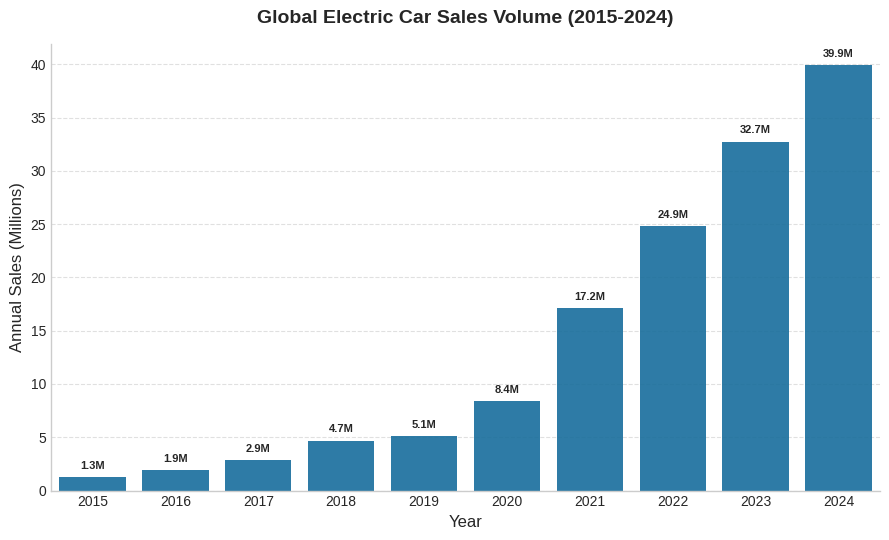


Generating Plot 2: Global EV Market Share %...


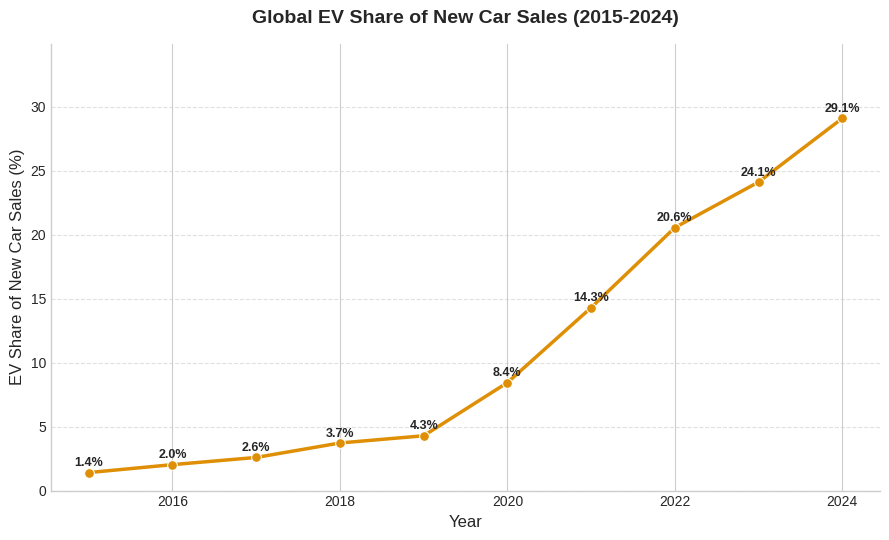


Generating Plot 3: Regional EV Market Share % Trends...


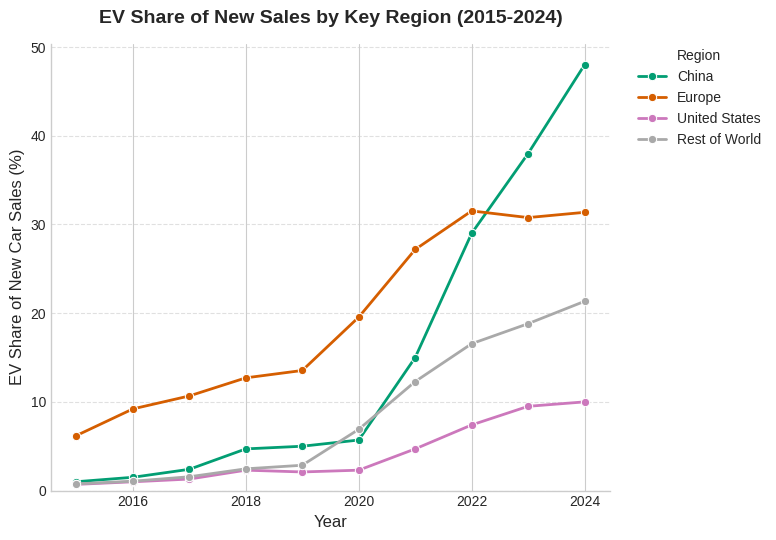


Generating Plot 4: Global Powertrain Mix (BEV vs. PHEV %)...


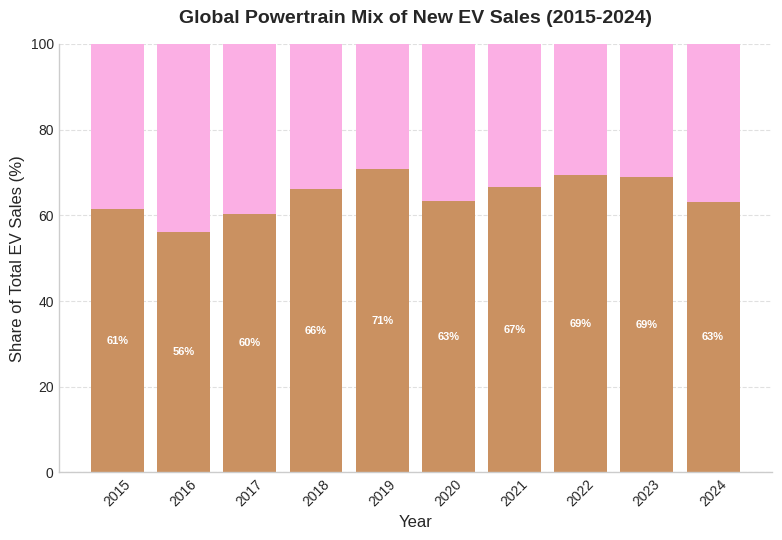


Generating Plot 5: Market Share Leaders Over Time...


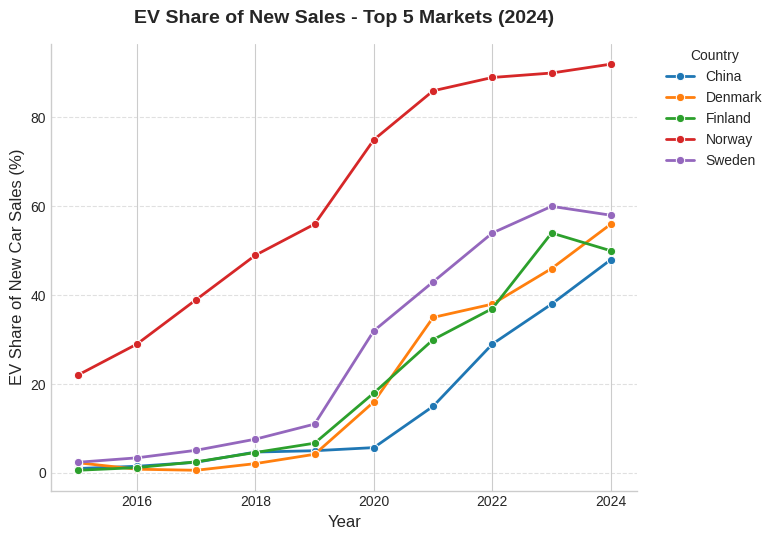


Generating Plot 6: Global EV Share % vs. Global Oil Prices...


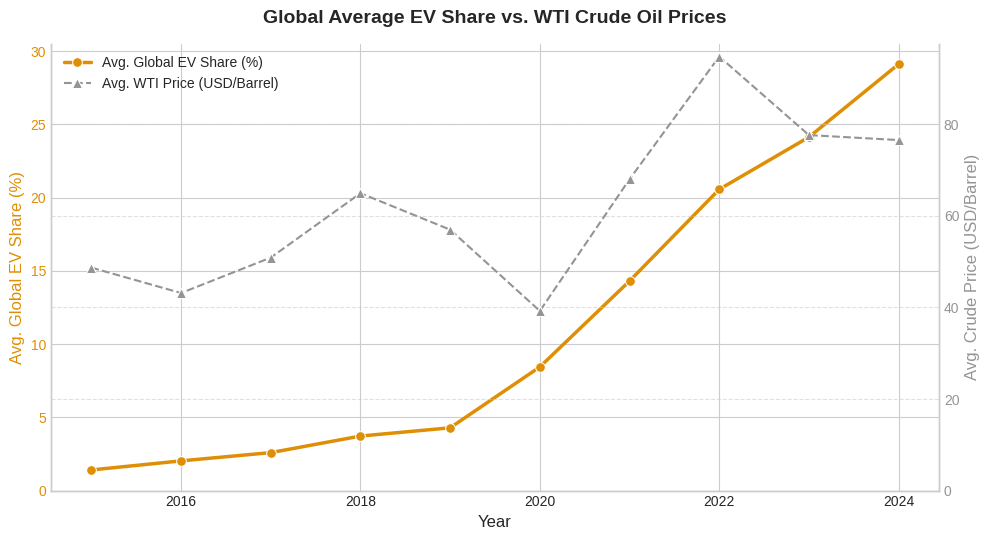


Generating Plot 7: EV Share % vs. Policy Count...


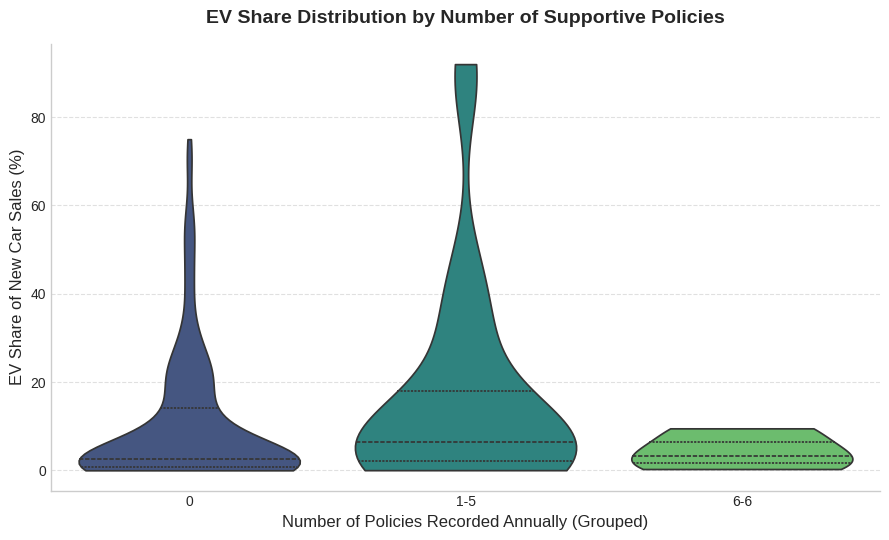


Generating Plot 8: New Sales Share % vs. Total Fleet Stock %...


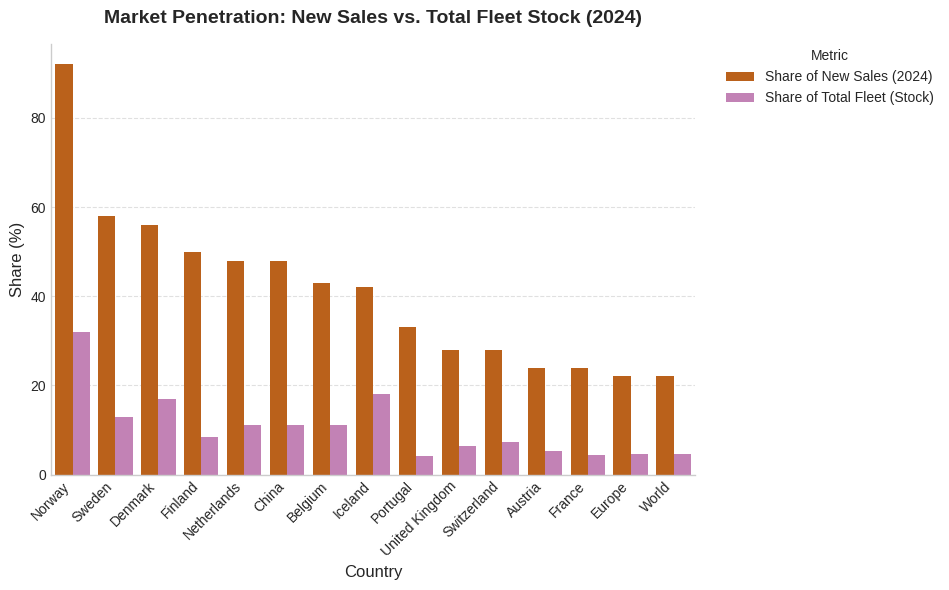


--- All 8 Refined Storytelling Plots Generated ---
Plots should be displayed above.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# --- Setup ---
warnings.filterwarnings('ignore') # Suppress warnings
plt.style.use('seaborn-v0_8-whitegrid') # Use a clean plot style
# Define a color palette suitable for reports
report_palette = sns.color_palette("colorblind", 10)
# Define file paths
final_merged_file = 'final_merged_ev_dataset_annual.csv'
policy_raw_file = 'combined_policy_data_raw.csv' # Needed for region mapping

print(f"--- Loading Data for 8 Refined Storytelling Plots ---")

try:
    # --- Load and Prepare Data ---
    if not os.path.exists(final_merged_file):
        print(f"Error: '{final_merged_file}' not found. Please ensure the data merging step ran.")
        raise FileNotFoundError(f"'{final_merged_file}' is required.")
    df = pd.read_csv(final_merged_file)
    print(f"Loaded merged data: {final_merged_file} (Shape: {df.shape})")

    # Add Region Mapping
    try:
        if not os.path.exists(policy_raw_file):
            print(f"Warning: Policy file '{policy_raw_file}' not found. Cannot add detailed region mapping.")
            df['region_mapped'] = 'Unknown'
        else:
            df_policy = pd.read_csv(policy_raw_file)
            df_policy['country'] = df_policy['country'].str.strip()
            country_to_region = df_policy.drop_duplicates(subset=['country'], keep='first').set_index('country')['region']
            df['region_mapped'] = df['country'].str.strip().map(country_to_region).fillna('Unknown')
            print("Region mapping added.")
    except Exception as e:
        print(f"Warning: Could not add region mapping: {e}")
        df['region_mapped'] = 'Unknown'

    def assign_region_group(row): # Assign major regions
        country_strip = str(row.get('country', '')).strip()
        region_map = str(row.get('region_mapped', 'Unknown')).strip()
        if country_strip == 'China': return 'China'
        if country_strip == 'United States': return 'United States'
        if region_map == 'Europe': return 'Europe'
        if country_strip in ['Germany', 'Norway', 'France', 'United Kingdom', 'Netherlands', 'Sweden', 'Italy', 'Spain']: return 'Europe'
        return 'Rest of World'
    df['region_group'] = df.apply(assign_region_group, axis=1)
    print(f"Region groups assigned.")

    # Determine year range
    min_year_data = int(df['year'].min())
    max_year_data = int(df['year'].max())
    start_year_plot = max(2010, min_year_data)
    end_year_plot = min(2024, max_year_data)
    print(f"Plots will cover {start_year_plot} to {end_year_plot}.")

    df_plot_range = df[(df['year'] >= start_year_plot) & (df['year'] <= end_year_plot)].copy()
    latest_year = end_year_plot
    df_latest = df[df['year'] == latest_year].copy()

    # Define consistent region colors
    region_palette = {'China': report_palette[2], 'Europe': report_palette[3], 'United States': report_palette[4], 'Rest of World': 'darkgrey'} # Use darkgrey for Rest

    # Define column names
    sales_vol_col = 'electric_cars_sold'
    sales_share_col = 'share_of_new_cars_that_are_electric'
    stock_share_col = 'share_of_car_stocks_that_are_electric'
    bev_share_of_ev_col = 'batteryelectric_as_a_share_of_electric_cars_sold'
    policy_col = 'policy_count'
    wti_col = 'WTI_Price_USD_Barrel'

    # --- Plotting Function ---
    # Helper to ensure plots are shown correctly one after another
    def finalize_plot(title_str, xlabel_str, ylabel_str, filename_suffix, legend_outside=False, legend_title=None):
        plt.title(title_str, fontsize=14, weight='bold', pad=15) # Add padding
        plt.xlabel(xlabel_str, fontsize=12)
        plt.ylabel(ylabel_str, fontsize=12)
        plt.grid(True, axis='y', linestyle='--', alpha=0.6) # Lighter grid
        sns.despine() # Remove top/right spines

        ax = plt.gca()
        if ax.get_legend() is not None:
             if legend_outside:
                  # Adjust bbox_to_anchor to ensure visibility, slightly further out
                  plt.legend(title=legend_title, bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.)
             else:
                  plt.legend(title=legend_title) # Default placement inside

        plt.tight_layout(rect=[0, 0, 0.88 if legend_outside else 1, 1]) # Adjust layout rect if legend is outside
        # plt.savefig(f'refined_{filename_suffix}.png', dpi=300, bbox_inches='tight') # Optional save
        plt.show() # Display the plot

    # ==========================================================================
    # --- Plot 1: Global EV Sales Volume ---
    # ==========================================================================
    print("\nGenerating Plot 1: Global EV Sales Volume...")
    if sales_vol_col in df_plot_range.columns:
        df_global_sales = df_plot_range.groupby('year')[sales_vol_col].sum().reset_index()
        df_global_sales['electric_cars_sold_millions'] = df_global_sales[sales_vol_col] / 1_000_000

        plt.figure(figsize=(9, 5.5)) # Slightly adjusted size
        ax = sns.barplot(data=df_global_sales, x='year', y='electric_cars_sold_millions', color=report_palette[0], alpha=0.9)
        for p in ax.patches: # Add labels
            if p.get_height() > 0.1: # Threshold for label visibility
                ax.annotate(f'{p.get_height():.1f}M', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 8), textcoords='offset points', fontsize=8, weight='bold')

        finalize_plot(f'Global Electric Car Sales Volume ({start_year_plot}-{end_year_plot})',
                      'Year', 'Annual Sales (Millions)', 'plot_1_global_sales_vol')
    else: print("Skipping Plot 1: 'electric_cars_sold' not found.")

    # ==========================================================================
    # --- Plot 2: Global EV Market Share % ---
    # ==========================================================================
    print("\nGenerating Plot 2: Global EV Market Share %...")
    if sales_share_col in df_plot_range.columns and sales_vol_col in df_plot_range.columns:
        df_global_share = df_plot_range.groupby('year').apply(lambda x: np.average(x[sales_share_col].fillna(0), weights=x[sales_vol_col].fillna(0)) if x[sales_vol_col].sum(skipna=True) > 0 else 0).reset_index(name='global_ev_share_pct')
        plt.figure(figsize=(9, 5.5))
        ax = sns.lineplot(data=df_global_share, x='year', y='global_ev_share_pct', marker='o', linewidth=2.5, color=report_palette[1], markersize=7) # Slightly thinner line
        for _, row in df_global_share.iterrows(): ax.text(row['year'], row['global_ev_share_pct'] + 0.5, f"{row['global_ev_share_pct']:.1f}%", horizontalalignment='center', fontsize=9, weight='bold') # Smaller font
        plt.ylim(bottom=0, top=max(10, df_global_share['global_ev_share_pct'].max() * 1.2))
        finalize_plot(f'Global EV Share of New Car Sales ({start_year_plot}-{end_year_plot})',
                      'Year', 'EV Share of New Car Sales (%)', 'plot_2_global_sales_share')
    else: print("Skipping Plot 2: Required columns not found.")

    # ==========================================================================
    # --- Plot 3: Regional EV Market Share % Trends ---
    # ==========================================================================
    print("\nGenerating Plot 3: Regional EV Market Share % Trends...")
    if sales_share_col in df_plot_range.columns and sales_vol_col in df_plot_range.columns and 'region_group' in df_plot_range.columns:
        df_regional_share = df_plot_range.groupby(['year', 'region_group']).apply( lambda x: np.average(x[sales_share_col].fillna(0), weights=x[sales_vol_col].fillna(0)) if x[sales_vol_col].sum(skipna=True) > 0 else 0 ).reset_index(name='regional_ev_share_pct')
        plt.figure(figsize=(9, 5.5))
        sns.lineplot(data=df_regional_share, x='year', y='regional_ev_share_pct', hue='region_group', palette=region_palette, hue_order=['China', 'Europe', 'United States', 'Rest of World'], marker='o', linewidth=2, markersize=6) # Thinner lines
        plt.ylim(bottom=0)
        finalize_plot(f'EV Share of New Sales by Key Region ({start_year_plot}-{end_year_plot})',
                      'Year', 'EV Share of New Car Sales (%)', 'plot_3_regional_share', legend_outside=True, legend_title='Region')
    else: print("Skipping Plot 3: Required columns or region group not found.")

    # ==========================================================================
    # --- Plot 4: Global Powertrain Mix (BEV vs. PHEV %) ---
    # ==========================================================================
    print("\nGenerating Plot 4: Global Powertrain Mix (BEV vs. PHEV %)...")
    if sales_vol_col in df_plot_range.columns and bev_share_of_ev_col in df_plot_range.columns:
        df_plot_range['bev_sales'] = df_plot_range[sales_vol_col].fillna(0) * (df_plot_range[bev_share_of_ev_col].fillna(0) / 100.0)
        df_plot_range['phev_sales'] = df_plot_range[sales_vol_col].fillna(0) - df_plot_range['bev_sales']
        df_plot_range['phev_sales'] = df_plot_range['phev_sales'].clip(lower=0)
        df_plot_range.loc[df_plot_range[sales_vol_col].fillna(0) <= 0, ['bev_sales', 'phev_sales']] = 0
        df_powertrain = df_plot_range.groupby('year')[['bev_sales', 'phev_sales']].sum().reset_index()
        df_powertrain['total_sales'] = df_powertrain['bev_sales'] + df_powertrain['phev_sales']
        df_powertrain['bev_pct'] = np.where(df_powertrain['total_sales'] > 0, (df_powertrain['bev_sales'] / df_powertrain['total_sales']) * 100, 0)
        df_powertrain['phev_pct'] = np.where(df_powertrain['total_sales'] > 0, (df_powertrain['phev_sales'] / df_powertrain['total_sales']) * 100, 0)

        plt.figure(figsize=(9, 5.5))
        # Stacked bar chart
        plt.bar(df_powertrain['year'], df_powertrain['bev_pct'], color=report_palette[5], label='BEV (Battery Electric)')
        plt.bar(df_powertrain['year'], df_powertrain['phev_pct'], bottom=df_powertrain['bev_pct'], color=report_palette[6], label='PHEV (Plug-in Hybrid)')
        ax = plt.gca() # Add labels
        for i, year in enumerate(df_powertrain['year']):
             bev_height = df_powertrain.loc[i, 'bev_pct']
             if bev_height > 8: ax.text(year, bev_height / 2, f'{bev_height:.0f}%', ha='center', va='center', fontsize=8, weight='bold', color='white') # Use year on x-axis for positioning
        plt.ylim(0, 100)
        plt.xticks(df_powertrain['year'], rotation=45) # Ensure years are labeled correctly
        plt.grid(False, axis='x')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        finalize_plot(f'Global Powertrain Mix of New EV Sales ({start_year_plot}-{end_year_plot})',
                      'Year', 'Share of Total EV Sales (%)', 'plot_4_powertrain_mix', legend_outside=True)
    else: print("Skipping Plot 4: Required columns not found.")

    # ==========================================================================
    # --- Plot 5: Market Share Leaders Over Time ---
    # ==========================================================================
    print("\nGenerating Plot 5: Market Share Leaders Over Time...")
    if sales_share_col in df_plot_range.columns and not df_latest.empty:
        top_countries = df_latest.nlargest(5, sales_share_col)['country'].tolist()
        df_top_trend = df_plot_range[df_plot_range['country'].isin(top_countries)]
        plt.figure(figsize=(9, 5.5))
        sns.lineplot(data=df_top_trend, x='year', y=sales_share_col, hue='country', marker='o', linewidth=2, palette='tab10', markersize=6) # tab10 is good for lines
        finalize_plot(f'EV Share of New Sales - Top 5 Markets ({latest_year})',
                      'Year', 'EV Share of New Car Sales (%)', 'plot_5_leaders', legend_outside=True, legend_title='Country')
    elif df_latest.empty: print(f"Skipping Plot 5: No data for {latest_year}.")
    else: print("Skipping Plot 5: Required columns not found.")

    # ==========================================================================
    # --- Plot 6: Global EV Share % vs. Global Oil Prices ---
    # ==========================================================================
    print("\nGenerating Plot 6: Global EV Share % vs. Global Oil Prices...")
    if sales_share_col in df_plot_range.columns and sales_vol_col in df_plot_range.columns and wti_col in df_plot_range.columns:
        df_global_share = df_plot_range.groupby('year').apply(lambda x: np.average(x[sales_share_col].fillna(0), weights=x[sales_vol_col].fillna(0)) if x[sales_vol_col].sum(skipna=True) > 0 else 0).reset_index(name='global_ev_share_pct')
        df_global_oil = df_plot_range.groupby('year')[[wti_col]].mean().reset_index()
        df_global_trends = pd.merge(df_global_share, df_global_oil, on='year', how='inner')
        fig, ax1 = plt.subplots(figsize=(10, 5.5)) # Explicitly create fig and ax1
        ln1 = sns.lineplot(data=df_global_trends, x='year', y='global_ev_share_pct', marker='o', ax=ax1, color=report_palette[1], label='Avg. Global EV Share (%)', linewidth=2.5, markersize=7)
        ax1.set_ylabel('Avg. Global EV Share (%)', color=report_palette[1], fontsize=12); ax1.tick_params(axis='y', labelcolor=report_palette[1]); ax1.set_xlabel('Year', fontsize=12); ax1.set_ylim(bottom=0)
        ax2 = ax1.twinx()
        ln2 = sns.lineplot(data=df_global_trends, x='year', y=wti_col, marker='^', ax=ax2, color=report_palette[7], label='Avg. WTI Price (USD/Barrel)', linestyle='--', markersize=7)
        ax2.set_ylabel('Avg. Crude Price (USD/Barrel)', color=report_palette[7], fontsize=12); ax2.tick_params(axis='y', labelcolor=report_palette[7]); ax2.set_ylim(bottom=0)
        h1, l1 = ax1.get_legend_handles_labels(); h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc='upper left'); ax2.get_legend().remove()
        plt.title('Global Average EV Share vs. WTI Crude Oil Prices', fontsize=14, weight='bold', pad=15)
        plt.grid(True, linestyle='--', alpha=0.6); sns.despine(right=False) # Keep right spine
        fig.tight_layout() # Use fig.tight_layout()
        plt.show() # Display the plot
    else: print("Skipping Plot 6: Missing required columns.")

    # ==========================================================================
    # --- Plot 7: EV Share % vs. Policy Count ---
    # ==========================================================================
    print("\nGenerating Plot 7: EV Share % vs. Policy Count...")
    if sales_share_col in df_plot_range.columns and policy_col in df_plot_range.columns:
        df_plot_range_policy = df_plot_range.dropna(subset=[policy_col])
        if not df_plot_range_policy.empty:
             max_policies = int(df_plot_range_policy[policy_col].max())
             if max_policies <= 0: print("Skipping Plot 7: No policy data > 0 found.")
             else:
                if max_policies <= 5: bins = [-1, 0, max_policies]; labels = ['0', f'1-{max_policies}']
                elif max_policies <= 10: bins = [-1, 0, 5, max_policies]; labels = ['0', '1-5', f'6-{max_policies}']
                else: bins = [-1, 0, 5, 10, max_policies]; labels = ['0', '1-5', '6-10', '11+']
                df_plot_range['policy_group'] = pd.cut(df_plot_range[policy_col], bins=bins, labels=labels, right=True)
                plt.figure(figsize=(9, 5.5))
                sns.violinplot(data=df_plot_range.dropna(subset=['policy_group']), x='policy_group', y=sales_share_col, palette='viridis', inner='quartile', order=labels, cut=0) # cut=0 prevents tails going below 0
                finalize_plot('EV Share Distribution by Number of Supportive Policies',
                              'Number of Policies Recorded Annually (Grouped)', 'EV Share of New Car Sales (%)', 'plot_7_policy_violin')
        else: print("Skipping Plot 7: No policy data found after dropping NaNs.")
    else: print("Skipping Plot 7: Missing required columns.")

    # ==========================================================================
    # --- Plot 8: New Sales Share % vs. Total Fleet Stock % ---
    # ==========================================================================
    print("\nGenerating Plot 8: New Sales Share % vs. Total Fleet Stock %...")
    if sales_share_col in df.columns and stock_share_col in df.columns and not df_latest.empty:
        countries_for_stock = df_latest.nlargest(15, sales_share_col)['country'].tolist()
        df_stock_comp = df_latest[df_latest['country'].isin(countries_for_stock)].copy()
        df_stock_melted = df_stock_comp.melt(id_vars='country', value_vars=[sales_share_col, stock_share_col], var_name='Share Type', value_name='Share (%)').dropna(subset=['Share (%)'])
        df_stock_melted['Share Type'] = df_stock_melted['Share Type'].map({ sales_share_col: f'Share of New Sales ({latest_year})', stock_share_col: 'Share of Total Fleet (Stock)' })
        country_order = df_latest[df_latest['country'].isin(countries_for_stock)].sort_values(sales_share_col, ascending=False)['country']
        plt.figure(figsize=(11, 6)) # Adjusted size for readability
        sns.barplot(data=df_stock_melted, x='country', y='Share (%)', hue='Share Type', palette=[report_palette[3], report_palette[4]], order=country_order)
        plt.xticks(rotation=45, ha='right', fontsize=10) # Smaller font for x-ticks
        finalize_plot(f'Market Penetration: New Sales vs. Total Fleet Stock ({latest_year})',
                      'Country', 'Share (%)', 'plot_8_sales_vs_stock', legend_outside=True, legend_title='Metric')
    elif df_latest.empty: print(f"Skipping Plot 8: No data for {latest_year}.")
    else: print("Skipping Plot 8: Required columns not found.")


    print("\n--- All 8 Refined Storytelling Plots Generated ---")
    print("Plots should be displayed above.")

except FileNotFoundError:
    print(f"Error: Required data file not found. Please ensure '{final_merged_file}' exists and the merging step ran correctly.")
    required_cleaned = ['cleaned_ev_adoption_infra.csv', 'cleaned_gasoline_prices.csv', 'cleaned_wti_monthly.csv', 'cleaned_brent_monthly.csv', 'combined_policy_data_raw.csv']
    missing_cleaned = [f for f in required_cleaned if not os.path.exists(f)]
    if missing_cleaned:
        print("The following cleaned data files needed for merging might be missing:")
        for f in missing_cleaned: print(f"- {f}")
        print("Please ensure the cleaning steps (Step 3) ran successfully before the merge (Step 4).")
except KeyError as ke:
    print(f"Error: A required column was not found. Check column names in '{final_merged_file}'. Details: {ke}")
except Exception as e:
    print(f"An unexpected error occurred during visualization: {e}")

# Add plt.show() at the end if you are running this outside of an environment
# that automatically displays plots (like a standard Python script)
# In Colab/Jupyter, this usually isn't necessary.
# plt.show()

--- Loading Data for 8 Storytelling Plots ---
Loaded merged data: final_merged_ev_dataset_annual.csv (Shape: (340, 14))
Region mapping added.
Region groups assigned. Counts:
region_group
Rest of World    200
Europe           120
China             10
United States     10
Name: count, dtype: int64

Generating Plot 1: Global EV Sales Volume...

Generating Plot 2: Global EV Market Share %...

Generating Plot 3: Regional EV Market Share % Trends...

Generating Plot 4: Global Powertrain Mix (BEV vs. PHEV %)...

Generating Plot 5: Market Share Leaders Over Time...

Generating Plot 6: Global EV Share % vs. Global Oil Prices...

Generating Plot 7: EV Share % vs. Policy Count...

Generating Plot 8: New Sales Share % vs. Total Fleet Stock %...

--- All 8 Storytelling Plots Generated ---
Plots saved as PNG files.


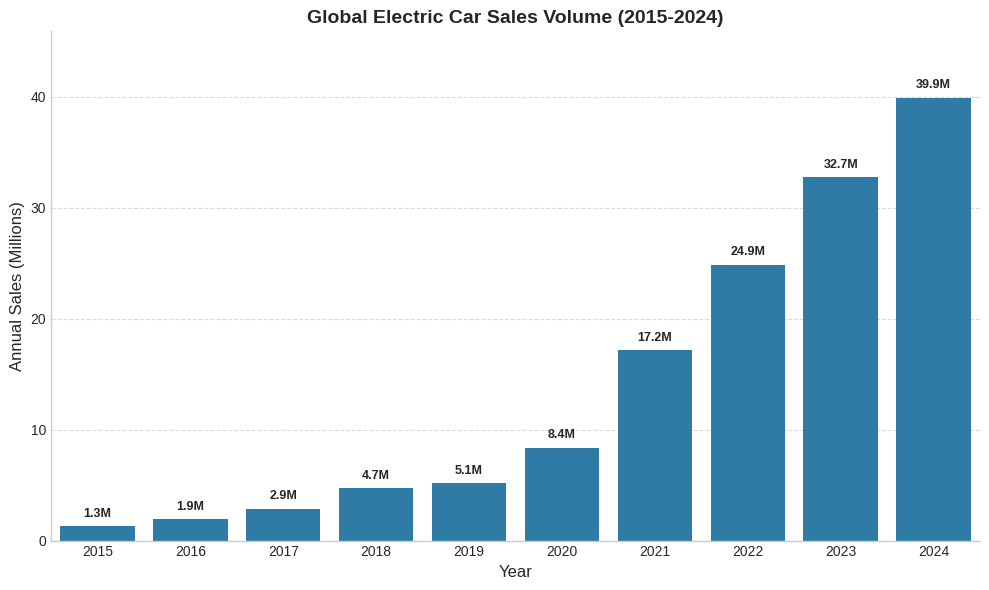

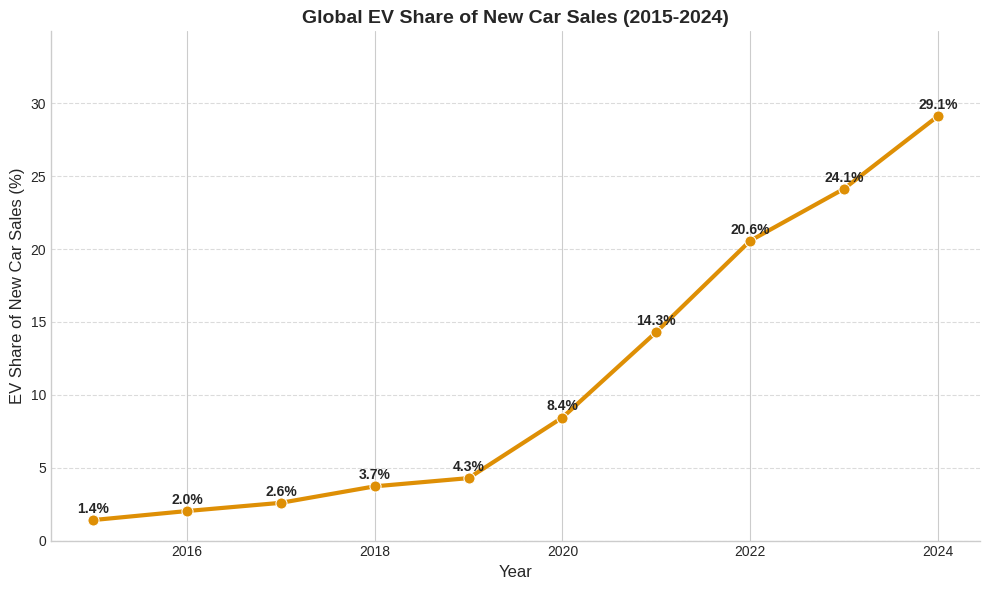

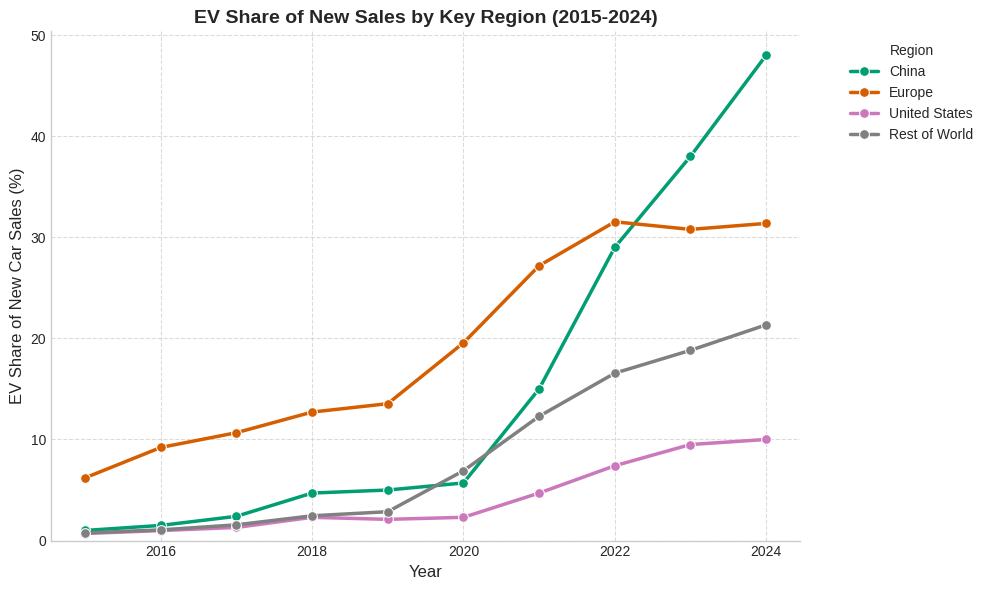

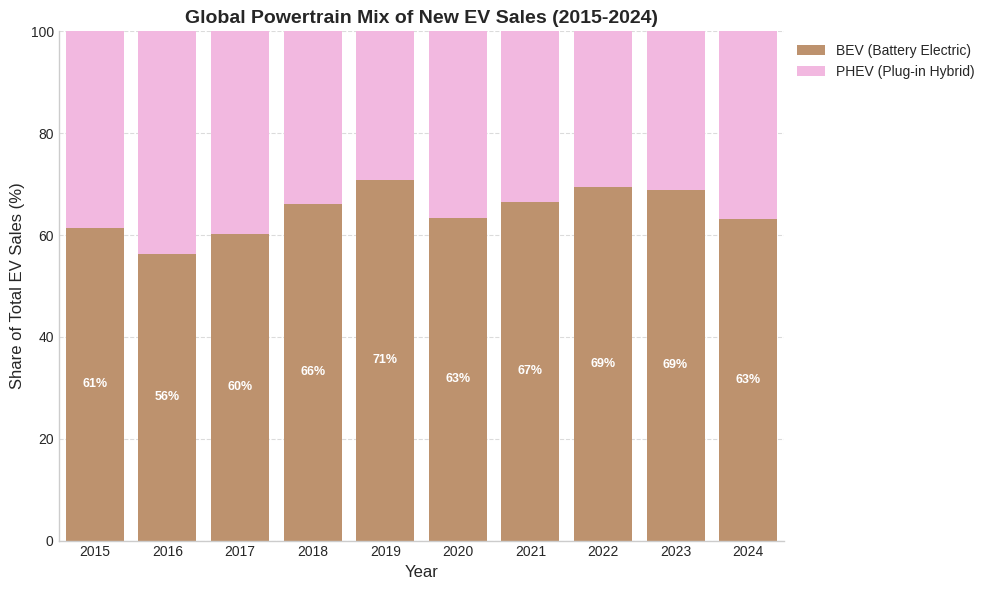

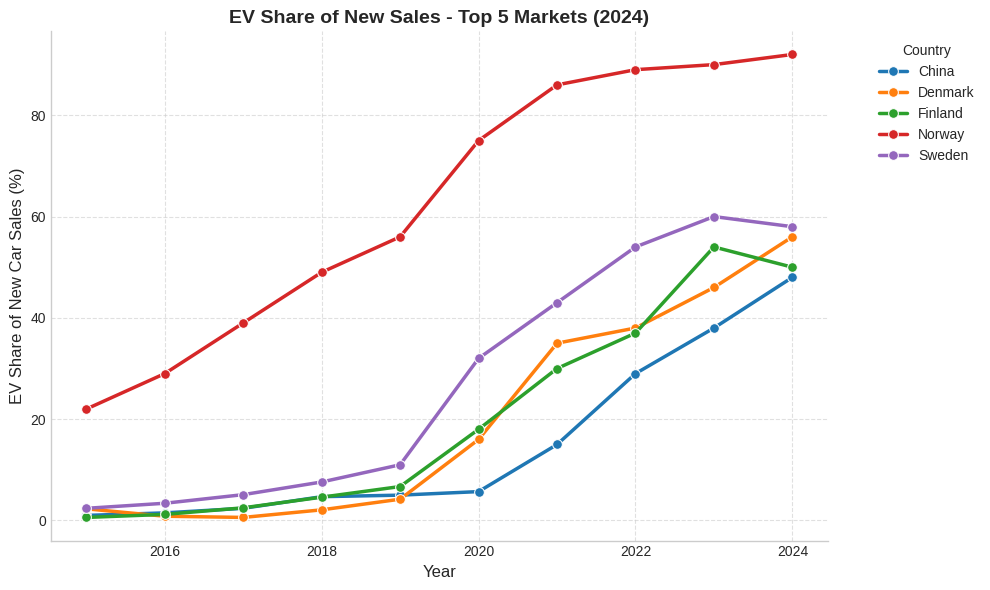

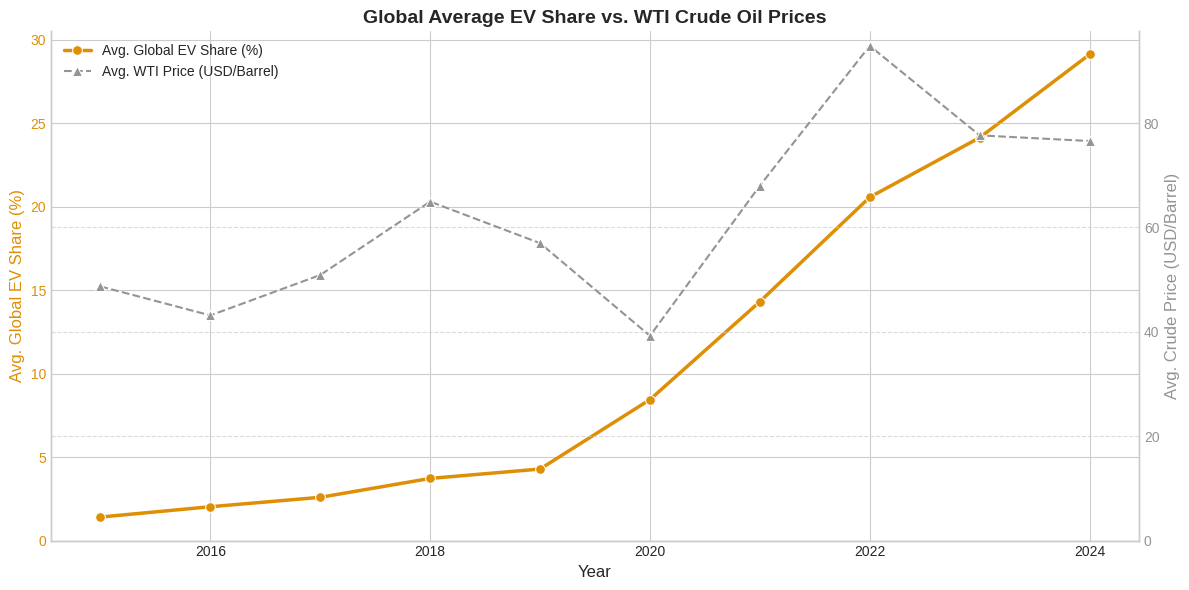

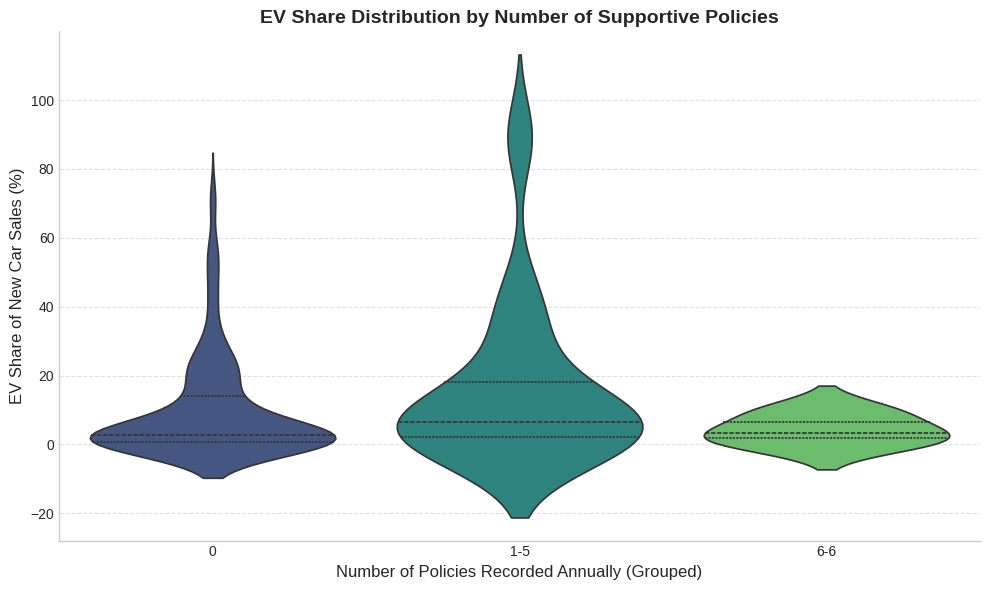

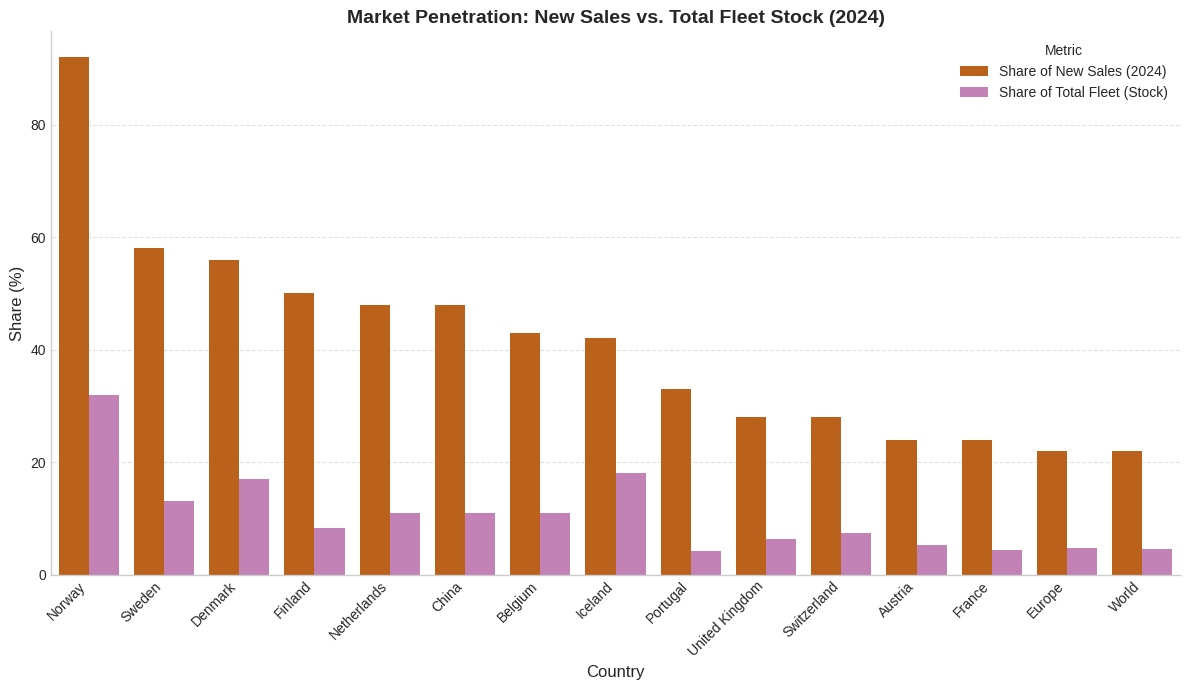

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# --- Setup ---
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
# Use a palette suited for report-style visuals, like Tableau's colorblind-safe palette
report_palette = sns.color_palette("colorblind", 10)
final_merged_file = 'final_merged_ev_dataset_annual.csv'
policy_raw_file = 'combined_policy_data_raw.csv' # For region mapping

print(f"--- Loading Data for 8 Storytelling Plots ---")

try:
    # Load the primary merged dataset
    df = pd.read_csv(final_merged_file)
    print(f"Loaded merged data: {final_merged_file} (Shape: {df.shape})")

    # --- Add Region Mapping (Robustly) ---
    try:
        df_policy = pd.read_csv(policy_raw_file)
        df_policy['country'] = df_policy['country'].str.strip()
        # Create mapping, handling potential duplicates by keeping the first region found
        country_to_region = df_policy.drop_duplicates(subset=['country'], keep='first').set_index('country')['region']
        df['region_mapped'] = df['country'].str.strip().map(country_to_region).fillna('Unknown')
        print("Region mapping added.")
    except Exception as e:
        print(f"Warning: Could not add region mapping from {policy_raw_file}: {e}")
        df['region_mapped'] = 'Unknown' # Add column even if mapping fails

    # Create a robust region_group for major markets
    def assign_region_group(row):
        country_strip = str(row.get('country', '')).strip() # Handle potential NaNs
        region_map = str(row.get('region_mapped', 'Unknown')).strip()

        if country_strip == 'China': return 'China'
        if country_strip == 'United States': return 'United States'
        if region_map == 'Europe': return 'Europe'
        # Fallback for key European countries if mapping failed
        if country_strip in ['Germany', 'Norway', 'France', 'United Kingdom', 'Netherlands', 'Sweden', 'Italy', 'Spain']: return 'Europe'
        return 'Rest of World'

    df['region_group'] = df.apply(assign_region_group, axis=1)
    print(f"Region groups assigned. Counts:\n{df['region_group'].value_counts()}")


    latest_year = int(df['year'].max())
    df_latest = df[df['year'] == latest_year].copy()

    # --- Column name definitions ---
    sales_vol_col = 'electric_cars_sold'
    sales_share_col = 'share_of_new_cars_that_are_electric'
    stock_share_col = 'share_of_car_stocks_that_are_electric'
    bev_share_of_ev_col = 'batteryelectric_as_a_share_of_electric_cars_sold'
    gas_col = 'gasoline_price_usd_liter'
    policy_col = 'policy_count'
    wti_col = 'WTI_Price_USD_Barrel'
    brent_col = 'Brent_Price_USD_Barrel'

    # ==========================================================================
    # --- Plot 1: Global EV Sales Volume (Like electric-car-sales.jpg) ---
    # ==========================================================================
    print("\nGenerating Plot 1: Global EV Sales Volume...")
    if sales_vol_col in df.columns:
        df_global_sales = df.groupby('year')[sales_vol_col].sum().reset_index()
        df_global_sales['electric_cars_sold_millions'] = df_global_sales[sales_vol_col] / 1_000_000

        plt.figure(figsize=(10, 6))
        ax = sns.barplot(data=df_global_sales, x='year', y='electric_cars_sold_millions', color=report_palette[0], alpha=0.9)

        # Add labels on top of bars
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.1f}M',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 9),
                        textcoords='offset points',
                        fontsize=9, weight='bold')

        plt.title(f'Global Electric Car Sales Volume (2015-{latest_year})', fontsize=14, weight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Annual Sales (Millions)', fontsize=12)
        plt.ylim(bottom=0, top=df_global_sales['electric_cars_sold_millions'].max() * 1.15)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        sns.despine() # Remove top and right spines
        plt.tight_layout()
        plt.savefig('story_plot_1_global_sales_volume.png', dpi=300)
    else:
        print("Skipping Plot 1: 'electric_cars_sold' not found.")

    # ==========================================================================
    # --- Plot 2: Global EV Market Share % (Like electric-car-sales-share.jpg - Global View) ---
    # ==========================================================================
    print("\nGenerating Plot 2: Global EV Market Share %...")
    if sales_share_col in df.columns and sales_vol_col in df.columns:
        # Calculate weighted global market share
        df_global_share = df.groupby('year').apply(
            lambda x: np.average(x[sales_share_col].fillna(0), weights=x[sales_vol_col].fillna(0)) if x[sales_vol_col].sum() > 0 else 0
        ).reset_index(name='global_ev_share_pct')

        plt.figure(figsize=(10, 6))
        ax = sns.lineplot(data=df_global_share, x='year', y='global_ev_share_pct', marker='o', linewidth=3, color=report_palette[1], markersize=8)

        # Add text labels for key points
        for _, row in df_global_share.iterrows():
            ax.text(row['year'], row['global_ev_share_pct'] + 0.5, f"{row['global_ev_share_pct']:.1f}%",
                    horizontalalignment='center', fontsize=10, weight='bold')

        plt.title(f'Global EV Share of New Car Sales (2015-{latest_year})', fontsize=14, weight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('EV Share of New Car Sales (%)', fontsize=12)
        plt.ylim(bottom=0, top=df_global_share['global_ev_share_pct'].max() * 1.2)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        sns.despine()
        plt.tight_layout()
        plt.savefig('story_plot_2_global_sales_share.png', dpi=300)
    else:
        print("Skipping Plot 2: Required columns for market share not found.")

    # ==========================================================================
    # --- Plot 3: Regional EV Market Share % Trends ---
    # ==========================================================================
    print("\nGenerating Plot 3: Regional EV Market Share % Trends...")
    if sales_share_col in df.columns and sales_vol_col in df.columns and 'region_group' in df.columns:
        # Calculate weighted regional market share
        df_regional_share = df.groupby(['year', 'region_group']).apply(
             lambda x: np.average(x[sales_share_col].fillna(0), weights=x[sales_vol_col].fillna(0)) if x[sales_vol_col].sum() > 0 else 0
        ).reset_index(name='regional_ev_share_pct')

        # Define consistent colors
        region_palette = {'China': report_palette[2], 'Europe': report_palette[3], 'United States': report_palette[4], 'Rest of World': 'grey'}

        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df_regional_share, x='year', y='regional_ev_share_pct',
                     hue='region_group', palette=region_palette, hue_order=['China', 'Europe', 'United States', 'Rest of World'],
                     marker='o', linewidth=2.5, markersize=7)

        plt.title(f'EV Share of New Sales by Key Region (2015-{latest_year})', fontsize=14, weight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('EV Share of New Car Sales (%)', fontsize=12)
        plt.ylim(bottom=0)
        plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)
        sns.despine()
        plt.tight_layout()
        plt.savefig('story_plot_3_regional_sales_share.png', dpi=300)
    else:
        print("Skipping Plot 3: Required columns or region group not found.")


    # ==========================================================================
    # --- Plot 4: Global Powertrain Mix (BEV vs. PHEV %) (Like share-car-sales-battery-plugin.jpg)---
    # ==========================================================================
    print("\nGenerating Plot 4: Global Powertrain Mix (BEV vs. PHEV %)...")
    if sales_vol_col in df.columns and bev_share_of_ev_col in df.columns:
        # Calculate global BEV and PHEV sales accurately handling NaNs
        df['bev_sales'] = df[sales_vol_col] * (df[bev_share_of_ev_col].fillna(0) / 100.0) # Assume 0% BEV if share is NaN
        df['phev_sales'] = df[sales_vol_col] - df['bev_sales']
        df.loc[df[sales_vol_col] == 0, ['bev_sales', 'phev_sales']] = 0 # Ensure 0 if total is 0

        df_powertrain = df.groupby('year')[['bev_sales', 'phev_sales']].sum().reset_index()
        df_powertrain['total_sales'] = df_powertrain['bev_sales'] + df_powertrain['phev_sales']

        # Avoid division by zero
        df_powertrain['bev_pct'] = np.where(df_powertrain['total_sales'] > 0, (df_powertrain['bev_sales'] / df_powertrain['total_sales']) * 100, 0)
        df_powertrain['phev_pct'] = np.where(df_powertrain['total_sales'] > 0, (df_powertrain['phev_sales'] / df_powertrain['total_sales']) * 100, 0)

        plt.figure(figsize=(10, 6))

        # Bottom bar (BEV)
        sns.barplot(data=df_powertrain, x='year', y='bev_pct', color=report_palette[5], label='BEV (Battery Electric)')
        # Top bar (PHEV)
        sns.barplot(data=df_powertrain, x='year', y='phev_pct', bottom=df_powertrain['bev_pct'], color=report_palette[6], label='PHEV (Plug-in Hybrid)')

        # Add labels for BEV share
        ax = plt.gca()
        for i, year in enumerate(df_powertrain['year']):
             bev_height = df_powertrain.loc[i, 'bev_pct']
             if bev_height > 5: # Only label if reasonably large
                 ax.text(i, bev_height / 2, f'{bev_height:.0f}%',
                        ha='center', va='center',
                        fontsize=9, weight='bold', color='white')

        plt.title(f'Global Powertrain Mix of New EV Sales (2015-{latest_year})', fontsize=14, weight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Share of Total EV Sales (%)', fontsize=12)
        plt.ylim(0, 100)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(False, axis='x') # No vertical grid lines on bar chart
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        sns.despine()
        plt.tight_layout()
        plt.savefig('story_plot_4_bev_vs_phev_mix.png', dpi=300)
    else:
        print("Skipping Plot 4: Required columns for powertrain mix not found.")


    # ==========================================================================
    # --- Plot 5: Market Share Leaders Over Time (Like electric-car-sales-share.jpg - Top Countries) ---
    # ==========================================================================
    print("\nGenerating Plot 5: Market Share Leaders Over Time...")
    if sales_share_col in df.columns:
        # Find top 5 countries by share in the latest year dynamically
        top_5_countries = df_latest.nlargest(5, sales_share_col)['country'].tolist()
        df_top5_trend = df[df['country'].isin(top_5_countries)]

        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df_top5_trend, x='year', y=sales_share_col, hue='country',
                     marker='o', linewidth=2.5, palette='tab10', markersize=7) # Use a distinct palette like tab10

        plt.title(f'EV Share of New Sales - Top 5 Markets ({latest_year})', fontsize=14, weight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('EV Share of New Car Sales (%)', fontsize=12)
        plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.6)
        sns.despine()
        plt.tight_layout()
        plt.savefig('story_plot_5_market_share_leaders.png', dpi=300)
    else:
        print("Skipping Plot 5: 'share_of_new_cars_that_are_electric' not found.")

    # ==========================================================================
    # --- Plot 6: Global EV Share % vs. Global Oil Prices (Includes Oil Data) ---
    # ==========================================================================
    print("\nGenerating Plot 6: Global EV Share % vs. Global Oil Prices...")
    if sales_share_col in df.columns and sales_vol_col in df.columns and wti_col in df.columns and brent_col in df.columns:
        # Calculate global weighted EV share (same as plot 2)
        df_global_share = df.groupby('year').apply(
            lambda x: np.average(x[sales_share_col].fillna(0), weights=x[sales_vol_col].fillna(0)) if x[sales_vol_col].sum() > 0 else 0
        ).reset_index(name='global_ev_share_pct')

        # Calculate global average oil prices
        df_global_oil = df.groupby('year')[[wti_col]].mean().reset_index() # Focus on WTI for clarity

        # Merge them
        df_global_trends = pd.merge(df_global_share, df_global_oil, on='year', how='inner')

        plt.figure(figsize=(12, 6))
        ax1 = plt.gca()

        # Plot EV Share
        ln1 = sns.lineplot(data=df_global_trends, x='year', y='global_ev_share_pct', marker='o', ax=ax1, color=report_palette[1], label='Avg. Global EV Share (%)', linewidth=2.5, markersize=7)
        ax1.set_ylabel('Avg. Global EV Share (%)', color=report_palette[1], fontsize=12)
        ax1.tick_params(axis='y', labelcolor=report_palette[1])
        ax1.set_xlabel('Year', fontsize=12)
        ax1.set_ylim(bottom=0)

        # Plot Oil Prices on secondary axis
        ax2 = ax1.twinx()
        ln2 = sns.lineplot(data=df_global_trends, x='year', y=wti_col, marker='^', ax=ax2, color=report_palette[7], label='Avg. WTI Price (USD/Barrel)', linestyle='--', markersize=7)
        ax2.set_ylabel('Avg. Crude Price (USD/Barrel)', color=report_palette[7], fontsize=12)
        ax2.tick_params(axis='y', labelcolor=report_palette[7])
        ax2.set_ylim(bottom=0)

        # Combine legends
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc='upper left')
        ax2.get_legend().remove() # Remove redundant legend

        plt.title('Global Average EV Share vs. WTI Crude Oil Prices', fontsize=14, weight='bold')
        plt.grid(True, linestyle='--', alpha=0.7)
        sns.despine(right=False) # Keep right spine for secondary axis
        plt.tight_layout()
        plt.savefig('story_plot_6_share_vs_oil_prices.png', dpi=300)
    else:
        print("Skipping Plot 6: Missing required columns for EV share or oil prices.")

    # ==========================================================================
    # --- Plot 7: EV Share % vs. Policy Count (Includes Policy Data) ---
    # ==========================================================================
    print("\nGenerating Plot 7: EV Share % vs. Policy Count...")
    if sales_share_col in df.columns and policy_col in df.columns:
        # Create dynamic policy groups
        max_policies = int(df[policy_col].max())
        if max_policies <= 5:
            bins = [-1, 0, max_policies]; labels = ['0', f'1-{max_policies}']
        elif max_policies <= 10:
            bins = [-1, 0, 5, max_policies]; labels = ['0', '1-5', f'6-{max_policies}']
        else:
            bins = [-1, 0, 5, 10, max_policies]; labels = ['0', '1-5', '6-10', '11+']

        df['policy_group'] = pd.cut(df[policy_col], bins=bins, labels=labels, right=True)

        plt.figure(figsize=(10, 6))
        # Use violin plot for a nicer look at distribution
        sns.violinplot(data=df.dropna(subset=['policy_group']),
                    x='policy_group', y=sales_share_col,
                    palette='viridis', inner='quartile', # Show quartiles inside
                    order=labels)

        plt.title('EV Share Distribution by Number of Supportive Policies', fontsize=14, weight='bold')
        plt.xlabel('Number of Policies Recorded Annually (Grouped)', fontsize=12)
        plt.ylabel('EV Share of New Car Sales (%)', fontsize=12)
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        sns.despine()
        plt.tight_layout()
        plt.savefig('story_plot_7_share_vs_policy.png', dpi=300)
    else:
        print("Skipping Plot 7: Missing EV share or policy count columns.")


    # ==========================================================================
    # --- Plot 8: New Sales Share % vs. Total Fleet Stock % (Like share-car-stocks-electric.jpg & sales share combined) ---
    # ==========================================================================
    print("\nGenerating Plot 8: New Sales Share % vs. Total Fleet Stock %...")
    if sales_share_col in df.columns and stock_share_col in df.columns:
        # Select top 15 countries by NEW sales share
        countries_for_stock = df_latest.nlargest(15, sales_share_col)['country'].tolist()
        df_stock_comp = df_latest[df_latest['country'].isin(countries_for_stock)].copy()

        # Melt dataframe for easier plotting with dodged bars
        df_stock_melted = df_stock_comp.melt(id_vars='country',
                                             value_vars=[sales_share_col, stock_share_col],
                                             var_name='Share Type',
                                             value_name='Share (%)').dropna(subset=['Share (%)']) # Drop if stock share is NaN

        df_stock_melted['Share Type'] = df_stock_melted['Share Type'].map({
            sales_share_col: f'Share of New Sales ({latest_year})',
            stock_share_col: 'Share of Total Fleet (Stock)'
        })

        # Sort countries by new sales share for a clean plot
        country_order = df_latest[df_latest['country'].isin(countries_for_stock)].sort_values(sales_share_col, ascending=False)['country']

        plt.figure(figsize=(12, 7))
        sns.barplot(data=df_stock_melted, x='country', y='Share (%)', hue='Share Type',
                    palette=[report_palette[3], report_palette[4]], # Use distinct colors
                    order=country_order)

        plt.title(f'Market Penetration: New Sales vs. Total Fleet Stock ({latest_year})', fontsize=14, weight='bold')
        plt.xlabel('Country', fontsize=12)
        plt.ylabel('Share (%)', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Metric')
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        sns.despine()
        plt.tight_layout()
        plt.savefig('story_plot_8_sales_vs_stock.png', dpi=300)
    else:
        print("Skipping Plot 8: Required stock/sales share columns not found.")

    print("\n--- All 8 Storytelling Plots Generated ---")
    print("Plots saved as PNG files.")

except FileNotFoundError:
    print(f"Error: Required data file not found. Please ensure '{final_merged_file}' and '{policy_raw_file}' exist.")
except KeyError as ke:
    print(f"Error: A required column was not found. Check column names. Details: {ke}")
except Exception as e:
    print(f"An error occurred during visualization: {e}")

# **Oil & Gasoline Focus**

**Story**

Global oil prices, like WTI crude, fluctuate based on complex geopolitical and economic factors. While there's a general upward trend in both oil prices and global EV adoption over the last decade, the direct link isn't always straightforward year-to-year. However, when we zoom into individual countries, the picture becomes clearer. Countries consistently facing high gasoline prices (often due to taxes or import costs) tend to show faster EV adoption, particularly in Europe. The trajectory of adoption within a country often seems to accelerate when gasoline prices are higher, suggesting consumers become more sensitive to fuel costs as EVs become more viable alternatives. Yet, the relationship isn't uniform; policy and existing market maturity play significant roles, as seen in Norway's continued high adoption even when prices fluctuate.

**Inference**

While global oil prices provide a macro backdrop, local gasoline prices act as a more direct economic pressure point influencing consumer interest in EVs. However, this effect is strongly modulated by government policies (subsidies, taxes) and the maturity of the local EV market (availability of models, charging infrastructure). High gasoline prices alone don't guarantee high EV adoption, but they significantly strengthen the case for switching, especially when supported by policy.

**Conclusion**

Gasoline prices are a significant, though regionally variable, driver influencing the pace and timing of EV adoption. They interact strongly with policy measures, creating conditions where consumers are more likely to make the switch from traditional vehicles.

--- Loading Data for Angle 1 Plots ---
Loaded final_merged_ev_dataset_annual.csv

Generating Plot 1.1: Global EV Share vs. Global Oil Prices...


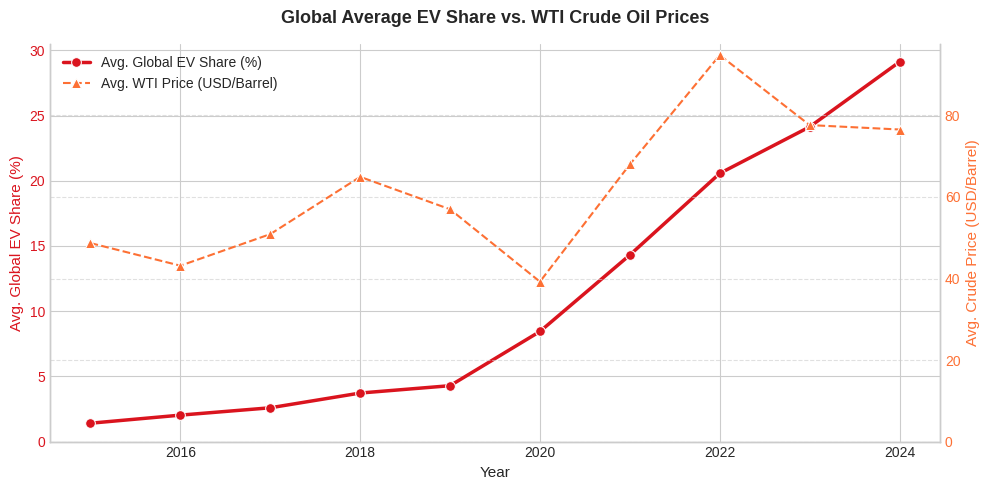


Generating Plot 1.2: EV Share vs. Gasoline Price Scatter...


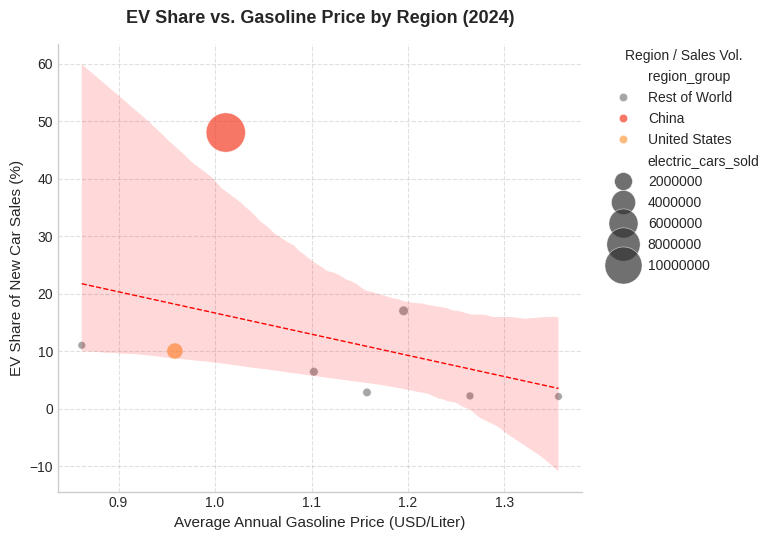


Generating Plot 1.3: Country Trajectories: EV Share vs. Gas Price...


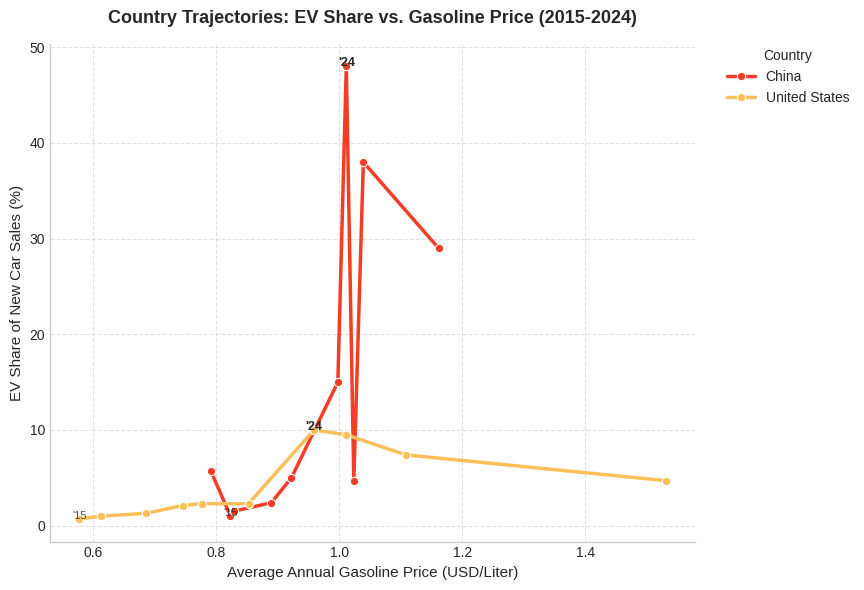


Generating Plot 1.4: Distribution of Gasoline Prices...


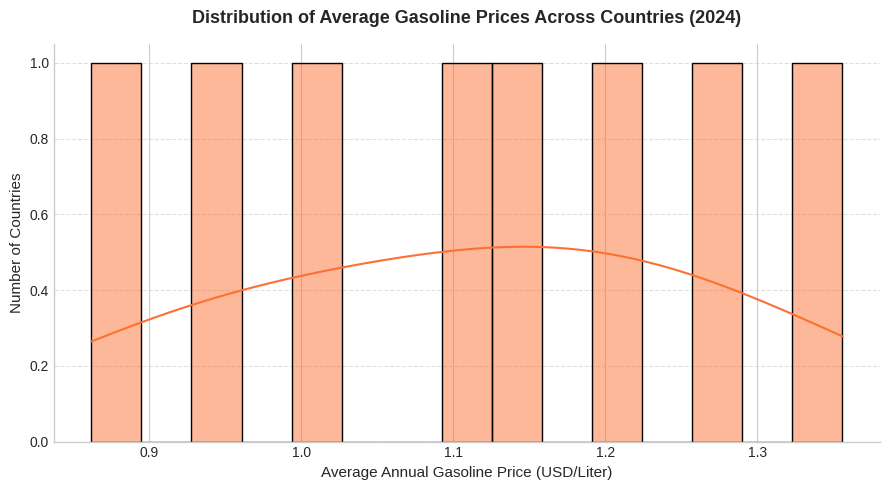


Generating Plot 1.5: EV Share Trend for High vs Low Gas Price Countries...


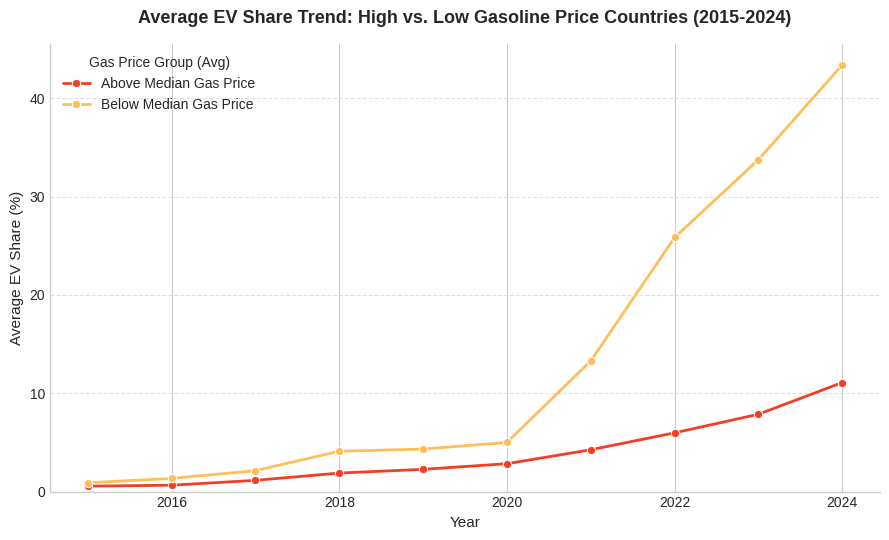

In [ ]:
# Angle 1 Plots: Oil & Gasoline Focus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# --- Setup ---
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
palette_angle1 = sns.color_palette("YlOrRd", 8) # Yellow-Orange-Red palette
final_merged_file = 'final_merged_ev_dataset_annual.csv'
print(f"--- Loading Data for Angle 1 Plots ---")

try:
    if not os.path.exists(final_merged_file): raise FileNotFoundError(f"'{final_merged_file}' needed.")
    df = pd.read_csv(final_merged_file)
    print(f"Loaded {final_merged_file}")

    # Add Region Mapping (simplified for plotting)
    def assign_region_group(country):
        if country == 'China': return 'China'
        if country == 'United States': return 'United States'
        # Rough grouping for Europe - needs refinement based on actual data/policy file
        europe_list = ['Norway', 'Germany', 'France', 'United Kingdom', 'Netherlands', 'Sweden', 'Italy', 'Spain', 'Belgium', 'Austria', 'Switzerland', 'Denmark', 'Finland', 'Ireland', 'Portugal']
        if country in europe_list: return 'Europe'
        return 'Rest of World'
    df['region_group'] = df['country'].apply(assign_region_group)

    # Determine year range
    min_year_data = int(df['year'].min())
    max_year_data = int(df['year'].max())
    start_year_plot = max(2015, min_year_data) # Focus on recent years with better data
    end_year_plot = max_year_data
    df_plot_range = df[(df['year'] >= start_year_plot) & (df['year'] <= end_year_plot)].copy()
    latest_year = end_year_plot
    df_latest = df[df['year'] == latest_year].copy()

    # --- Column names ---
    sales_share_col = 'share_of_new_cars_that_are_electric'
    sales_vol_col = 'electric_cars_sold'
    gas_col = 'gasoline_price_usd_liter'
    wti_col = 'WTI_Price_USD_Barrel'

    # --- Plot 1.1: Global EV Share % vs. Global Oil Prices ---
    print("\nGenerating Plot 1.1: Global EV Share vs. Global Oil Prices...")
    if sales_share_col in df_plot_range.columns and sales_vol_col in df_plot_range.columns and wti_col in df_plot_range.columns:
        df_global_share = df_plot_range.groupby('year').apply(lambda x: np.average(x[sales_share_col].fillna(0), weights=x[sales_vol_col].fillna(0)) if x[sales_vol_col].sum(skipna=True) > 0 else 0).reset_index(name='global_ev_share_pct')
        df_global_oil = df_plot_range.groupby('year')[[wti_col]].mean().reset_index()
        df_global_trends = pd.merge(df_global_share, df_global_oil, on='year', how='inner')
        fig, ax1 = plt.subplots(figsize=(10, 5))
        ln1 = sns.lineplot(data=df_global_trends, x='year', y='global_ev_share_pct', marker='o', ax=ax1, color=palette_angle1[6], label='Avg. Global EV Share (%)', linewidth=2.5, markersize=7)
        ax1.set_ylabel('Avg. Global EV Share (%)', color=palette_angle1[6], fontsize=11); ax1.tick_params(axis='y', labelcolor=palette_angle1[6]); ax1.set_xlabel('Year', fontsize=11); ax1.set_ylim(bottom=0)
        ax2 = ax1.twinx()
        ln2 = sns.lineplot(data=df_global_trends, x='year', y=wti_col, marker='^', ax=ax2, color=palette_angle1[4], label='Avg. WTI Price (USD/Barrel)', linestyle='--', markersize=7)
        ax2.set_ylabel('Avg. Crude Price (USD/Barrel)', color=palette_angle1[4], fontsize=11); ax2.tick_params(axis='y', labelcolor=palette_angle1[4]); ax2.set_ylim(bottom=0)
        h1, l1 = ax1.get_legend_handles_labels(); h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc='upper left'); ax2.get_legend().remove()
        plt.title('Global Average EV Share vs. WTI Crude Oil Prices', fontsize=13, weight='bold', pad=15)
        plt.grid(True, linestyle='--', alpha=0.6); sns.despine(right=False)
        fig.tight_layout()
        plt.show()
    else: print("Skipping Plot 1.1: Missing required columns.")

    # --- Plot 1.2: EV Share vs. Gasoline Price Scatter (Latest Year) ---
    print("\nGenerating Plot 1.2: EV Share vs. Gasoline Price Scatter...")
    if sales_share_col in df_latest.columns and gas_col in df_latest.columns:
        df_latest_econ = df_latest.dropna(subset=[sales_share_col, gas_col])
        if not df_latest_econ.empty:
            plt.figure(figsize=(9, 5.5))
            sns.scatterplot(data=df_latest_econ, x=gas_col, y=sales_share_col,
                            hue='region_group', palette={'China': palette_angle1[5], 'Europe': palette_angle1[4], 'United States': palette_angle1[3], 'Rest of World': 'grey'},
                            size=sales_vol_col if sales_vol_col in df_latest_econ else None, sizes=(30,800), alpha=0.7, legend='auto')
            sns.regplot(data=df_latest_econ, x=gas_col, y=sales_share_col, scatter=False, color='red', line_kws={'linestyle':'--','linewidth':1}) # Add trend line
            plt.title(f'EV Share vs. Gasoline Price by Region ({latest_year})', fontsize=13, weight='bold', pad=15)
            plt.xlabel('Average Annual Gasoline Price (USD/Liter)', fontsize=11); plt.ylabel('EV Share of New Car Sales (%)', fontsize=11)
            plt.grid(True, linestyle='--', alpha=0.6); sns.despine()
            plt.legend(title='Region / Sales Vol.', bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.)
            plt.tight_layout(rect=[0, 0, 0.88, 1])
            plt.show()
        else: print(f"Skipping Plot 1.2: No data with both EV share and gasoline price for {latest_year}.")
    else: print("Skipping Plot 1.2: Missing EV share or gasoline price columns.")

    # --- Plot 1.3: Country Trajectories: EV Share vs. Gas Price ---
    print("\nGenerating Plot 1.3: Country Trajectories: EV Share vs. Gas Price...")
    if sales_share_col in df_plot_range.columns and gas_col in df_plot_range.columns:
        countries_to_trace = ['Norway', 'China', 'Germany', 'United States', 'France', 'United Kingdom']
        df_traj = df_plot_range[df_plot_range['country'].isin(countries_to_trace)].copy()
        df_traj = df_traj.dropna(subset=[gas_col, sales_share_col])
        if not df_traj.empty:
            plt.figure(figsize=(10, 6))
            sns.lineplot(data=df_traj, x=gas_col, y=sales_share_col, hue='country', palette='YlOrRd_r', linewidth=2.5, marker='o', markersize=6, legend='full')
            for country in df_traj['country'].unique(): # Add year labels
                country_data = df_traj[df_traj['country'] == country].sort_values('year')
                if not country_data.empty:
                    plt.text(country_data.iloc[0][gas_col], country_data.iloc[0][sales_share_col], f"'{country_data.iloc[0]['year'] % 100}", fontsize=8, alpha=0.8, ha='center')
                    plt.text(country_data.iloc[-1][gas_col], country_data.iloc[-1][sales_share_col], f"'{country_data.iloc[-1]['year'] % 100}", fontsize=9, alpha=1.0, weight='bold', ha='center')
            plt.title(f'Country Trajectories: EV Share vs. Gasoline Price ({start_year_plot}-{end_year_plot})', fontsize=13, weight='bold', pad=15)
            plt.xlabel('Average Annual Gasoline Price (USD/Liter)', fontsize=11); plt.ylabel('EV Share of New Car Sales (%)', fontsize=11)
            plt.grid(True, linestyle='--', alpha=0.6); sns.despine()
            plt.legend(title='Country', bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.)
            plt.tight_layout(rect=[0, 0, 0.88, 1])
            plt.show()
        else: print("Skipping Plot 1.3: No valid trajectory data for selected countries.")
    else: print("Skipping Plot 1.3: Missing required columns.")

    # --- Plot 1.4: Distribution of Gasoline Prices ---
    print("\nGenerating Plot 1.4: Distribution of Gasoline Prices...")
    if gas_col in df_latest.columns:
         df_latest_gas = df_latest.dropna(subset=[gas_col])
         if not df_latest_gas.empty:
              plt.figure(figsize=(9, 5))
              sns.histplot(df_latest_gas[gas_col], kde=True, bins=15, color=palette_angle1[4])
              plt.title(f'Distribution of Average Gasoline Prices Across Countries ({latest_year})', fontsize=13, weight='bold', pad=15)
              plt.xlabel('Average Annual Gasoline Price (USD/Liter)', fontsize=11)
              plt.ylabel('Number of Countries', fontsize=11)
              plt.grid(True, axis='y', linestyle='--', alpha=0.6); sns.despine()
              plt.tight_layout()
              plt.show()
         else: print(f"Skipping Plot 1.4: No gasoline price data for {latest_year}.")
    else: print("Skipping Plot 1.4: Gasoline price column not found.")

    # --- Plot 1.5: Trend for High vs Low Gas Price Countries ---
    print("\nGenerating Plot 1.5: EV Share Trend for High vs Low Gas Price Countries...")
    if gas_col in df_plot_range.columns and sales_share_col in df_plot_range.columns and sales_vol_col in df_plot_range.columns:
         # Calculate average gas price per country over the period
         avg_gas_price = df_plot_range.groupby('country')[gas_col].mean()
         median_gas_price = avg_gas_price.median() # Use median to split

         df_plot_range['gas_price_group'] = df_plot_range['country'].map(avg_gas_price).apply(
             lambda x: 'Above Median Gas Price' if pd.notna(x) and x >= median_gas_price else ('Below Median Gas Price' if pd.notna(x) else 'Unknown')
         )
         df_gas_group_trend = df_plot_range[df_plot_range['gas_price_group'] != 'Unknown'].groupby(['year', 'gas_price_group']).apply(
             lambda x: np.average(x[sales_share_col].fillna(0), weights=x[sales_vol_col].fillna(0)) if x[sales_vol_col].sum(skipna=True) > 0 else 0
         ).reset_index(name='avg_ev_share')

         if not df_gas_group_trend.empty:
              plt.figure(figsize=(9, 5.5))
              sns.lineplot(data=df_gas_group_trend, x='year', y='avg_ev_share', hue='gas_price_group',
                           marker='o', linewidth=2, palette=[palette_angle1[5], palette_angle1[2]], markersize=6) # Red/Orange shades
              plt.title(f'Average EV Share Trend: High vs. Low Gasoline Price Countries ({start_year_plot}-{end_year_plot})', fontsize=13, weight='bold', pad=15)
              plt.xlabel('Year', fontsize=11); plt.ylabel('Average EV Share (%)', fontsize=11)
              plt.ylim(bottom=0)
              plt.legend(title='Gas Price Group (Avg)')
              plt.grid(True, axis='y', linestyle='--', alpha=0.6); sns.despine()
              plt.tight_layout()
              plt.show()
         else: print("Skipping Plot 1.5: Could not group countries by gas price.")
    else: print("Skipping Plot 1.5: Missing required columns.")


except FileNotFoundError as e: print(f"Error loading data: {e}")
except KeyError as e: print(f"Error: Missing expected column: {e}")
except Exception as e: print(f"An unexpected error occurred: {e}")

# **Angle 2: Policy Effectiveness and Types 📜**
**Story**

Government policies clearly play a role in kickstarting and sustaining EV adoption. Looking globally, countries grouped by the number of policies they enact show a strong positive correlation: more policies tend to align with higher median EV market shares. Digging deeper (even with simple keyword categorization), policies focusing on financial incentives (subsidies, tax breaks) and charging infrastructure appear frequently in high-adoption countries. While regulations like ICE bans set long-term goals, immediate consumer uptake often follows direct financial benefits and the assurance of convenient charging. Comparing the adoption trajectories of countries with historically high policy counts versus those with moderate counts further highlights this divergence; the high-policy group generally shows steeper and earlier growth.

**Inference**

Policy intervention is a critical catalyst for EV market growth. While a higher number of policies is correlated with success, the type and implementation likely matter significantly. Financial incentives and infrastructure development seem particularly important for overcoming initial adoption barriers related to cost and range anxiety.

**Conclusion**

A comprehensive and sustained policy strategy, incorporating both financial levers and infrastructure build-out, is strongly associated with accelerating the transition to electric vehicles. Simply setting targets may be less effective without supporting mechanisms.

--- Loading Data for Angle 2 Plots ---
Loaded final_merged_ev_dataset_annual.csv
Loaded combined_policy_data_raw.csv

Generating Plot 2.1: EV Share vs. Policy Count Groups (Violin)...


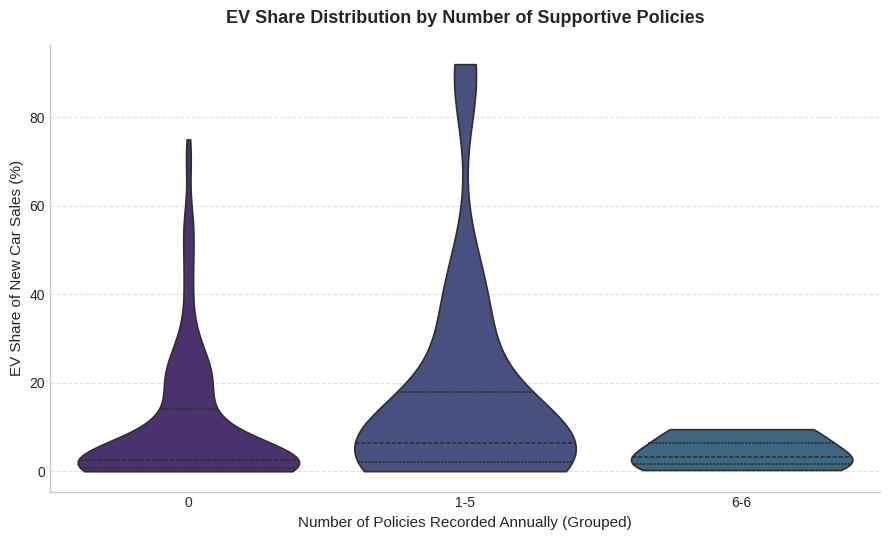


Generating Plot 2.2: EV Share vs. Policy Count Scatter...


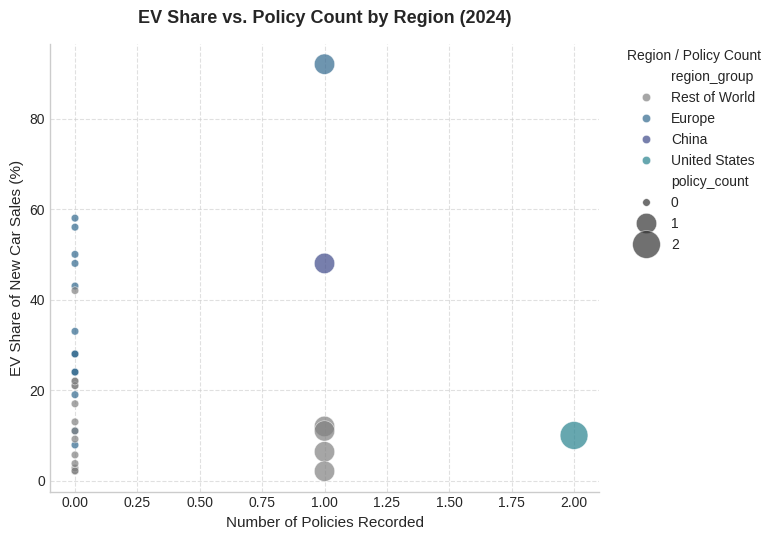


Generating Plot 2.3: EV Share Trend Comparison by Policy Level...


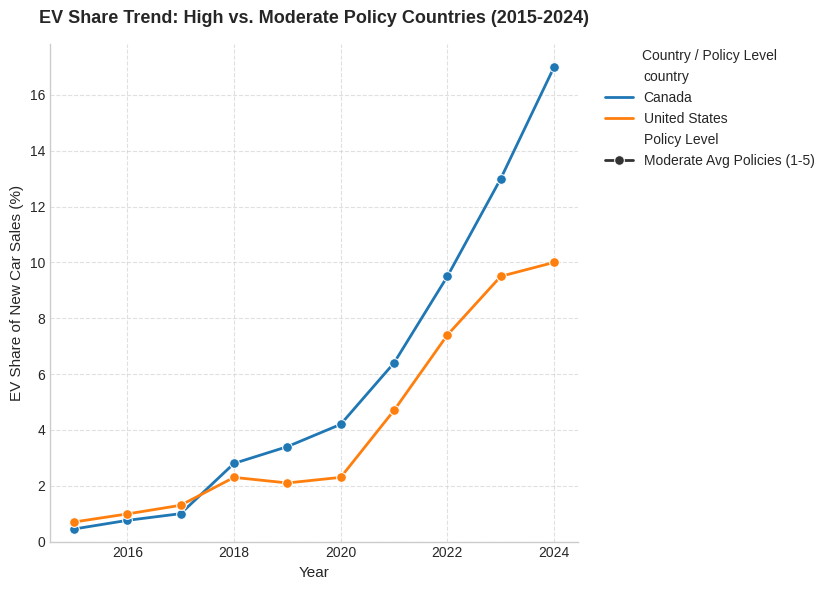


Generating Plot 2.4: Policy Type Count Over Time...


<Figure size 1000x600 with 0 Axes>

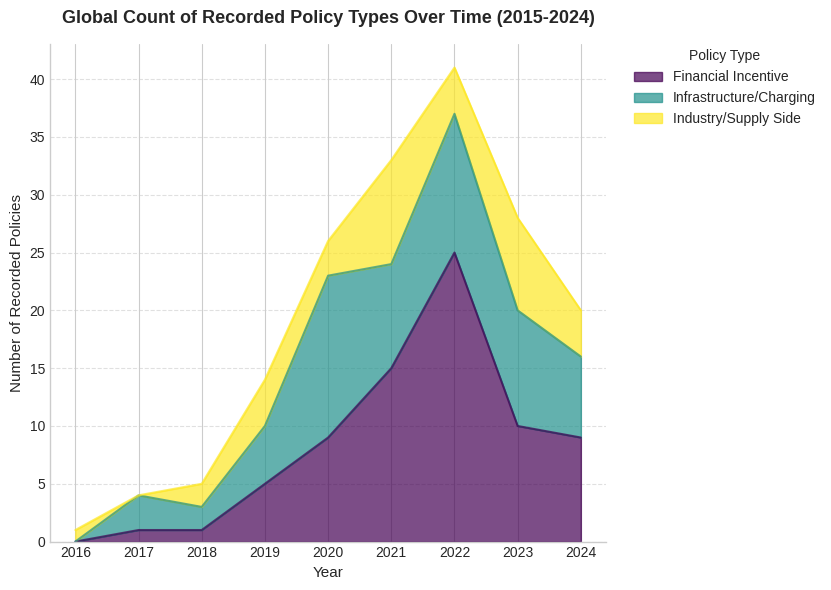


Generating Plot 2.5: EV Share Growth vs Change in Policy Count...


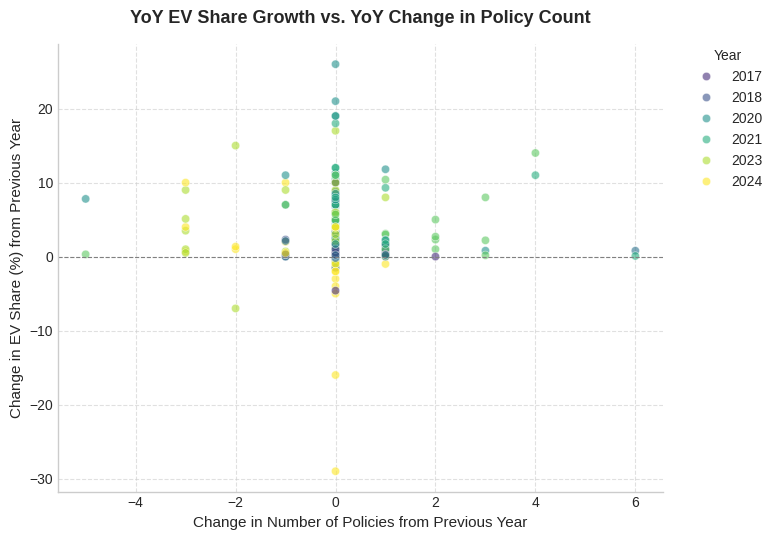

In [ ]:
# Angle 2 Plots: Policy Focus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import re # For keyword searching

# --- Setup ---
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
palette_angle2 = sns.color_palette("viridis", 8) # Viridis for policy plots
final_merged_file = 'final_merged_ev_dataset_annual.csv'
policy_raw_file = 'combined_policy_data_raw.csv' # Needed for policy details
print(f"--- Loading Data for Angle 2 Plots ---")

try:
    if not os.path.exists(final_merged_file): raise FileNotFoundError(f"'{final_merged_file}' needed.")
    df = pd.read_csv(final_merged_file)
    print(f"Loaded {final_merged_file}")
    if not os.path.exists(policy_raw_file): print(f"Warning: '{policy_raw_file}' not found, policy type analysis will be limited."); df_policy_raw = pd.DataFrame()
    else: df_policy_raw = pd.read_csv(policy_raw_file); print(f"Loaded {policy_raw_file}")

    # Add Region Mapping (simplified)
    def assign_region_group(country):
        if country == 'China': return 'China'
        if country == 'United States': return 'United States'
        europe_list = ['Norway', 'Germany', 'France', 'United Kingdom', 'Netherlands', 'Sweden', 'Italy', 'Spain', 'Belgium', 'Austria', 'Switzerland', 'Denmark', 'Finland', 'Ireland', 'Portugal']
        if country in europe_list: return 'Europe'
        return 'Rest of World'
    df['region_group'] = df['country'].apply(assign_region_group)
    region_palette = {'China': palette_angle2[1], 'Europe': palette_angle2[2], 'United States': palette_angle2[3], 'Rest of World': 'grey'}


    # Determine year range
    min_year_data = int(df['year'].min())
    max_year_data = int(df['year'].max())
    start_year_plot = max(2015, min_year_data)
    end_year_plot = max_year_data
    df_plot_range = df[(df['year'] >= start_year_plot) & (df['year'] <= end_year_plot)].copy()
    latest_year = end_year_plot
    df_latest = df[df['year'] == latest_year].copy()

    # --- Column names ---
    sales_share_col = 'share_of_new_cars_that_are_electric'
    policy_col = 'policy_count'

    # --- Plot 2.1: EV Share % vs. Policy Count (Violin) ---
    print("\nGenerating Plot 2.1: EV Share vs. Policy Count Groups (Violin)...")
    if sales_share_col in df_plot_range.columns and policy_col in df_plot_range.columns:
        df_plot_range_policy = df_plot_range.dropna(subset=[policy_col])
        if not df_plot_range_policy.empty:
             max_policies = int(df_plot_range_policy[policy_col].max())
             if max_policies <= 0: print("Skipping Plot 2.1: No policy data > 0 found.")
             else:
                if max_policies <= 5: bins = [-1, 0, max_policies]; labels = ['0', f'1-{max_policies}']
                elif max_policies <= 10: bins = [-1, 0, 5, max_policies]; labels = ['0', '1-5', f'6-{max_policies}']
                else: bins = [-1, 0, 5, 10, max_policies]; labels = ['0', '1-5', '6-10', '11+']
                df_plot_range['policy_group'] = pd.cut(df_plot_range[policy_col], bins=bins, labels=labels, right=True)
                plt.figure(figsize=(9, 5.5))
                sns.violinplot(data=df_plot_range.dropna(subset=['policy_group']), x='policy_group', y=sales_share_col, palette=palette_angle2, inner='quartile', order=labels, cut=0)
                plt.title('EV Share Distribution by Number of Supportive Policies', fontsize=13, weight='bold', pad=15)
                plt.xlabel('Number of Policies Recorded Annually (Grouped)', fontsize=11); plt.ylabel('EV Share of New Car Sales (%)', fontsize=11)
                plt.grid(True, axis='y', linestyle='--', alpha=0.6); sns.despine()
                plt.tight_layout()
                plt.show()
        else: print("Skipping Plot 2.1: No policy data after dropping NaNs.")
    else: print("Skipping Plot 2.1: Missing required columns.")

    # --- Plot 2.2: EV Share vs. Policy Count Scatter (Latest Year) ---
    print("\nGenerating Plot 2.2: EV Share vs. Policy Count Scatter...")
    if sales_share_col in df_latest.columns and policy_col in df_latest.columns:
        df_latest_policy = df_latest.dropna(subset=[sales_share_col, policy_col])
        if not df_latest_policy.empty:
            plt.figure(figsize=(9, 5.5))
            sns.scatterplot(data=df_latest_policy, x=policy_col, y=sales_share_col,
                            hue='region_group', palette=region_palette,
                            size=policy_col, sizes=(30, 400), # Size bubbles by policy count itself
                            alpha=0.7, legend='auto')
            plt.title(f'EV Share vs. Policy Count by Region ({latest_year})', fontsize=13, weight='bold', pad=15)
            plt.xlabel('Number of Policies Recorded', fontsize=11); plt.ylabel('EV Share of New Car Sales (%)', fontsize=11)
            plt.grid(True, linestyle='--', alpha=0.6); sns.despine()
            plt.legend(title='Region / Policy Count', bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.)
            plt.tight_layout(rect=[0, 0, 0.88, 1])
            plt.show()
        else: print(f"Skipping Plot 2.2: No valid data for {latest_year}.")
    else: print("Skipping Plot 2.2: Missing required columns.")

    # --- Plot 2.3: EV Share Trend: High vs. Moderate Policy Countries ---
    print("\nGenerating Plot 2.3: EV Share Trend Comparison by Policy Level...")
    if sales_share_col in df_plot_range.columns and policy_col in df_plot_range.columns:
        avg_policies = df_plot_range.groupby('country')[policy_col].mean()
        high_policy_countries = avg_policies[avg_policies > 5].index.tolist()
        high_policy_examples = [c for c in ['Norway', 'China', 'Germany', 'France', 'Netherlands'] if c in high_policy_countries][:4]
        moderate_policy_countries = avg_policies[(avg_policies > 1) & (avg_policies <= 5)].index.tolist()
        moderate_policy_examples = [c for c in ['United States', 'United Kingdom', 'Canada', 'Australia', 'Italy'] if c in moderate_policy_countries][:4]
        selected_countries = high_policy_examples + moderate_policy_examples

        if selected_countries:
            df_policy_trend = df_plot_range[df_plot_range['country'].isin(selected_countries)].copy()
            df_policy_trend['Policy Level'] = df_policy_trend['country'].apply(lambda x: 'High Avg Policies (>5)' if x in high_policy_examples else 'Moderate Avg Policies (1-5)')

            plt.figure(figsize=(10, 6))
            sns.lineplot(data=df_policy_trend, x='year', y=sales_share_col,
                         hue='country', style='Policy Level',
                         markers=True, markersize=7, linewidth=2, palette='tab10') # Use distinct colors
            plt.title(f'EV Share Trend: High vs. Moderate Policy Countries ({start_year_plot}-{end_year_plot})', fontsize=13, weight='bold', pad=15)
            plt.xlabel('Year', fontsize=11); plt.ylabel('EV Share of New Car Sales (%)', fontsize=11)
            plt.ylim(bottom=0)
            plt.legend(title='Country / Policy Level', bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.)
            plt.grid(True, linestyle='--', alpha=0.6); sns.despine()
            plt.tight_layout(rect=[0, 0, 0.85, 1]) # Make more room for legend
            plt.show()
        else: print("Skipping Plot 2.3: Could not identify example countries for policy groups.")
    else: print("Skipping Plot 2.3: Missing required columns.")

    # --- Plot 2.4: Policy Type Count Over Time (Attempt) ---
    print("\nGenerating Plot 2.4: Policy Type Count Over Time...")
    if not df_policy_raw.empty and 'year' in df_policy_raw.columns and 'category' in df_policy_raw.columns:
         # Simplified categorization based on keywords
        def categorize_policy(category_str):
            if pd.isna(category_str): return 'Other/Unknown'
            cat_lower = category_str.lower()
            if re.search(r'tax|subsidy|incentive|grant|rebate|loan|fee', cat_lower): return 'Financial Incentive'
            if re.search(r'charg|infrastructure|station|grid|evse', cat_lower): return 'Infrastructure/Charging'
            if re.search(r'standard|mandate|ban|phase-out|target|regulation|zone|zev', cat_lower): return 'Regulation/Targets'
            if re.search(r'manufact|production|supply|rd|r&d', cat_lower): return 'Industry/Supply Side'
            return 'Other/Unknown'

        df_policy_raw['policy_type_simple'] = df_policy_raw['category'].apply(categorize_policy)
        df_policy_types_time = df_policy_raw.groupby(['year', 'policy_type_simple']).size().unstack(fill_value=0)

        # Focus on major categories
        major_types = ['Financial Incentive', 'Infrastructure/Charging', 'Regulation/Targets', 'Industry/Supply Side']
        df_policy_types_plot = df_policy_types_time[[col for col in major_types if col in df_policy_types_time.columns]]

        if not df_policy_types_plot.empty:
            plt.figure(figsize=(10, 6))
            df_policy_types_plot.plot(kind='area', stacked=True, alpha=0.7, colormap='viridis', figsize=(10,6)) # Use stacked area
            plt.title(f'Global Count of Recorded Policy Types Over Time ({start_year_plot}-{end_year_plot})', fontsize=13, weight='bold', pad=15)
            plt.xlabel('Year', fontsize=11); plt.ylabel('Number of Recorded Policies', fontsize=11)
            plt.legend(title='Policy Type', bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.)
            plt.ylim(bottom=0)
            plt.grid(True, axis='y', linestyle='--', alpha=0.6); sns.despine()
            plt.tight_layout(rect=[0, 0, 0.85, 1])
            plt.show()
        else: print("Skipping Plot 2.4: No major policy types found after categorization.")
    else: print("Skipping Plot 2.4: Raw policy data or required columns missing.")

    # --- Plot 2.5: EV Share Growth vs Change in Policy Count ---
    print("\nGenerating Plot 2.5: EV Share Growth vs Change in Policy Count...")
    if sales_share_col in df_plot_range.columns and policy_col in df_plot_range.columns:
         df_growth = df_plot_range[['country', 'year', sales_share_col, policy_col]].copy()
         df_growth = df_growth.sort_values(by=['country', 'year'])
         # Calculate year-over-year change
         df_growth['ev_share_growth'] = df_growth.groupby('country')[sales_share_col].diff()
         df_growth['policy_count_change'] = df_growth.groupby('country')[policy_col].diff()
         df_growth_plot = df_growth.dropna(subset=['ev_share_growth', 'policy_count_change'])

         if not df_growth_plot.empty:
              plt.figure(figsize=(9, 5.5))
              sns.scatterplot(data=df_growth_plot, x='policy_count_change', y='ev_share_growth',
                              hue='year', palette='viridis', alpha=0.6)
              # Add a horizontal line at y=0 for reference
              plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
              plt.title('YoY EV Share Growth vs. YoY Change in Policy Count', fontsize=13, weight='bold', pad=15)
              plt.xlabel('Change in Number of Policies from Previous Year', fontsize=11)
              plt.ylabel('Change in EV Share (%) from Previous Year', fontsize=11)
              plt.legend(title='Year', bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.)
              plt.grid(True, linestyle='--', alpha=0.6); sns.despine()
              plt.tight_layout(rect=[0, 0, 0.88, 1])
              plt.show()
         else: print("Skipping Plot 2.5: Could not calculate year-over-year changes.")
    else: print("Skipping Plot 2.5: Missing required columns.")


except FileNotFoundError as e: print(f"Error loading data: {e}")
except KeyError as e: print(f"Error: Missing expected column: {e}")
except Exception as e: print(f"An unexpected error occurred: {e}")

# **Angle 3 Plots: Market Acceleration/Saturation Focus**
***Story***

The transition to EVs isn't just about reaching a high market share; it's also about how quickly that share grows (acceleration) and how deeply EVs penetrate the existing fleet. Comparing the share of new sales to the share of the total car stock highlights this: even in leading markets, rapidly increasing new sales take time to significantly change the overall fleet composition. Plotting EV share in one year against the previous year shows most countries accelerating (points above the diagonal line). However, examining the year-over-year growth rate reveals nuances. Leading markets like Norway show high shares but potentially slowing percentage growth as they approach saturation, while emerging markets might show lower shares but explosive growth rates. Tracking the total EV stock share over time confirms the gradual nature of fleet turnover.

***Inference***

EV market growth follows different dynamics depending on maturity. Early stages often see rapid percentage growth from a low base, driven by policy and early adopters. As markets mature, absolute sales might still rise, but percentage growth can slow. Full fleet turnover is a multi-decade process, even in countries with aggressive new sales targets.

***Conclusion***

Understanding both the rate of new EV adoption and the slower pace of overall fleet change is crucial for realistic infrastructure planning and policy setting. Market acceleration is currently strong globally, but saturation effects will eventually emerge in leading regions.

--- Loading Data for Angle 3 Plots ---
Loaded final_merged_ev_dataset_annual.csv

Generating Plot 3.1: New Sales Share vs. Total Fleet Stock...


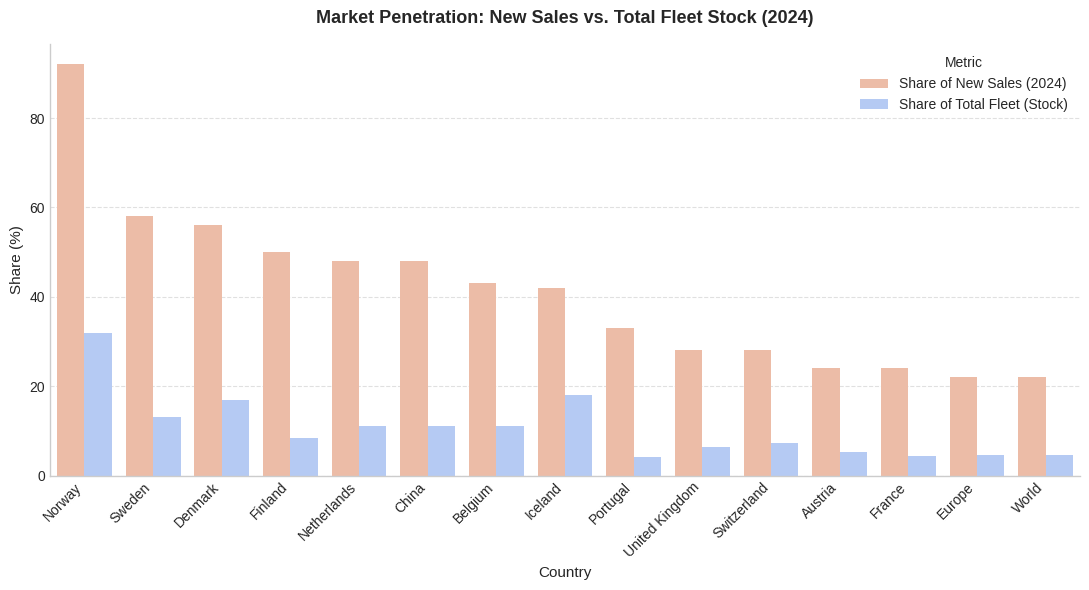


Generating Plot 3.2: Market Share Leaders Over Time...


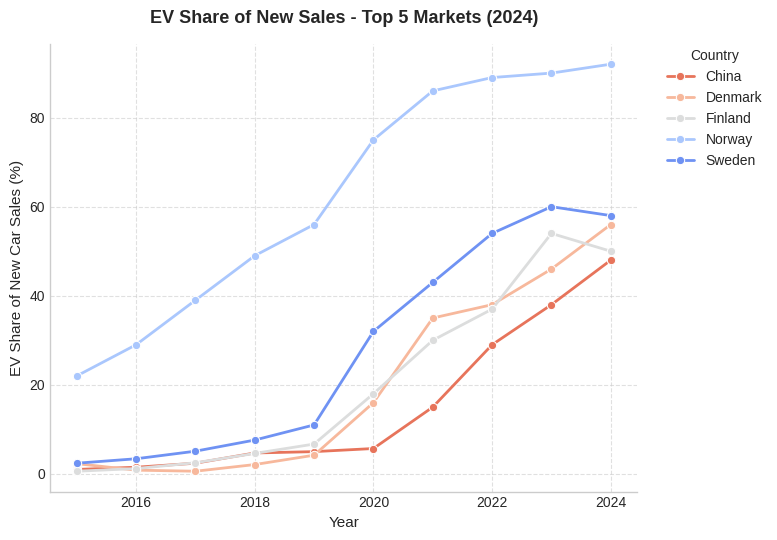


Generating Plot 3.3: Acceleration Scatter Plot (Share Year N vs. N-1)...


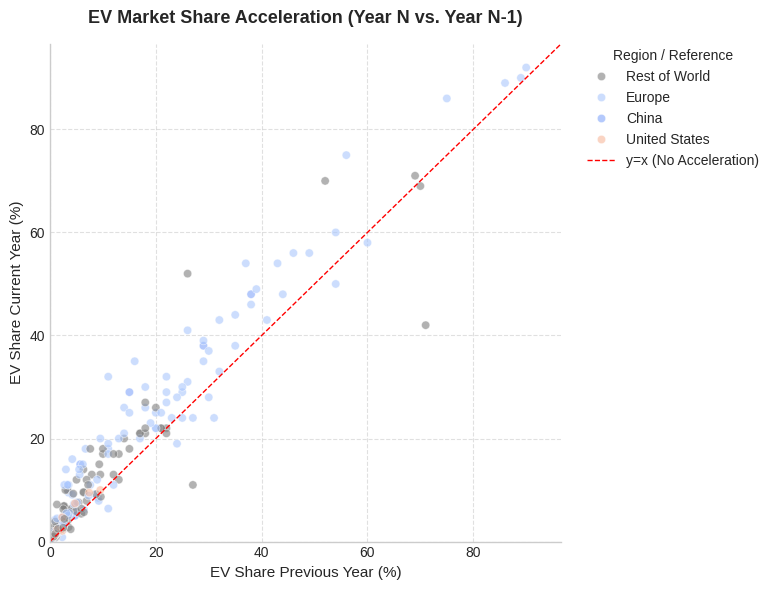


Generating Plot 3.4: EV Share Growth Rate Trend...


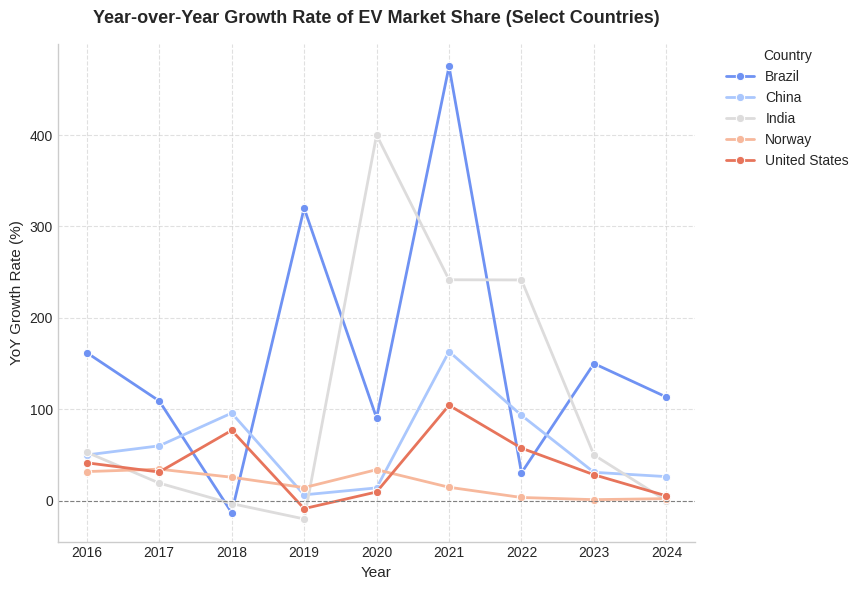


Generating Plot 3.5: EV Stock Share Trend (Penetration)...


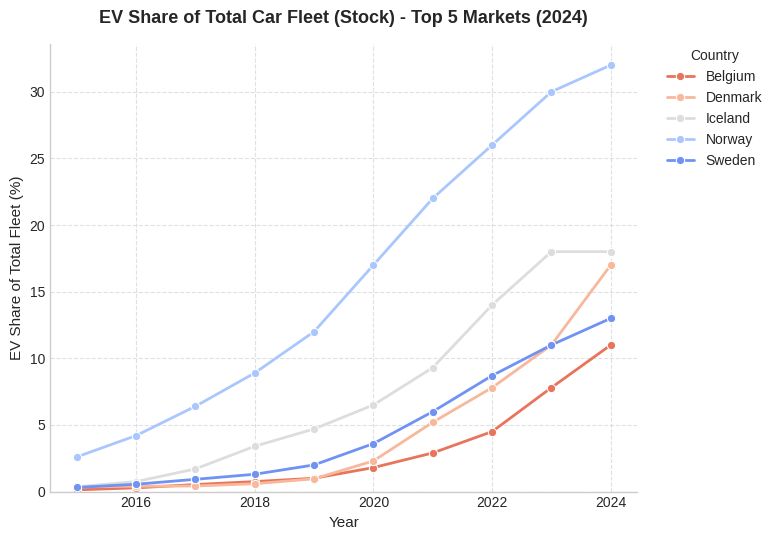

In [ ]:
# Angle 3 Plots: Market Acceleration/Saturation Focus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# --- Setup ---
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
palette_angle3 = sns.color_palette("coolwarm", 8) # Coolwarm palette for growth/change
final_merged_file = 'final_merged_ev_dataset_annual.csv'
print(f"--- Loading Data for Angle 3 Plots ---")

try:
    if not os.path.exists(final_merged_file): raise FileNotFoundError(f"'{final_merged_file}' needed.")
    df = pd.read_csv(final_merged_file)
    print(f"Loaded {final_merged_file}")

     # Add Region Mapping (simplified)
    def assign_region_group(country):
        if country == 'China': return 'China'
        if country == 'United States': return 'United States'
        europe_list = ['Norway', 'Germany', 'France', 'United Kingdom', 'Netherlands', 'Sweden', 'Italy', 'Spain', 'Belgium', 'Austria', 'Switzerland', 'Denmark', 'Finland', 'Ireland', 'Portugal']
        if country in europe_list: return 'Europe'
        return 'Rest of World'
    df['region_group'] = df['country'].apply(assign_region_group)
    region_palette = {'China': palette_angle3[1], 'Europe': palette_angle3[2], 'United States': palette_angle3[5], 'Rest of World': 'grey'}

    # Determine year range
    min_year_data = int(df['year'].min())
    max_year_data = int(df['year'].max())
    start_year_plot = max(2015, min_year_data)
    end_year_plot = max_year_data
    df_plot_range = df[(df['year'] >= start_year_plot) & (df['year'] <= end_year_plot)].copy()
    latest_year = end_year_plot
    df_latest = df[df['year'] == latest_year].copy()

    # --- Column names ---
    sales_share_col = 'share_of_new_cars_that_are_electric'
    stock_share_col = 'share_of_car_stocks_that_are_electric'

    # --- Plot 3.1: New Sales Share % vs. Total Fleet Stock % ---
    print("\nGenerating Plot 3.1: New Sales Share vs. Total Fleet Stock...")
    if sales_share_col in df.columns and stock_share_col in df.columns and not df_latest.empty:
        countries_for_stock = df_latest.nlargest(15, sales_share_col)['country'].tolist()
        df_stock_comp = df_latest[df_latest['country'].isin(countries_for_stock)].copy()
        df_stock_melted = df_stock_comp.melt(id_vars='country', value_vars=[sales_share_col, stock_share_col], var_name='Share Type', value_name='Share (%)').dropna(subset=['Share (%)'])
        df_stock_melted['Share Type'] = df_stock_melted['Share Type'].map({ sales_share_col: f'Share of New Sales ({latest_year})', stock_share_col: 'Share of Total Fleet (Stock)' })
        country_order = df_latest[df_latest['country'].isin(countries_for_stock)].sort_values(sales_share_col, ascending=False)['country']
        plt.figure(figsize=(11, 6))
        sns.barplot(data=df_stock_melted, x='country', y='Share (%)', hue='Share Type', palette=[palette_angle3[5], palette_angle3[2]], order=country_order) # Use coolwarm shades
        plt.title(f'Market Penetration: New Sales vs. Total Fleet Stock ({latest_year})', fontsize=13, weight='bold', pad=15)
        plt.xlabel('Country', fontsize=11); plt.ylabel('Share (%)', fontsize=11)
        plt.xticks(rotation=45, ha='right', fontsize=10); plt.legend(title='Metric')
        plt.grid(True, axis='y', linestyle='--', alpha=0.6); sns.despine()
        plt.tight_layout()
        plt.show()
    elif df_latest.empty: print(f"Skipping Plot 3.1: No data for {latest_year}.")
    else: print("Skipping Plot 3.1: Required columns not found.")

    # --- Plot 3.2: Market Share Leaders Over Time ---
    print("\nGenerating Plot 3.2: Market Share Leaders Over Time...")
    if sales_share_col in df_plot_range.columns and not df_latest.empty:
        top_countries = df_latest.nlargest(5, sales_share_col)['country'].tolist()
        df_top_trend = df_plot_range[df_plot_range['country'].isin(top_countries)]
        plt.figure(figsize=(9, 5.5))
        sns.lineplot(data=df_top_trend, x='year', y=sales_share_col, hue='country', marker='o', linewidth=2, palette='coolwarm_r', markersize=6) # Use coolwarm reversed
        plt.title(f'EV Share of New Sales - Top 5 Markets ({latest_year})', fontsize=13, weight='bold', pad=15)
        plt.xlabel('Year', fontsize=11); plt.ylabel('EV Share of New Car Sales (%)', fontsize=11)
        plt.legend(title='Country', bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.)
        plt.grid(True, linestyle='--', alpha=0.6); sns.despine()
        plt.tight_layout(rect=[0, 0, 0.88, 1])
        plt.show()
    elif df_latest.empty: print(f"Skipping Plot 3.2: No data for {latest_year}.")
    else: print("Skipping Plot 3.2: Required columns not found.")

    # --- Plot 3.3: Acceleration Scatter Plot ---
    print("\nGenerating Plot 3.3: Acceleration Scatter Plot (Share Year N vs. N-1)...")
    if sales_share_col in df_plot_range.columns:
        df_accel = df_plot_range[['country', 'year', sales_share_col, 'region_group']].copy()
        df_accel = df_accel.sort_values(by=['country', 'year'])
        df_accel['prev_year_share'] = df_accel.groupby('country')[sales_share_col].shift(1)
        df_accel_plot = df_accel.dropna(subset=[sales_share_col, 'prev_year_share'])
        # Filter for shares > 0.1% to avoid noise at the beginning
        df_accel_plot = df_accel_plot[(df_accel_plot[sales_share_col] > 0.1) & (df_accel_plot['prev_year_share'] > 0.1)]

        if not df_accel_plot.empty:
            plt.figure(figsize=(9, 6))
            max_val = df_accel_plot[[sales_share_col, 'prev_year_share']].max().max() * 1.05 # Find max for axes limits
            sns.scatterplot(data=df_accel_plot, x='prev_year_share', y=sales_share_col,
                            hue='region_group', palette=region_palette, alpha=0.6)
            # Add y=x line for reference (points above = acceleration)
            plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=1, label='y=x (No Acceleration)')
            plt.title('EV Market Share Acceleration (Year N vs. Year N-1)', fontsize=13, weight='bold', pad=15)
            plt.xlabel('EV Share Previous Year (%)', fontsize=11); plt.ylabel('EV Share Current Year (%)', fontsize=11)
            plt.xlim(0, max_val); plt.ylim(0, max_val)
            plt.legend(title='Region / Reference', bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.)
            plt.grid(True, linestyle='--', alpha=0.6); sns.despine()
            plt.tight_layout(rect=[0, 0, 0.88, 1])
            plt.show()
        else: print("Skipping Plot 3.3: Not enough data points for acceleration plot.")
    else: print("Skipping Plot 3.3: Missing required columns.")

    # --- Plot 3.4: EV Share Growth Rate Trend ---
    print("\nGenerating Plot 3.4: EV Share Growth Rate Trend...")
    if sales_share_col in df_plot_range.columns:
         # Use data from previous plot calculation
         df_accel['ev_share_growth_pct'] = df_accel.groupby('country')[sales_share_col].pct_change() * 100
         # Replace infinite values (growth from 0) with NaN or a large number if needed, cap extreme growth?
         df_accel.replace([np.inf, -np.inf], np.nan, inplace=True)
         # Select example countries
         leader_examples = ['Norway', 'China']
         emerging_examples = ['India', 'Brazil', 'United States'] # Add examples relevant to your data
         growth_countries = [c for c in leader_examples + emerging_examples if c in df_accel['country'].unique()]
         df_growth_plot = df_accel[df_accel['country'].isin(growth_countries)].dropna(subset=['ev_share_growth_pct'])
         # Cap extreme growth for visual clarity? Optional.
         # growth_cap = 500 # Example: Cap at 500% growth
         # df_growth_plot['ev_share_growth_pct'] = df_growth_plot['ev_share_growth_pct'].clip(upper=growth_cap)

         if not df_growth_plot.empty:
              plt.figure(figsize=(10, 6))
              sns.lineplot(data=df_growth_plot, x='year', y='ev_share_growth_pct', hue='country',
                           marker='o', linewidth=2, palette='coolwarm', markersize=6)
              plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Line at 0% growth
              plt.title('Year-over-Year Growth Rate of EV Market Share (Select Countries)', fontsize=13, weight='bold', pad=15)
              plt.xlabel('Year', fontsize=11); plt.ylabel('YoY Growth Rate (%)', fontsize=11)
              # Optional: Set y-limit if capping growth rate
              # plt.ylim(-100, growth_cap * 1.1 if 'growth_cap' in locals() else None)
              plt.legend(title='Country', bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.)
              plt.grid(True, linestyle='--', alpha=0.6); sns.despine()
              plt.tight_layout(rect=[0, 0, 0.88, 1])
              plt.show()
         else: print("Skipping Plot 3.4: Not enough data to calculate growth rates for examples.")
    else: print("Skipping Plot 3.4: Missing required columns.")

    # --- Plot 3.5: EV Stock Share Trend (Penetration) ---
    print("\nGenerating Plot 3.5: EV Stock Share Trend (Penetration)...")
    if stock_share_col in df_plot_range.columns:
         # Select leading countries based on LATEST stock share
         if stock_share_col in df_latest.columns:
              top_stock_countries = df_latest.nlargest(5, stock_share_col)['country'].tolist()
         else: # Fallback to using sales share leaders if latest stock share is missing
              top_stock_countries = df_latest.nlargest(5, sales_share_col)['country'].tolist()

         df_stock_trend = df_plot_range[df_plot_range['country'].isin(top_stock_countries)].dropna(subset=[stock_share_col])

         if not df_stock_trend.empty:
              plt.figure(figsize=(9, 5.5))
              sns.lineplot(data=df_stock_trend, x='year', y=stock_share_col, hue='country',
                           marker='o', linewidth=2, palette='coolwarm_r', markersize=6) # Use coolwarm reversed
              plt.title(f'EV Share of Total Car Fleet (Stock) - Top 5 Markets ({latest_year})', fontsize=13, weight='bold', pad=15)
              plt.xlabel('Year', fontsize=11); plt.ylabel('EV Share of Total Fleet (%)', fontsize=11)
              plt.ylim(bottom=0)
              plt.legend(title='Country', bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.)
              plt.grid(True, linestyle='--', alpha=0.6); sns.despine()
              plt.tight_layout(rect=[0, 0, 0.88, 1])
              plt.show()
         else: print("Skipping Plot 3.5: No valid stock share data found for top countries.")
    else: print("Skipping Plot 3.5: Stock share column not found.")


except FileNotFoundError as e: print(f"Error loading data: {e}")
except KeyError as e: print(f"Error: Missing expected column: {e}")
except Exception as e: print(f"An unexpected error occurred: {e}")

# **WORLD MAP**

In [ ]:
# IMPORTANT: Ensure plotly and geopandas are installed first!
# Run: !pip install plotly pandas geopandas

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go # For more layout control
import warnings
import os

# --- Setup ---
warnings.filterwarnings('ignore')
final_merged_file = 'final_merged_ev_dataset_annual.csv' # Your merged data file
print(f"--- Loading Data for Refined Plotly World Map Plot ---")

try:
    # --- Load and Prepare Data ---
    if not os.path.exists(final_merged_file):
        print(f"Error: '{final_merged_file}' not found.")
        raise FileNotFoundError

    df = pd.read_csv(final_merged_file)
    print(f"Loaded merged data: {final_merged_file} (Shape: {df.shape})")

    # --- Column name definitions ---
    sales_vol_col = 'electric_cars_sold'
    country_code_col = 'code' # Assumes ISO 3-letter code column
    country_name_col = 'country' # Country name column
    year_col = 'year'

    # Determine latest year WITH electric_cars_sold data
    df_with_sales = df.dropna(subset=[sales_vol_col])
    if df_with_sales.empty:
         print(f"Error: No data found for '{sales_vol_col}'. Cannot create map.")
         raise ValueError("Missing essential sales volume data for mapping.")

    latest_year = int(df_with_sales[year_col].max())
    df_latest = df[df[year_col] == latest_year].copy()
    print(f"Filtering data for latest year with sales volume data: {latest_year}")

    # --- Check required columns ---
    if sales_vol_col not in df_latest.columns:
        print(f"Error: Column '{sales_vol_col}' not found.")
        raise ValueError(f"Missing '{sales_vol_col}' column.")
    if not any(col in df_latest.columns and df_latest[col].notna().any() for col in [country_code_col, country_name_col]):
         print(f"Error: Neither '{country_code_col}' nor '{country_name_col}' found or contain valid data for location mapping.")
         raise ValueError("Missing country identifier column.")
    else:
        # --- Create Discrete Bins and Assign Colors ---
        print("\nGenerating Plotly World Map Plot (Corrected Binning)...")

        # Choose the location identifier
        location_col = country_code_col if country_code_col in df_latest.columns and df_latest[country_code_col].notna().any() and df_latest[country_code_col].nunique() > 1 else country_name_col
        location_mode = 'ISO-3' if location_col == country_code_col else 'country names'
        print(f"Using '{location_col}' ({location_mode}) for locations.")

        # Prepare data: keep only valid locations
        df_latest_map = df_latest.dropna(subset=[location_col]).copy()

        # Define thresholds and colors matching the image legend (approximate hex)
        thresholds = [0, 100_000, 200_000, 500_000, 1_000_000, 2_000_000, 5_000_000, 10_000_000]
        colors = [
            "#FFE8D6", "#FFC69E", "#FFA775", "#FF894D", "#FF6A24", "#F04D00", "#D93F00", "#C23100"
        ]
        no_data_color = 'rgb(220, 220, 220)' # Light grey for no data

        # Define legend labels corresponding ONLY to the actual data bins first
        legend_labels_data = [
             '0 - 100,000', '100,000 - 200,000', '200,000 - 500,000',
             '500,000 - 1 million', '1 million - 2 million', '2 million - 5 million',
             '5 million - 10 million', '10 million+'
        ]
        # Full list including 'No data' for legend ordering
        legend_labels_full = ['No data'] + legend_labels_data

        # --- Corrected Binning and Labeling ---
        # Define bins for pd.cut (excluding -inf for this step)
        # Use np.inf for the upper bound of the last bin
        bins_for_cut = thresholds + [np.inf] # 9 edges for 8 intervals

        # Create the 'Legend Label' column initialized to 'No data'
        df_latest_map['Legend Label'] = 'No data'

        # Apply cut ONLY to rows that HAVE sales data
        has_sales_mask = df_latest_map[sales_vol_col].notna()
        if has_sales_mask.any(): # Proceed only if there's some sales data
            df_latest_map.loc[has_sales_mask, 'Legend Label'] = pd.cut(
                df_latest_map.loc[has_sales_mask, sales_vol_col],
                bins=bins_for_cut,
                labels=legend_labels_data, # Use the 8 data labels
                right=False # Intervals are [min, max)
            )
            # Ensure the column type is suitable (convert potential Categorical back to object/string if needed before fillna, although fillna might handle it)
            # df_latest_map['Legend Label'] = df_latest_map['Legend Label'].astype(str).replace('nan', 'No data') # Alternative if fillna fails on Categorical

        # --- End Corrected Binning ---

        # Create the discrete color map for Plotly using the full list of labels
        color_map = {label: color for label, color in zip(legend_labels_full, [no_data_color] + colors)}


        # --- Create the Choropleth Map using DISCRETE color ---
        if df_latest_map.empty:
            print("Warning: No valid data points remain for mapping.")
        else:
            print(f"Plotting {len(df_latest_map)} countries/regions.")
            fig = px.choropleth(
                df_latest_map,
                locations=location_col,
                locationmode=location_mode,
                color='Legend Label',           # Use the final readable labels for color mapping
                color_discrete_map=color_map,   # Map these labels to the colors
                category_orders={'Legend Label': legend_labels_full}, # Ensure legend order matches labels
                hover_name=country_name_col,
                hover_data={
                    sales_vol_col: ':,', # Format sales number with comma
                    'Legend Label': False # Hide this mapped label column from hover
                },
                labels={sales_vol_col:'Cars Sold'} # Label shown in hover data title
            )

            # Update layout for a cleaner, report-like style and LEGEND
            fig.update_layout(
                title_text=f'<b>Number of new electric cars sold, {latest_year}</b>',
                title_font_size=16,
                title_x=0.5, # Center title
                geo=dict(
                    bgcolor='rgba(0,0,0,0)',
                    showframe=False,
                    showcoastlines=True, coastlinewidth=0.5, coastlinecolor="DarkGrey",
                    showland=True, landcolor="rgb(235, 235, 235)", # Slightly lighter land
                    subunitcolor="rgb(255, 255, 255)", # White country borders
                    projection_type='natural earth', # Map projection
                    lataxis_range=[-60, 85], # Adjust latitude range slightly
                    lonaxis_range=[-180, 180]
                ),
                # --- Configure Legend ---
                legend=dict(
                    title='Number of new electric cars sold',
                    orientation="h", # Horizontal legend
                    yanchor="bottom", y=-0.05, # Position below the map frame (adjust y if needed)
                    xanchor="center", x=0.5, # Center horizontally
                    bgcolor="rgba(255,255,255,0.8)", # Semi-transparent background
                    bordercolor="rgba(0,0,0,0.5)",
                    borderwidth=1,
                    font=dict(size=10),
                    traceorder='normal' # Order based on category_orders
                ),
                margin={"r":0,"t":40,"l":0,"b":40}, # Added bottom margin for legend
                height=650 # Adjust height if needed
            )

            # --- Display the Plot ---
            fig.show()
            print("\n--- Plotly World Map Plot Generated (Corrected Binning V2) ---")

except FileNotFoundError:
    print(f"Error: Required data file '{final_merged_file}' not found.")
except ImportError:
    print("\nError: Plotly or Geopandas library not found.")
    print("Please install them in your Colab environment first by running:")
    print("!pip install plotly pandas geopandas")
except ValueError as ve:
     print(f"Error during map generation: {ve}") # Specific errors like missing data
except Exception as e:
    print(f"An unexpected error occurred during map visualization: {e}")

--- Loading Data for Refined Plotly World Map Plot ---
Loaded merged data: final_merged_ev_dataset_annual.csv (Shape: (340, 14))
Filtering data for latest year with sales volume data: 2024

Generating Plotly World Map Plot (Corrected Binning)...
Using 'code' (ISO-3) for locations.
Plotting 34 countries/regions.



--- Plotly World Map Plot Generated (Corrected Binning V2) ---


# **EXTRA**

--- Step 6 (Set 1): Storytelling Visualizations Inspired by IEA Report ---
Loaded merged data: final_merged_ev_dataset_annual.csv (Shape: (340, 14))
Region mapping added.
Generating Plot 1: Global EV Sales Growth...
Generating Plot 2: Market Share Leaders Trend...
Generating Plot 3: BEV vs. PHEV Share Trend...
Skipping Plot 3: Required columns for BEV/PHEV analysis not found.
Generating Plot 4: Regional EV Share Comparison...
Generating Plot 5: Sales Share vs. Stock Share...
Generating Plot 6: EV Share vs. Gasoline Price Relationship...
Generating Plot 7: Global EV Share vs. Global Oil Prices...
Generating Plot 8: EV Share vs. Policy Count Groups...

--- Storytelling Plots (Set 1) Generated ---


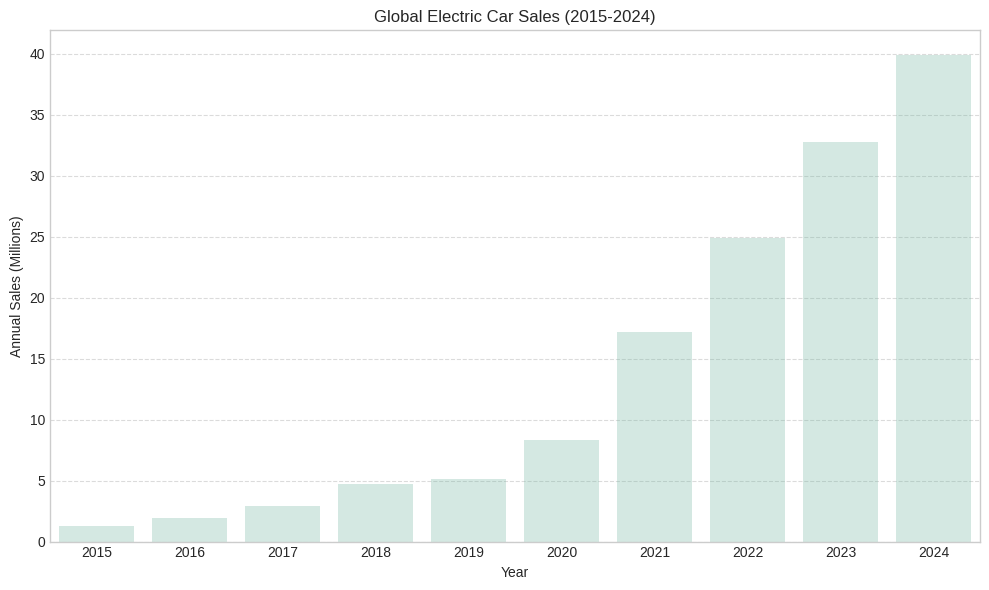

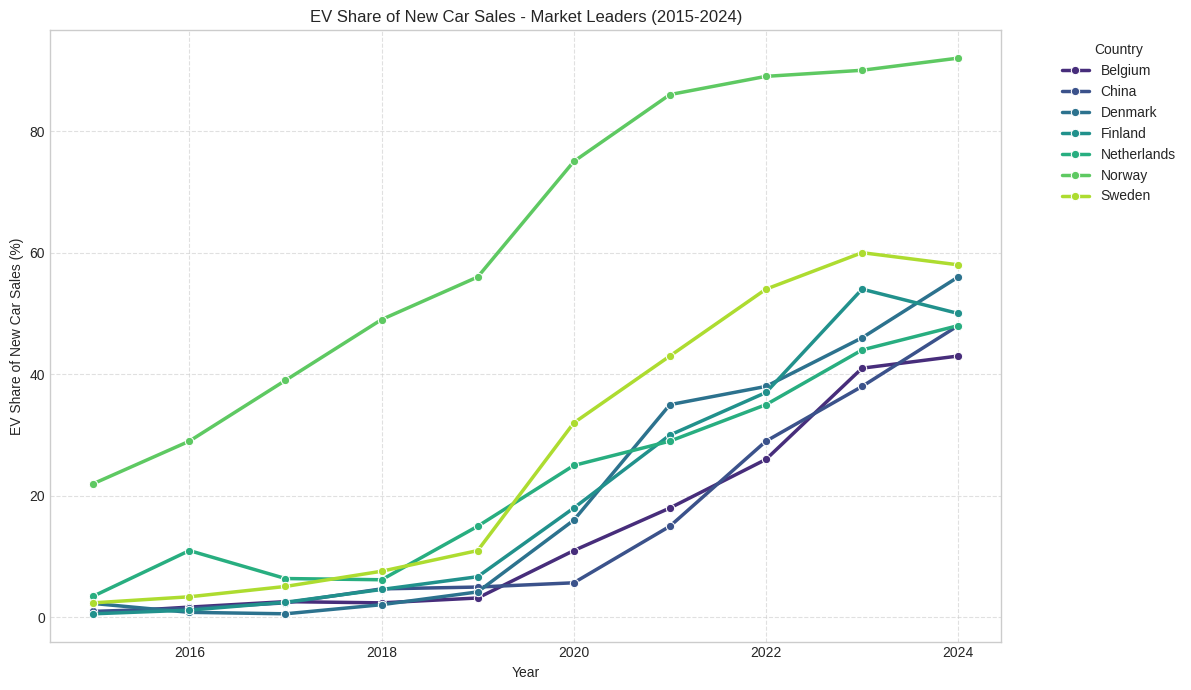

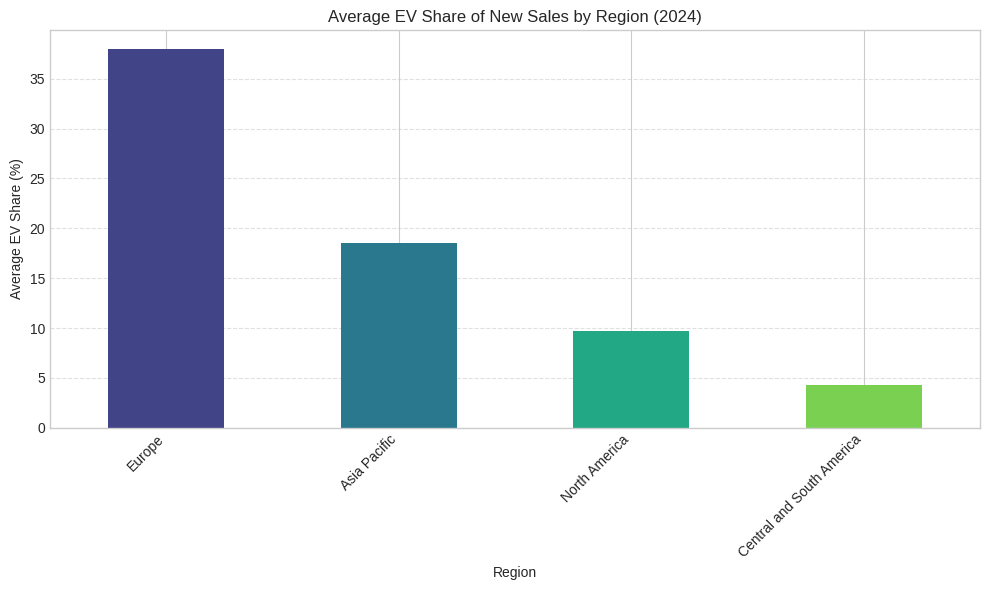

<Figure size 1000x700 with 0 Axes>

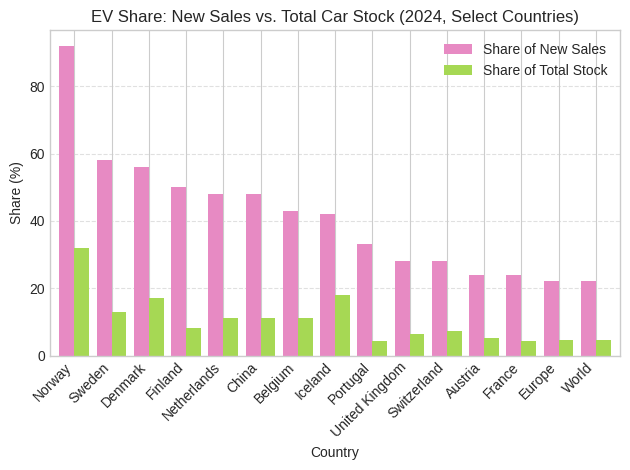

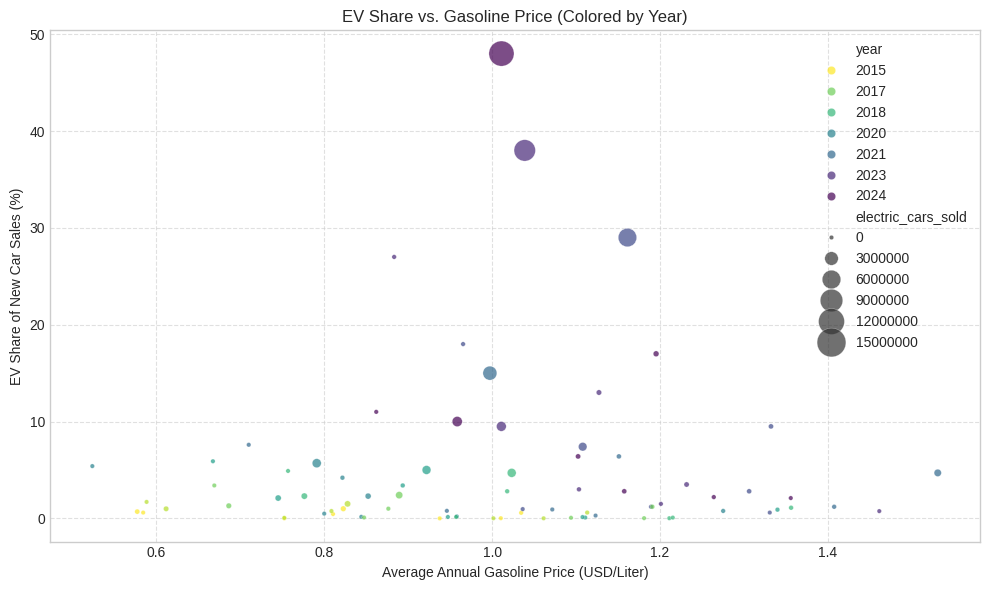

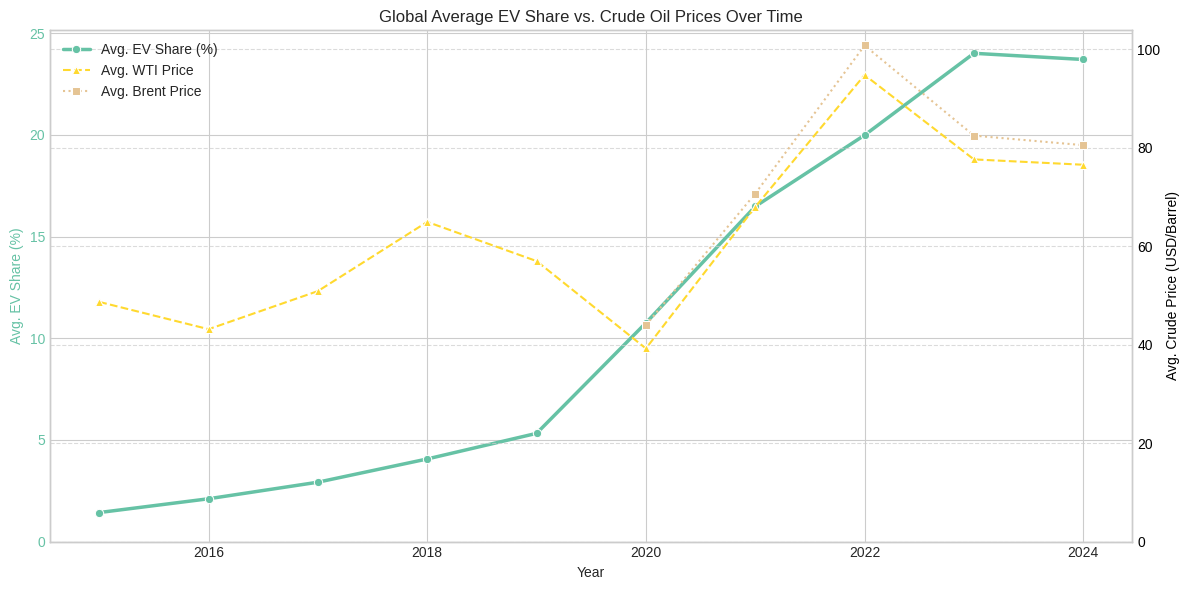

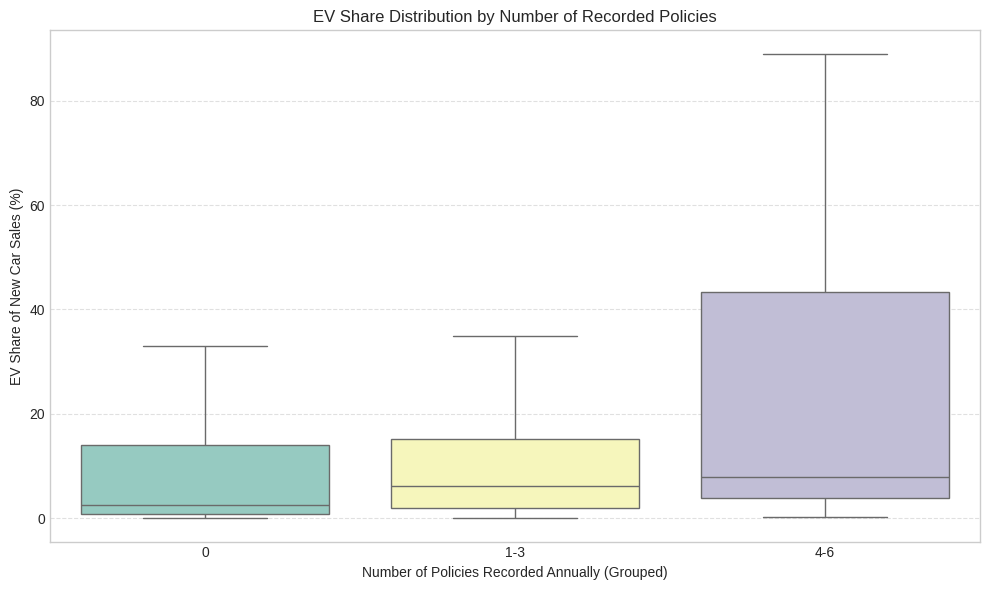

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# --- File Paths ---
final_merged_file = 'final_merged_ev_dataset_annual.csv'
policy_raw_file = 'combined_policy_data_raw.csv' # For region mapping

print(f"--- Step 6 (Set 1): Storytelling Visualizations Inspired by IEA Report ---")

try:
    # Load the primary merged dataset
    df = pd.read_csv(final_merged_file)
    print(f"Loaded merged data: {final_merged_file} (Shape: {df.shape})")

    # Load raw policy data for region mapping
    regions_available = False
    try:
        df_policy = pd.read_csv(policy_raw_file)
        country_to_region = df_policy[['country', 'region']].drop_duplicates('country').set_index('country')['region']
        df['region'] = df['country'].map(country_to_region).fillna('Unknown')
        print("Region mapping added.")
        regions_available = True
    except Exception as e:
         print(f"Warning: Could not load or process policy file for region mapping: {e}.")
         df['region'] = 'Unknown'

    latest_year = df['year'].max()
    plt.style.use('seaborn-v0_8-whitegrid')
    report_palette = sns.color_palette("Set2")

    # --- Plot 1: Global EV Sales Growth ---
    print("Generating Plot 1: Global EV Sales Growth...")
    if 'electric_cars_sold' in df.columns:
        df_global_sales = df.groupby('year')['electric_cars_sold'].sum().reset_index()
        df_global_sales['electric_cars_sold_millions'] = df_global_sales['electric_cars_sold'] / 1_000_000
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df_global_sales, x='year', y='electric_cars_sold_millions', marker='o', linewidth=2.5, color=report_palette[0])
        sns.barplot(data=df_global_sales, x='year', y='electric_cars_sold_millions', color=report_palette[0], alpha=0.3)
        plt.title(f'Global Electric Car Sales (2015-{latest_year})')
        plt.xlabel('Year')
        plt.ylabel('Annual Sales (Millions)')
        plt.ylim(bottom=0)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
    else: print("Skipping Plot 1: 'electric_cars_sold' not found.")

    # --- Plot 2: Market Share Leaders Over Time ---
    print("Generating Plot 2: Market Share Leaders Trend...")
    if 'share_of_new_cars_that_are_electric' in df.columns:
        top_countries = df[df['year']==latest_year].nlargest(7, 'share_of_new_cars_that_are_electric')['country'].tolist()
        df_trend_leaders = df[df['country'].isin(top_countries) & (df['year'] >= 2015)]
        plt.figure(figsize=(12, 7))
        sns.lineplot(data=df_trend_leaders, x='year', y='share_of_new_cars_that_are_electric', hue='country', marker='o', linewidth=2.5, palette='viridis')
        plt.title(f'EV Share of New Car Sales - Market Leaders (2015-{latest_year})')
        plt.xlabel('Year')
        plt.ylabel('EV Share of New Car Sales (%)')
        plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
    else: print("Skipping Plot 2: 'share_of_new_cars_that_are_electric' not found.")


    # --- Plot 3: BEV vs. PHEV Share of EV Sales (Global Average Trend) ---
    print("Generating Plot 3: BEV vs. PHEV Share Trend...")
    if 'battery_electric_as_a_share_of_electric_cars_sold' in df.columns and 'electric_cars_sold' in df.columns:
        df['bev_sales'] = df['electric_cars_sold'] * (df['battery_electric_as_a_share_of_electric_cars_sold'] / 100.0)
        df_global_powertrain = df.groupby('year')[['electric_cars_sold', 'bev_sales']].sum().reset_index()
        df_global_powertrain['phev_sales'] = df_global_powertrain['electric_cars_sold'] - df_global_powertrain['bev_sales']
        # Avoid division by zero if total sales are 0
        df_global_powertrain['bev_share_of_ev_sales'] = (df_global_powertrain['bev_sales'] / df_global_powertrain['electric_cars_sold'].replace(0, np.nan)) * 100
        df_global_powertrain['phev_share_of_ev_sales'] = (df_global_powertrain['phev_sales'] / df_global_powertrain['electric_cars_sold'].replace(0, np.nan)) * 100
        df_global_powertrain.fillna(0, inplace=True) # Fill NaNs resulting from division by zero

        plt.figure(figsize=(10, 6))
        plt.stackplot(df_global_powertrain['year'],
                      df_global_powertrain['bev_share_of_ev_sales'],
                      df_global_powertrain['phev_share_of_ev_sales'],
                      labels=['BEV Share (%)', 'PHEV Share (%)'],
                      colors=[report_palette[1], report_palette[2]], alpha=0.8)
        plt.title(f'Global Powertrain Mix of Electric Car Sales (2015-{latest_year})')
        plt.xlabel('Year')
        plt.ylabel('Share of Total EV Sales (%)')
        plt.legend(loc='upper left')
        plt.ylim(0, 100)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
    else: print("Skipping Plot 3: Required columns for BEV/PHEV analysis not found.")

    # --- Plot 4: Regional Comparison - EV Share (Latest Year) ---
    print("Generating Plot 4: Regional EV Share Comparison...")
    if regions_available and 'share_of_new_cars_that_are_electric' in df.columns:
        regional_avg = df[df['year'] == latest_year].groupby('region')['share_of_new_cars_that_are_electric'].mean().sort_values(ascending=False).dropna()
        regional_avg = regional_avg[regional_avg.index != 'Unknown']
        plt.figure(figsize=(10, 6))
        regional_avg.plot(kind='bar', color=sns.color_palette('viridis', len(regional_avg)))
        plt.title(f'Average EV Share of New Sales by Region ({latest_year})')
        plt.xlabel('Region')
        plt.ylabel('Average EV Share (%)')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
    else: print("Skipping Plot 4: Region information or EV share column not available.")

    # --- Plot 5: Sales Share vs. Stock Share (Select Countries, Latest Year) ---
    print("Generating Plot 5: Sales Share vs. Stock Share...")
    stock_col = 'share_of_car_stocks_that_are_electric'
    sales_col = 'share_of_new_cars_that_are_electric'
    if sales_col in df.columns and stock_col in df.columns:
        countries_for_stock = df[df['year']==latest_year].nlargest(15, sales_col)['country'].tolist()
        df_stock_comp = df[(df['year'] == latest_year) & df['country'].isin(countries_for_stock)].copy()
        df_stock_comp = df_stock_comp[['country', sales_col, stock_col]].set_index('country')
        df_stock_comp = df_stock_comp.sort_values(sales_col, ascending=False)
        plt.figure(figsize=(10, 7)) # Create figure explicitly for pandas plot
        ax = df_stock_comp.plot(kind='bar', color=[report_palette[3], report_palette[4]], width=0.8)
        plt.title(f'EV Share: New Sales vs. Total Car Stock ({latest_year}, Select Countries)')
        plt.xlabel('Country')
        plt.ylabel('Share (%)')
        plt.xticks(rotation=45, ha='right')
        plt.legend(['Share of New Sales', 'Share of Total Stock'])
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        # plt.close() # Don't close so it displays
    else: print("Skipping Plot 5: Required stock/sales share columns not found.")

    # --- Plot 6: EV Adoption vs. Gasoline Price (Focus on Relationship) ---
    print("Generating Plot 6: EV Share vs. Gasoline Price Relationship...")
    gas_col = 'gasoline_price_usd_liter'
    if sales_col in df.columns and gas_col in df.columns:
        plt.figure(figsize=(10, 6))
        size_col = 'electric_cars_sold' if 'electric_cars_sold' in df.columns else None
        sizes = (10, 500) if size_col else None
        sns.scatterplot(data=df, x=gas_col, y=sales_col, hue='year',
                        size=size_col, sizes=sizes, palette='viridis_r', alpha=0.7,
                        legend='auto' if size_col else 'brief')
        plt.title('EV Share vs. Gasoline Price (Colored by Year)')
        plt.xlabel('Average Annual Gasoline Price (USD/Liter)')
        plt.ylabel('EV Share of New Car Sales (%)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
    else: print("Skipping Plot 6: EV share or gasoline price column not found.")

    # --- Plot 7: Global EV Share vs. Global Oil Prices ---
    print("Generating Plot 7: Global EV Share vs. Global Oil Prices...")
    wti_col = 'WTI_Price_USD_Barrel'
    brent_col = 'Brent_Price_USD_Barrel'
    if sales_col in df.columns and wti_col in df.columns and brent_col in df.columns:
        global_trends_oil = df.groupby('year')[[sales_col, wti_col, brent_col]].mean().reset_index()
        plt.figure(figsize=(12, 6))
        ax1 = plt.gca()
        sns.lineplot(data=global_trends_oil, x='year', y=sales_col, marker='o', ax=ax1, color=report_palette[0], label='Avg. EV Share (%)', linewidth=2.5)
        ax1.set_ylabel('Avg. EV Share (%)', color=report_palette[0])
        ax1.tick_params(axis='y', labelcolor=report_palette[0]); ax1.set_xlabel('Year')
        ax1.set_title('Global Average EV Share vs. Crude Oil Prices Over Time')
        ax1.set_ylim(bottom=0)
        ax2 = ax1.twinx()
        sns.lineplot(data=global_trends_oil, x='year', y=wti_col, marker='^', ax=ax2, color=report_palette[5], label='Avg. WTI Price', linestyle='--')
        sns.lineplot(data=global_trends_oil, x='year', y=brent_col, marker='s', ax=ax2, color=report_palette[6], label='Avg. Brent Price', linestyle=':')
        ax2.set_ylabel('Avg. Crude Price (USD/Barrel)', color='black')
        ax2.tick_params(axis='y', labelcolor='black'); ax2.set_ylim(bottom=0)
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left'); ax1.get_legend().remove()
        plt.grid(True, linestyle='--', alpha=0.7); plt.tight_layout()
    else: print("Skipping Plot 7: Missing EV share or oil price columns.")

    # --- Plot 8: EV Share vs. Policy Count (Grouped Boxplot) ---
    print("Generating Plot 8: EV Share vs. Policy Count Groups...")
    policy_col = 'policy_count'
    if sales_col in df.columns and policy_col in df.columns:
        max_policies = int(df[policy_col].max())
        bins = [-1, 0, 5, 10, max(max_policies, 11)] # Ensure max bin covers max policies
        labels = ['0', '1-5', '6-10', '11+']
        if max_policies < 11:
            bins = [-1, 0, 3, max_policies]
            labels = ['0', '1-3', f'4-{max_policies}'] if max_policies >= 4 else ['0','1-3']
        if max_policies < 4:
             bins = [-1, 0, max_policies]
             labels = ['0', f'1-{max_policies}'] if max_policies >=1 else ['0']

        # Ensure labels match bins length and handle cases with low max_policies
        if len(bins) - 1 != len(labels):
             print(f"Warning: Bin/label mismatch for policy groups (Bins: {bins}, Labels: {labels}). Adjusting labels.")
             labels = [f"Group {i+1}" for i in range(len(bins)-1)] # Generic labels


        df['policy_group'] = pd.cut(df[policy_col], bins=bins, labels=labels, right=True)
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df.dropna(subset=['policy_group']), x='policy_group', y=sales_col, palette='Set3', showfliers=False)
        plt.title('EV Share Distribution by Number of Recorded Policies')
        plt.xlabel('Number of Policies Recorded Annually (Grouped)')
        plt.ylabel('EV Share of New Car Sales (%)')
        plt.grid(True, axis='y', linestyle='--', alpha=0.6); plt.tight_layout()
    else: print("Skipping Plot 8: Missing EV share or policy count columns.")


    print("\n--- Storytelling Plots (Set 1) Generated ---")

except FileNotFoundError:
    print(f"Error: Required data file not found.")
except KeyError as ke:
    print(f"Error: A required column was not found. Check column names. Details: {ke}")
except Exception as e:
    print(f"An error occurred during visualization: {e}")

# Plots 1-8 will display after this block.

--- Step 6 (Set 2): Deeper Dive Visualizations ---
Loaded merged data: final_merged_ev_dataset_annual.csv (Shape: (340, 14))
Generating Plot 9: Stock Share vs. Sales Share...
Generating Plot 10: BEV Dominance vs. Overall EV Share...
Skipping Plot 10: Required BEV share or EV share columns not found.
Generating Plot 11: Country Trajectories (EV Share vs. Gas Price)...
Generating Plot 12: Global EV Growth Rate vs. Oil Price Change...

--- Deeper Dive Plots (Set 2) Generated ---


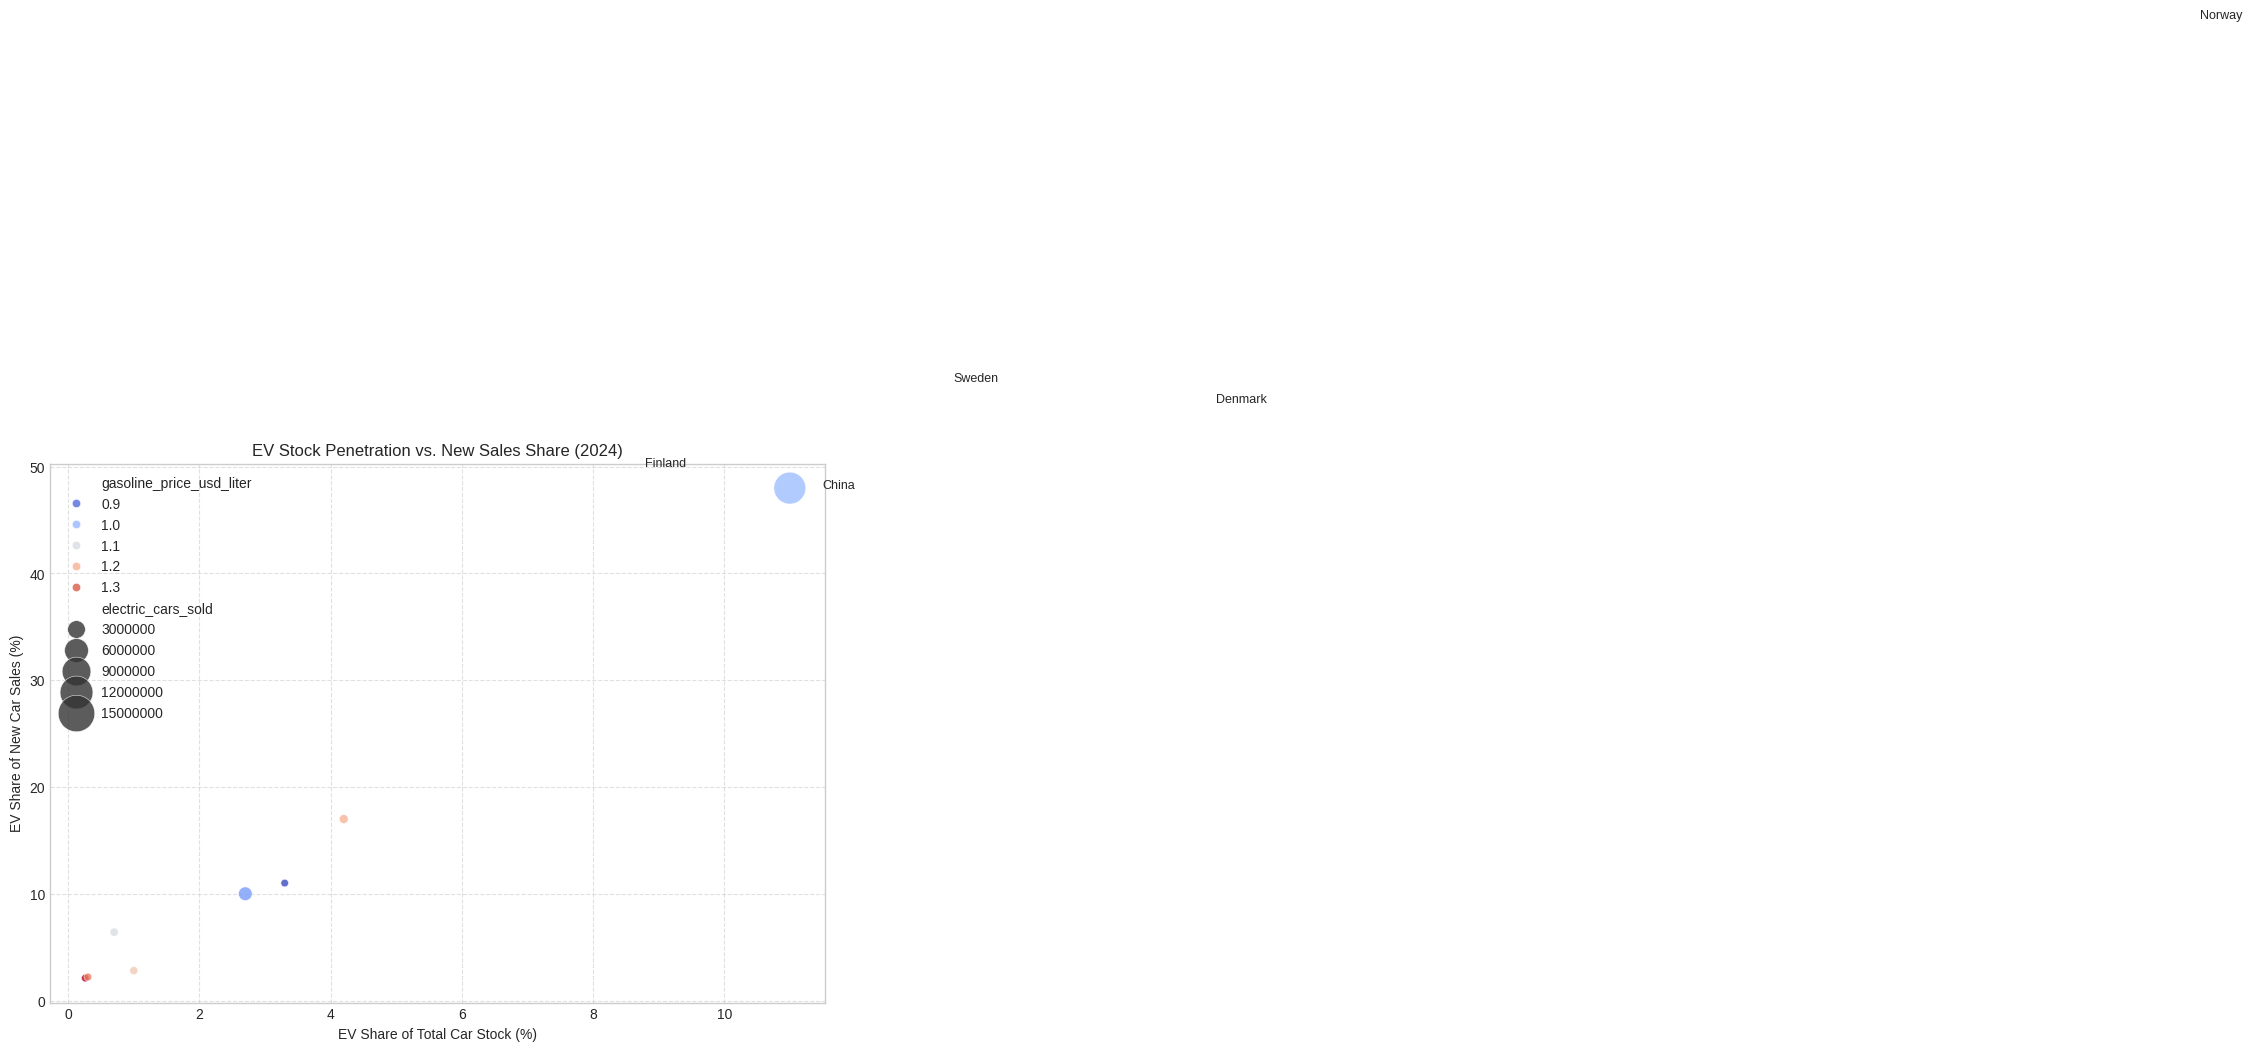

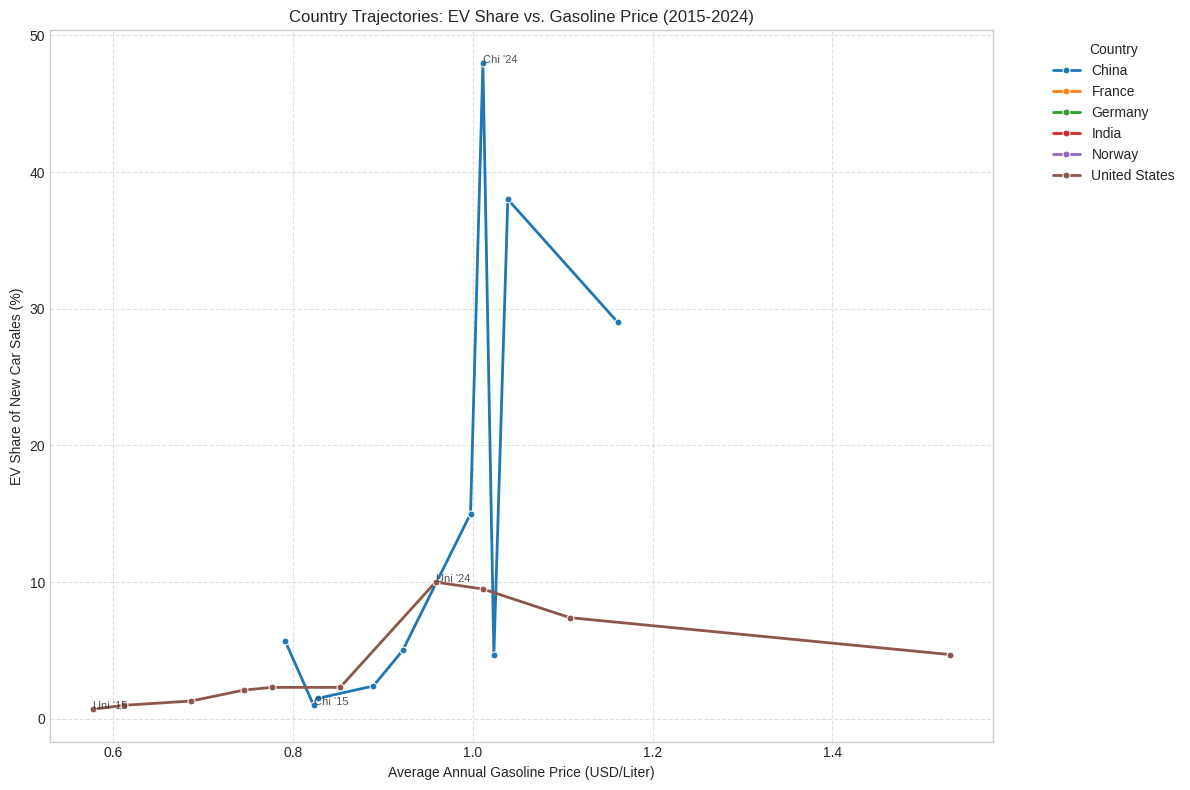

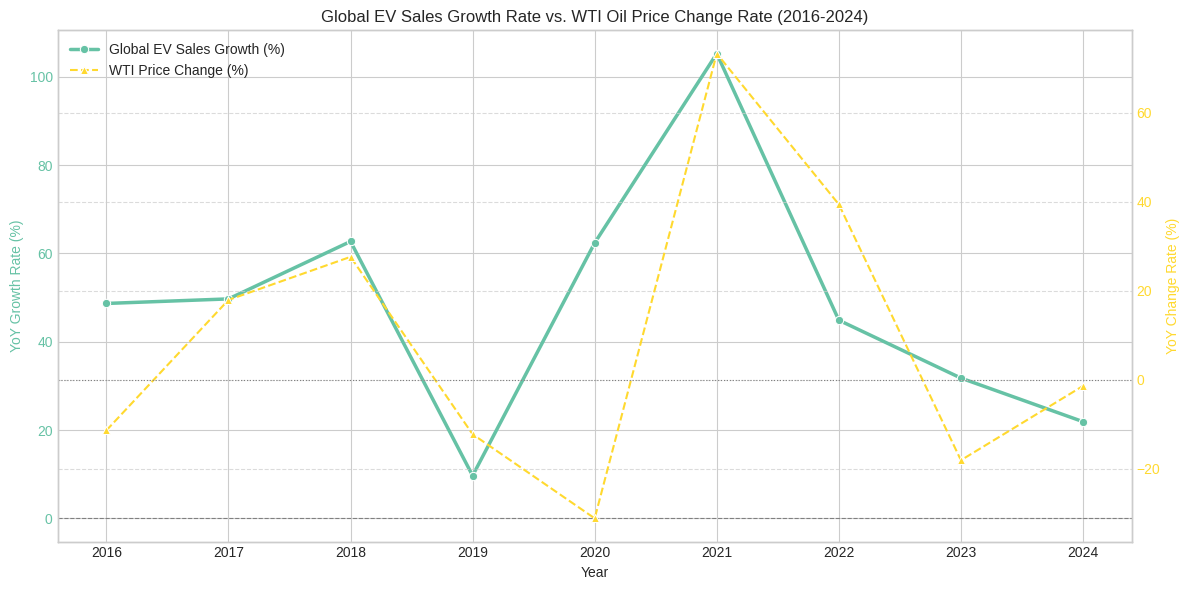

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# --- File Paths ---
final_merged_file = 'final_merged_ev_dataset_annual.csv'

print(f"--- Step 6 (Set 2): Deeper Dive Visualizations ---")

try:
    # Load the primary merged dataset
    df = pd.read_csv(final_merged_file)
    print(f"Loaded merged data: {final_merged_file} (Shape: {df.shape})")

    latest_year = df['year'].max()
    df_latest = df[df['year'] == latest_year].copy()
    plt.style.use('seaborn-v0_8-whitegrid')
    report_palette = sns.color_palette("Set2")

    # Column name definitions (ensure these match your merged file)
    stock_col = 'share_of_car_stocks_that_are_electric'
    sales_col = 'share_of_new_cars_that_are_electric'
    gas_col = 'gasoline_price_usd_liter'
    sales_vol_col = 'electric_cars_sold'
    bev_share_col = 'battery_electric_as_a_share_of_electric_cars_sold'
    policy_col = 'policy_count'
    wti_col = 'WTI_Price_USD_Barrel'


    # --- Plot 9: EV Stock Share vs. New Sales Share ---
    print("Generating Plot 9: Stock Share vs. Sales Share...")
    if stock_col in df.columns and sales_col in df.columns:
        plt.figure(figsize=(10, 7))
        high_share_countries = df_latest.nlargest(5, sales_col)['country'].tolist()
        size_arg = sales_vol_col if sales_vol_col in df_latest.columns else None
        sizes_arg = (30, 800) if size_arg else None
        hue_arg = gas_col if gas_col in df_latest.columns else None

        sns.scatterplot(data=df_latest, x=stock_col, y=sales_col,
                        hue=hue_arg, size=size_arg, sizes=sizes_arg,
                        palette='coolwarm', alpha=0.8, legend='auto')
        plt.title(f'EV Stock Penetration vs. New Sales Share ({latest_year})')
        plt.xlabel('EV Share of Total Car Stock (%)')
        plt.ylabel('EV Share of New Car Sales (%)')
        plt.grid(True, linestyle='--', alpha=0.6)
        for i, row in df_latest.iterrows():
             # Check if stock_col and sales_col are not NaN before plotting text
             if row['country'] in high_share_countries and pd.notna(row[stock_col]) and pd.notna(row[sales_col]):
                  plt.text(row[stock_col] + 0.5, row[sales_col], row['country'], fontsize=9)
        plt.tight_layout()
    else: print("Skipping Plot 9: Required stock/sales share columns not found.")

    # --- Plot 10: BEV Share within EV Sales vs. Overall EV Share ---
    print("Generating Plot 10: BEV Dominance vs. Overall EV Share...")
    if bev_share_col in df.columns and sales_col in df.columns:
        df_plot10 = df_latest[df_latest[sales_col] > 1].copy()
        size_arg = sales_vol_col if sales_vol_col in df_plot10.columns else None
        sizes_arg = (30, 800) if size_arg else None
        hue_arg = policy_col if policy_col in df_plot10.columns else None

        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df_plot10, x=sales_col, y=bev_share_col,
                        hue=hue_arg, size=size_arg, sizes=sizes_arg,
                        palette='magma', alpha=0.8)
        plt.title(f'BEV Share of EVs vs. Total EV Share ({latest_year}, for EV Share > 1%)')
        plt.xlabel('Overall EV Share of New Car Sales (%)')
        plt.ylabel('BEV Share within EV Sales (%)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(title='Policy Count / Sales Vol.', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
    else: print("Skipping Plot 10: Required BEV share or EV share columns not found.")

    # --- Plot 11: Trajectories of Key Countries (EV Share vs. Gasoline Price) ---
    print("Generating Plot 11: Country Trajectories (EV Share vs. Gas Price)...")
    if sales_col in df.columns and gas_col in df.columns:
        countries_to_trace = ['Norway', 'China', 'Germany', 'United States', 'India', 'France']
        df_traj = df[df['country'].isin(countries_to_trace) & (df['year'] >= 2015)].copy()
        plt.figure(figsize=(12, 8))
        sns.lineplot(data=df_traj, x=gas_col, y=sales_col, hue='country',
                     palette='tab10', linewidth=2, marker='o', markersize=5, legend='full')
        for country in countries_to_trace:
             country_data = df_traj[df_traj['country'] == country].sort_values('year')
             if not country_data.empty:
                  # Check for NaNs before adding text
                  if pd.notna(country_data.iloc[0][gas_col]) and pd.notna(country_data.iloc[0][sales_col]):
                      plt.text(country_data.iloc[0][gas_col], country_data.iloc[0][sales_col],
                               f"{country[:3]} '{country_data.iloc[0]['year'] % 100}", fontsize=8, alpha=0.8)
                  if pd.notna(country_data.iloc[-1][gas_col]) and pd.notna(country_data.iloc[-1][sales_col]):
                      plt.text(country_data.iloc[-1][gas_col], country_data.iloc[-1][sales_col],
                               f"{country[:3]} '{country_data.iloc[-1]['year'] % 100}", fontsize=8, alpha=0.8)
        plt.title(f'Country Trajectories: EV Share vs. Gasoline Price (2015-{latest_year})')
        plt.xlabel('Average Annual Gasoline Price (USD/Liter)')
        plt.ylabel('EV Share of New Car Sales (%)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
    else: print("Skipping Plot 11: EV share or gasoline price column not found.")

    # --- Plot 12: Global EV Sales Growth Rate vs. Oil Price Change Rate ---
    print("Generating Plot 12: Global EV Growth Rate vs. Oil Price Change...")
    if sales_vol_col in df.columns and wti_col in df.columns:
        df_global = df.groupby('year').agg(
            total_ev_sales=(sales_vol_col, 'sum'),
            avg_wti_price=(wti_col, 'mean')
        ).reset_index()
        df_global['ev_sales_growth_pct'] = df_global['total_ev_sales'].pct_change() * 100
        df_global['wti_price_change_pct'] = df_global['avg_wti_price'].pct_change() * 100
        df_global_growth = df_global.dropna(subset=['ev_sales_growth_pct', 'wti_price_change_pct'])
        plt.figure(figsize=(12, 6))
        ax1 = plt.gca()
        sns.lineplot(data=df_global_growth, x='year', y='ev_sales_growth_pct', marker='o', ax=ax1, color=report_palette[0], label='Global EV Sales Growth (%)', linewidth=2.5)
        ax1.set_ylabel('YoY Growth Rate (%)', color=report_palette[0])
        ax1.tick_params(axis='y', labelcolor=report_palette[0])
        ax1.set_xlabel('Year'); ax1.axhline(0, color='grey', linestyle='--', linewidth=0.8)
        ax1.set_title(f'Global EV Sales Growth Rate vs. WTI Oil Price Change Rate (2016-{latest_year})')
        ax2 = ax1.twinx()
        sns.lineplot(data=df_global_growth, x='year', y='wti_price_change_pct', marker='^', ax=ax2, color=report_palette[5], label='WTI Price Change (%)', linestyle='--')
        ax2.set_ylabel('YoY Change Rate (%)', color=report_palette[5])
        ax2.tick_params(axis='y', labelcolor=report_palette[5])
        ax2.axhline(0, color='grey', linestyle=':', linewidth=0.8)
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left'); ax1.get_legend().remove()
        plt.grid(True, linestyle='--', alpha=0.7); plt.tight_layout()
    else: print("Skipping Plot 12: EV sales volume or WTI price column not found.")


    print("\n--- Deeper Dive Plots (Set 2) Generated ---")

except FileNotFoundError:
    print(f"Error: Required data file not found.")
except KeyError as ke:
    print(f"Error: A required column was not found. Check column names. Details: {ke}")
except Exception as e:
    print(f"An error occurred during visualization: {e}")

# Plots 9-12 will display after this block.

--- Step 6 (Set 3): Micro-Level Visualizations 1 ---
Loaded merged data: final_merged_ev_dataset_annual.csv (Shape: (340, 14))
Generating Plot 13: EV Share vs. Policy Groups (Faceted by Year)...
Generating Plot 14: Gasoline Price vs. Policy Count...
Generating Plot 15: Market Acceleration vs. Gasoline Price...
Generating Plot 16: BEV Share vs. Gasoline Price...
Skipping Plot 16: Required BEV share, gas price or EV share columns not found.

--- Micro-Level Plots (Set 1) Generated ---


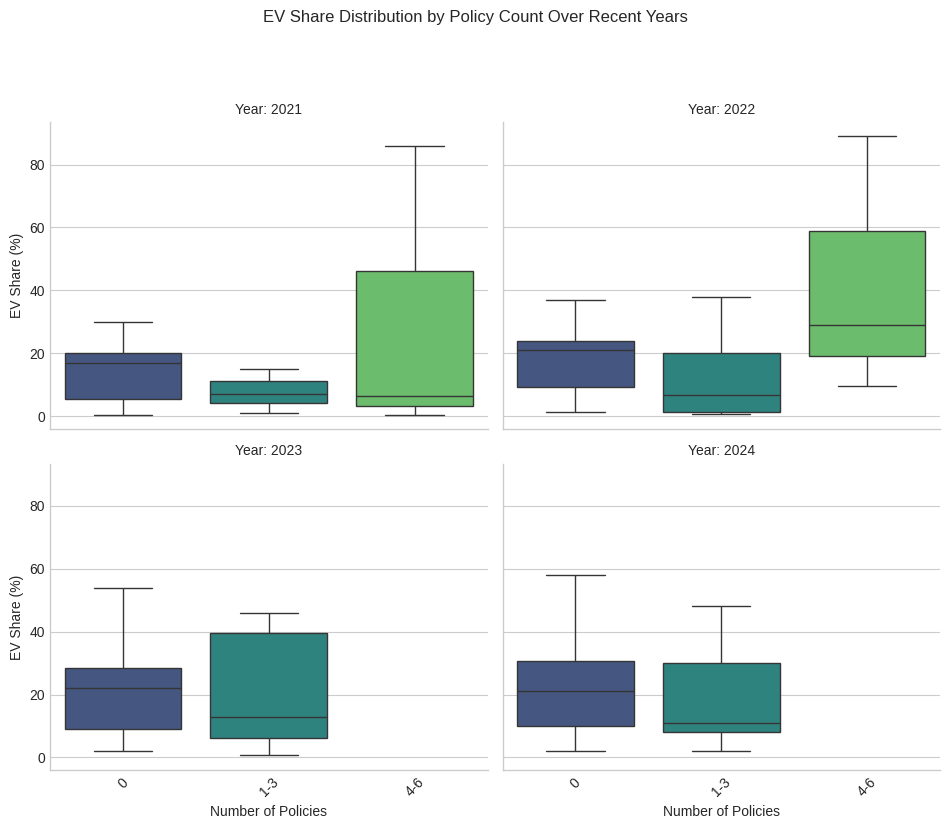

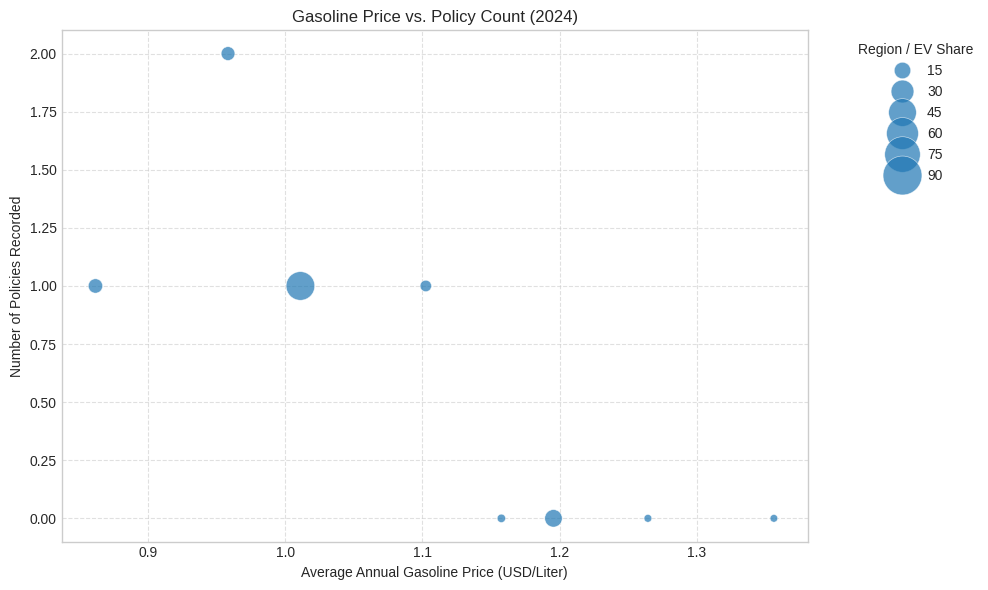

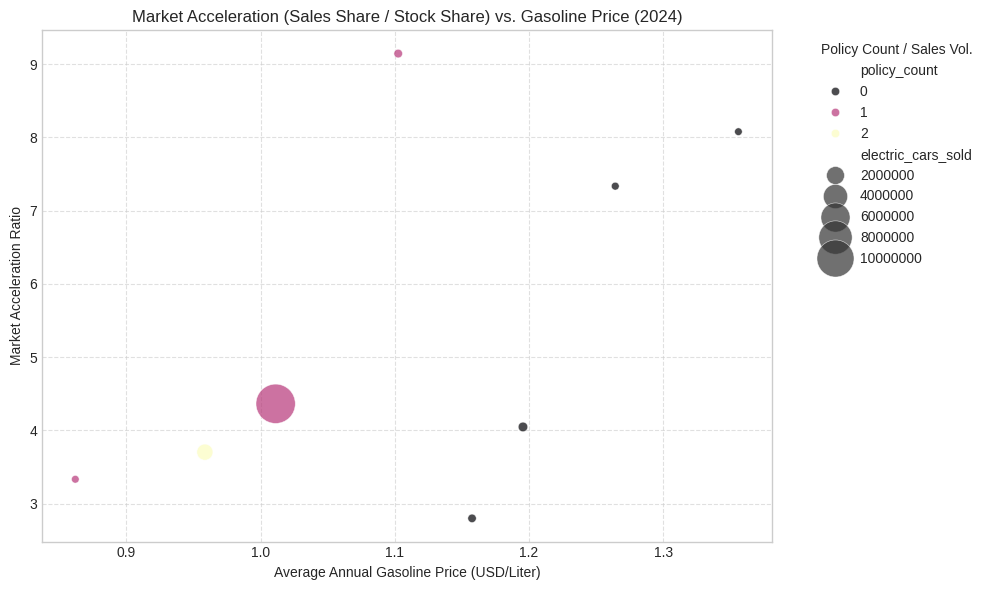

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# --- File Paths ---
final_merged_file = 'final_merged_ev_dataset_annual.csv'

print(f"--- Step 6 (Set 3): Micro-Level Visualizations 1 ---")

try:
    # Load the primary merged dataset
    df = pd.read_csv(final_merged_file)
    print(f"Loaded merged data: {final_merged_file} (Shape: {df.shape})")

    latest_year = df['year'].max()
    df_latest = df[df['year'] == latest_year].copy()
    plt.style.use('seaborn-v0_8-whitegrid')
    report_palette = sns.color_palette("Set2")

    # Column name definitions
    sales_col = 'share_of_new_cars_that_are_electric'
    policy_col = 'policy_count'
    gas_col = 'gasoline_price_usd_liter'
    stock_col = 'share_of_car_stocks_that_are_electric'
    sales_vol_col = 'electric_cars_sold'
    bev_share_col = 'battery_electric_as_a_share_of_electric_cars_sold'
    region_col = 'region' # Assumes region was added in Set 1 plotting

    # --- Plot 13: EV Share vs. Policy Count Groups (Faceted by Year) ---
    print("Generating Plot 13: EV Share vs. Policy Groups (Faceted by Year)...")
    if sales_col in df.columns and policy_col in df.columns:
        max_policies = int(df[policy_col].max())
        bins = [-1, 0, 5, 10, max(max_policies, 11)]
        labels = ['0', '1-5', '6-10', '11+']
        # Adjust bins/labels for low max_policies counts
        if max_policies < 11:
            bins = [-1, 0, 3, max_policies]
            labels = ['0', '1-3', f'4-{max_policies}'] if max_policies >= 4 else ['0','1-3']
        if max_policies < 4:
             bins = [-1, 0, max_policies]
             labels = ['0', f'1-{max_policies}'] if max_policies >=1 else ['0']
        if len(bins) - 1 != len(labels): labels = [f"Group {i+1}" for i in range(len(bins)-1)]

        df['policy_group'] = pd.cut(df[policy_col], bins=bins, labels=labels, right=True)
        years_to_facet = df['year'].unique()[-4:] # Last 4 years
        df_facet = df[df['year'].isin(years_to_facet)].dropna(subset=['policy_group'])

        g = sns.FacetGrid(df_facet, col="year", col_wrap=2, height=4, aspect=1.2, sharey=True)
        g.map_dataframe(sns.boxplot, x="policy_group", y=sales_col, palette="viridis", showfliers=False, order=labels)
        g.set_titles("Year: {col_name}"); g.set_axis_labels("Number of Policies", "EV Share (%)")
        plt.suptitle('EV Share Distribution by Policy Count Over Recent Years', y=1.03)
        for ax in g.axes.flat:
            for label in ax.get_xticklabels(): label.set_rotation(45)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
    else: print("Skipping Plot 13: Missing EV share or policy count columns.")


    # --- Plot 14: Gasoline Price vs. Policy Count (Latest Year) ---
    print("Generating Plot 14: Gasoline Price vs. Policy Count...")
    if gas_col in df_latest.columns and policy_col in df_latest.columns:
        plt.figure(figsize=(10, 6))
        size_arg = sales_col if sales_col in df_latest.columns else None
        sizes_arg = (30, 800) if size_arg else None
        hue_arg = region_col if region_col in df_latest.columns and df_latest[region_col].nunique() > 1 else None

        sns.scatterplot(data=df_latest, x=gas_col, y=policy_col,
                        size=size_arg, sizes=sizes_arg, hue=hue_arg,
                        palette='tab10', alpha=0.7)
        plt.title(f'Gasoline Price vs. Policy Count ({latest_year})')
        plt.xlabel('Average Annual Gasoline Price (USD/Liter)')
        plt.ylabel('Number of Policies Recorded')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(title='Region / EV Share', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
    else: print("Skipping Plot 14: Missing gasoline price or policy count columns.")


    # --- Plot 15: Market Acceleration Ratio vs. Gasoline Price ---
    print("Generating Plot 15: Market Acceleration vs. Gasoline Price...")
    if sales_col in df.columns and stock_col in df.columns and gas_col in df.columns:
        # Calculate acceleration ratio within df_latest
        df_latest['market_acceleration_ratio'] = (df_latest[sales_col] /
                                                 df_latest[stock_col]).replace([np.inf, -np.inf], np.nan)
        df_plot15 = df_latest.dropna(subset=['market_acceleration_ratio', gas_col])

        # Decide on capping based on distribution if needed (e.g., if ratio is highly skewed)
        # cap_value = df_plot15['market_acceleration_ratio'].quantile(0.95) # Example cap
        # df_plot15 = df_plot15[df_plot15['market_acceleration_ratio'] <= cap_value]

        plt.figure(figsize=(10, 6))
        size_arg = sales_vol_col if sales_vol_col in df_plot15.columns else None
        sizes_arg = (30, 800) if size_arg else None
        hue_arg = policy_col if policy_col in df_plot15.columns else None

        sns.scatterplot(data=df_plot15, x=gas_col, y='market_acceleration_ratio',
                        hue=hue_arg, size=size_arg, sizes=sizes_arg,
                        palette='magma', alpha=0.7)
        plt.title(f'Market Acceleration (Sales Share / Stock Share) vs. Gasoline Price ({latest_year})')
        plt.xlabel('Average Annual Gasoline Price (USD/Liter)')
        plt.ylabel('Market Acceleration Ratio')
        # plt.ylim(0, cap_value * 1.1) # Apply cap if used
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(title='Policy Count / Sales Vol.', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
    else: print("Skipping Plot 15: Required stock/sales share or gas price columns not found.")


    # --- Plot 16: BEV Share of EVs vs. Gasoline Price ---
    print("Generating Plot 16: BEV Share vs. Gasoline Price...")
    if bev_share_col in df.columns and gas_col in df.columns and sales_col in df.columns:
        df_plot16 = df_latest[df_latest[sales_col] > 1].dropna(subset=[gas_col, bev_share_col])
        plt.figure(figsize=(10, 6))
        size_arg = sales_vol_col if sales_vol_col in df_plot16.columns else None
        sizes_arg = (30, 800) if size_arg else None
        hue_arg = sales_col # Color by overall EV share

        sns.scatterplot(data=df_plot16, x=gas_col, y=bev_share_col,
                        hue=hue_arg, size=size_arg, sizes=sizes_arg,
                        palette='viridis', alpha=0.8)
        sns.regplot(data=df_plot16, x=gas_col, y=bev_share_col, scatter=False, color='red', line_kws={'linestyle':'--','linewidth':1})
        plt.title(f'BEV Share within EV Sales vs. Gasoline Price ({latest_year}, EV Share > 1%)')
        plt.xlabel('Average Annual Gasoline Price (USD/Liter)')
        plt.ylabel('BEV Share within EV Sales (%)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(title='Overall EV Share (%) / Sales Vol.', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
    else: print("Skipping Plot 16: Required BEV share, gas price or EV share columns not found.")


    print("\n--- Micro-Level Plots (Set 1) Generated ---")

except FileNotFoundError:
    print(f"Error: Required data file not found.")
except KeyError as ke:
    print(f"Error: A required column was not found. Check column names. Details: {ke}")
except Exception as e:
    print(f"An error occurred during visualization: {e}")

# Plots 13-16 will display after this block.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# --- File Paths ---
final_merged_file = 'final_merged_ev_dataset_annual.csv'
policy_raw_file = 'combined_policy_data_raw.csv' # Needed for policy categorization

print(f"--- Step 6 (Set 4): Further Micro-Level Visualizations ---")

try:
    # Load the primary merged dataset
    df = pd.read_csv(final_merged_file)
    print(f"Loaded merged data: {final_merged_file} (Shape: {df.shape})")

    latest_year = df['year'].max()
    plt.style.use('seaborn-v0_8-whitegrid')
    report_palette = sns.color_palette("tab10")

    # Column name definitions
    sales_col = 'share_of_new_cars_that_are_electric'
    gas_col = 'gasoline_price_usd_liter'
    bev_share_col = 'battery_electric_as_a_share_of_electric_cars_sold'
    policy_col = 'policy_count'

    # --- Plot 17: EV Adoption Trend in High Gasoline Price Countries ---
    print("Generating Plot 17: EV Trend in High Gas Price Countries...")
    if gas_col in df.columns and sales_col in df.columns:
        avg_gas_prices = df.groupby('country')[gas_col].mean()
        high_gas_countries_all = avg_gas_prices[avg_gas_prices > 1.5].index.tolist()
        # Select prominent examples known from previous plots or common knowledge
        high_gas_countries_plot = [c for c in ['Norway', 'Netherlands', 'Iceland', 'Denmark', 'Greece', 'Portugal', 'Italy', 'France'] if c in high_gas_countries_all][:5]

        if high_gas_countries_plot:
            df_high_gas_trend = df[df['country'].isin(high_gas_countries_plot) & (df['year'] >= 2015)]
            plt.figure(figsize=(12, 7))
            sns.lineplot(data=df_high_gas_trend, x='year', y=sales_col, hue='country', marker='o', linewidth=2.5, palette=report_palette)
            plt.title(f'EV Share Trend in Select High Gasoline Price Countries (2015-{latest_year})')
            plt.xlabel('Year'); plt.ylabel('EV Share (%)')
            plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout()
        else:
            print("Skipping Plot 17: No countries found meeting high gas price criteria or specified countries not in data.")
    else: print("Skipping Plot 17: Missing gasoline price or EV share columns.")

    # --- Plot 18: BEV Share Trend in Specific Markets ---
    print("Generating Plot 18: BEV Share Trend in Specific Markets...")
    if bev_share_col in df.columns and sales_col in df.columns:
        markets_to_plot_bev = ['Norway', 'China', 'Germany', 'United States', 'France']
        df_bev_trend = df[df['country'].isin(markets_to_plot_bev) & (df['year'] >= 2015)]
        df_bev_trend = df_bev_trend[df_bev_trend[sales_col] >= 1] # Filter for EV Share >= 1%
        plt.figure(figsize=(12, 7))
        sns.lineplot(data=df_bev_trend, x='year', y=bev_share_col, hue='country', marker='o', linewidth=2.5, palette=report_palette)
        plt.title(f'BEV Share within EV Sales - Select Markets (2015-{latest_year}, where EV Share >= 1%)')
        plt.xlabel('Year'); plt.ylabel('BEV Share within EV Sales (%)')
        plt.ylim(0, 105)
        plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout()
    else: print("Skipping Plot 18: Required BEV share or EV share columns not found.")


    # --- Plot 19: Correlation Scatter Plot (EV Share vs. Gas Price) for Select Countries ---
    print("Generating Plot 19: EV Share vs. Gas Price (Per Country Facets)...")
    if sales_col in df.columns and gas_col in df.columns:
        countries_for_facet = ['Norway', 'China', 'Germany', 'United States', 'United Kingdom', 'France']
        df_facet_country = df[df['country'].isin(countries_for_facet) & (df['year'] >= 2015)].copy()
        g = sns.FacetGrid(df_facet_country, col="country", col_wrap=3, height=4, aspect=1, sharex=False, sharey=False)
        g.map_dataframe(sns.scatterplot, x=gas_col, y=sales_col, color=report_palette[2], alpha=0.8)
        g.map_dataframe(sns.regplot, x=gas_col, y=sales_col, scatter=False, color='red', line_kws={'linestyle':'--','linewidth':1})
        g.set_titles("{col_name}")
        g.set_axis_labels("Avg. Gas Price (USD/L)", "EV Share (%)")
        plt.suptitle(f'EV Share vs. Gasoline Price Relationship by Country (2015-{latest_year})', y=1.03)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
    else: print("Skipping Plot 19: Missing EV share or gasoline price columns.")


    # --- Plot 20: Impact of Financial Incentives Over Time ---
    print("Generating Plot 20: Impact of Financial Incentives...")
    policy_categories_available = False
    try:
        df_policy = pd.read_csv(policy_raw_file)
        df_policy['category_simple'] = df_policy['category'].fillna('Unknown').str.lower()
        df_policy['category_simple'] = df_policy['category_simple'].replace({
             '.*tax.*|.*subsidy.*|.*incentive.*|.*grant.*|rebate': 'Financial Incentive',
             # Add other mappings if needed for simplification, reuse previous code
        }, regex=True)
        # Identify countries/years with financial incentives
        financial_incentive_flag = df_policy[df_policy['category_simple'] == 'Financial Incentive'][['country', 'year']].drop_duplicates()
        financial_incentive_flag['has_financial_incentive'] = 1
        # Merge flag into main df
        df_merged_policy = pd.merge(df, financial_incentive_flag, on=['country', 'year'], how='left')
        df_merged_policy['has_financial_incentive'] = df_merged_policy['has_financial_incentive'].fillna(0).astype(int)
        policy_categories_available = True
    except Exception as e:
         print(f"Warning: Could not process policy file for Plot 20: {e}.")

    if policy_categories_available and sales_col in df_merged_policy.columns:
        policy_impact_trend = df_merged_policy.groupby(['year', 'has_financial_incentive'])[sales_col].mean().reset_index()
        policy_impact_trend['Incentive Status'] = policy_impact_trend['has_financial_incentive'].map({1: 'Has Financial Incentive', 0: 'No Financial Incentive'})
        plt.figure(figsize=(12, 7))
        sns.lineplot(data=policy_impact_trend, x='year', y=sales_col, hue='Incentive Status', marker='o

SyntaxError: unterminated string literal (detected at line 106) (ipython-input-683547728.py, line 106)